# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 124
  d_ff                      : 64
  d_freq                    : 7    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 4 
  num_heads                 : 12
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [5]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20', 'Time'],
      dtype='object')


Processing AAPL (train): 100%|██████████████████████| 1066/1066 [00:00<00:00, 24809.28it/s]
[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14',
       'HalfTrend_20', 'Time'],
      dtype='object')


Processing AAPL (val): 100%|██████████████████████████| 187/187 [00:00<00:00, 32999.61it/s]


In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


9 1
First input sample (shape: torch.Size([5, 9])):
tensor([[ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
          2.4320e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4716e-02,  1.3358e-02,  1.2551e-02,  1.2437e-02,  3.7390e-01,
          2.3978e+01,  0.0000e+00, -1.0000e+00,  1.0000e+00],
        [ 1.3076e-02,  1.2221e-02,  1.1819e-02,  1.2446e-02,  3.8356e-01,
          2.3864e+01,  3.2355e-01, -1.0000e+00,  2.0000e+00],
        [ 1.3695e-02,  1.2938e-02,  1.3763e-02,  1.3839e-02,  2.1930e-01,
          2.3891e+01,  3.2750e+01,  1.0000e+00,  3.0000e+00],
        [ 1.5598e-02,  1.6617e-02,  1.5641e-02,  1.7707e-02,  3.4243e-01,
          2.4090e+01,  6.4679e+01,  1.0000e+00,  4.0000e+00]])
Corresponding target (shape: torch.Size([5, 9])):
tensor([[ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
          2.4320e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.7622e-02,  1.5956e-02,  1.4373e-02,  1.5315e-02,  3.0305e-01,
       

Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 5, 124]              --
│    │    └─Linear: 3-1                       [16, 5, 124]              248
│    │    └─GELU: 3-2                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-3                    [16, 5, 124]              248
│    │    └─Dropout: 3-4                      [16, 5, 124]              --
│    └─Sequential: 2-2                        [16, 5, 124]              --
│    │    └─Linear: 3-5                       [16, 5, 124]              248
│    │    └─GELU: 3-6                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-7                    [16, 5, 124]              248
│    │    └─Dropout: 3-8                      [16, 5, 124]              --
│    └─Sequential

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/thirunel/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


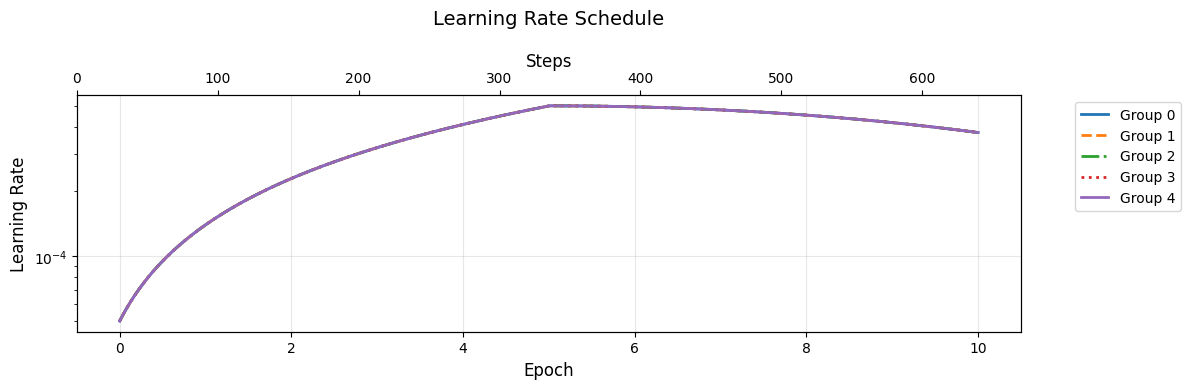

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023903450928628445
abm_loss is 0.007490643300116062


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   1%| | 1/67 [00:00<00:17,  3.76it/s, batch_accuracy=1.25%, loss=0.0177, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019660014659166336
abm_loss is 0.007059069816023111


Training:   7%| | 5/67 [00:00<00:05, 11.92it/s, batch_accuracy=3.75%, loss=0.0088, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023087828885763884
abm_loss is 0.006510901730507612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001760728657245636
abm_loss is 0.0056772492825984955
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001582597615197301
abm_loss is 0.003498759586364031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013161435490474105
abm_loss is 0.0028544291853904724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:03, 16.95it/s, batch_accuracy=2.50%, loss=0.0103, mae=nan]

mse_loss is 0.0012104756897315383
abm_loss is 0.005475804675370455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015786916483193636
abm_loss is 0.005070257466286421


Training:  15%|▏| 10/67 [00:00<00:02, 19.79it/s, batch_accuracy=3.75%, loss=0.0064, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001618184964172542
abm_loss is 0.0015620369231328368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001100816298276186
abm_loss is 0.002241875045001507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010702237486839294
abm_loss is 0.0013571659801527858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006759733660146594
abm_loss is 0.0006654281169176102


Training:  19%|▏| 13/67 [00:00<00:02, 21.90it/s, batch_accuracy=5.00%, loss=0.0053, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008059560204856098
abm_loss is 0.0016185215208679438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 23.32it/s, batch_accuracy=8.75%, loss=0.0116, mae=nan

mse_loss is 0.000990116037428379
abm_loss is 0.0038893388118594885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012614283477887511
abm_loss is 0.00568081671372056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000738633971195668
abm_loss is 0.005352248903363943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006589632830582559
abm_loss is 0.010740535333752632
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010336496634408832
abm_loss is 0.01894625462591648


Training:  25%|▎| 17/67 [00:00<00:02, 23.32it/s, batch_accuracy=16.25%, loss=0.0198, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006322112749330699
abm_loss is 0.024040600284934044


Training:  33%|▎| 22/67 [00:01<00:01, 24.79it/s, batch_accuracy=17.50%, loss=0.0316, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006976666045375168
abm_loss is 0.020072322338819504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009089433588087559
abm_loss is 0.024124031886458397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001074021216481924
abm_loss is 0.02265612967312336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001469105132855475
abm_loss is 0.031471189111471176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001692425343208015
abm_loss is 0.033878594636917114


Training:  34%|▎| 23/67 [00:01<00:01, 24.79it/s, batch_accuracy=13.75%, loss=0.0346, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024869453627616167
abm_loss is 0.028017431497573853


Training:  42%|▍| 28/67 [00:01<00:01, 25.29it/s, batch_accuracy=31.25%, loss=0.0785, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020409112330526114
abm_loss is 0.031608469784259796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001414499245584011
abm_loss is 0.04686184599995613
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009574724244885147
abm_loss is 0.0532221794128418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008662110194563866
abm_loss is 0.09620823711156845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047246599569916725
abm_loss is 0.11035191267728806


Training:  43%|▍| 29/67 [00:01<00:01, 25.29it/s, batch_accuracy=50.00%, loss=0.0874, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017164743039757013
abm_loss is 0.05874302610754967


Training:  51%|▌| 34/67 [00:01<00:01, 25.53it/s, batch_accuracy=17.50%, loss=0.0495, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005975553300231695
abm_loss is 0.015330753289163113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003758121281862259
abm_loss is 0.03069225326180458
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016398032894358039
abm_loss is 0.06199129298329353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015866392059251666
abm_loss is 0.0538865327835083
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.53it/s, batch_accuracy=36.25%, loss=0.0660, mae=na

mse_loss is 0.0007473588339053094
abm_loss is 0.08080334961414337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046962566557340324
abm_loss is 0.09452314674854279


Training:  60%|▌| 40/67 [00:01<00:01, 25.86it/s, batch_accuracy=2.50%, loss=0.3162, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000898645375855267
abm_loss is 0.14067105948925018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024627135135233402
abm_loss is 0.23330532014369965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006077357567846775
abm_loss is 0.37070363759994507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002652127295732498
abm_loss is 0.3057812750339508


Training:  61%|▌| 41/67 [00:01<00:01, 25.86it/s, batch_accuracy=37.50%, loss=0.1738, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010203745914623141
abm_loss is 0.21881096065044403
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:02<00:00, 26.09it/s, batch_accuracy=0.00%, loss=0.8867, mae=nan

mse_loss is 0.002668464556336403
abm_loss is 0.40679341554641724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007272738963365555
abm_loss is 0.6785575151443481
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022866813465952873
abm_loss is 1.2028223276138306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012616652064025402
abm_loss is 1.068198561668396
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011174924671649933
abm_loss is 1.195621371269226


Training:  69%|▋| 46/67 [00:02<00:00, 26.09it/s, batch_accuracy=3.75%, loss=0.9777, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016375627368688583
abm_loss is 1.5086125135421753


Training:  78%|▊| 52/67 [00:02<00:00, 25.96it/s, batch_accuracy=57.50%, loss=1.2890, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00588280288502574
abm_loss is 1.1976794004440308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033935904502868652
abm_loss is 1.2802647352218628
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001393828191794455
abm_loss is 1.1775448322296143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003579661250114441
abm_loss is 1.6486711502075195
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.96it/s, batch_accuracy=65.00%, loss=1.3125, mae=na

mse_loss is 0.002384499181061983
abm_loss is 1.6870006322860718
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002087031491100788
abm_loss is 1.5768805742263794


Training:  84%|▊| 56/67 [00:02<00:00, 25.77it/s, batch_accuracy=53.75%, loss=1.5880, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003977738320827484
abm_loss is 2.2539029121398926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031624536495655775
abm_loss is 2.306034803390503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00552527466788888
abm_loss is 2.02394437789917
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012897699140012264
abm_loss is 1.8306715488433838


Training:  87%|▊| 58/67 [00:02<00:00, 25.89it/s, batch_accuracy=2.50%, loss=1.0931, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047312017530202866
abm_loss is 1.1106312274932861
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033541470766067505
abm_loss is 1.6114788055419922


Training:  93%|▉| 62/67 [00:02<00:00, 26.08it/s, batch_accuracy=0.00%, loss=1.2100, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047087639570236206
abm_loss is 1.4562745094299316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0702114924788475
abm_loss is 1.1414254903793335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.08979494124650955
abm_loss is 0.9862724542617798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 25.61it/s, batch_accuracy=1.25%, loss=1.4042, mae=nan

mse_loss is 0.08038579672574997
abm_loss is 1.1202027797698975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05576537176966667
abm_loss is 1.459181547164917
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training: 100%|█| 67/67 [00:02<00:00, 23.57it/s, batch_accuracy=36.00%, loss=1.9566, mae=na


mse_loss is 0.024337144568562508
abm_loss is 1.963037371635437
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.014882118441164494
abm_loss is 2.441209077835083

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.4846 | train_mae: nan | train_accuracy: 19.0807


Training:   7%| | 5/67 [00:00<00:02, 20.82it/s, batch_accuracy=0.00%, loss=0.4312, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.19543766975402832
abm_loss is 0.16076485812664032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.15850567817687988
abm_loss is 0.1154748722910881
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.1411534547805786
abm_loss is 0.09835898876190186
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.11279582977294922
abm_loss is 0.0746685042977333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07790639251470566
abm_loss is 0.05334249138832092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 22.77it/s, batch_accuracy=1.25%, loss=0.0384, mae=nan]

mse_loss is 0.06016644462943077
abm_loss is 0.0439249649643898
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034964241087436676
abm_loss is 0.021264001727104187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013973894529044628
abm_loss is 0.00833428930491209
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010793223977088928
abm_loss is 0.009255894459784031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006930083967745304
abm_loss is 0.004831416066735983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022150594741106033
abm_loss is 0.0030943830497562885


Training:  22%|▏| 15/67 [00:00<00:02, 24.20it/s, batch_accuracy=1.25%, loss=0.0870, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005108128767460585
abm_loss is 0.00653924560174346
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007452962454408407
abm_loss is 0.012193156406283379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012929028831422329
abm_loss is 0.023591136559844017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016718721017241478
abm_loss is 0.030100960284471512
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01311256643384695
abm_loss is 0.027734065428376198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.10it/s, batch_accuracy=6.25%, loss=0.0711, mae=nan

mse_loss is 0.016648873686790466
abm_loss is 0.045275527983903885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014163623563945293
abm_loss is 0.052446287125349045
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013515323400497437
abm_loss is 0.06093886122107506
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012253919616341591
abm_loss is 0.053565867245197296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006328004878014326
abm_loss is 0.05111338570713997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004762195982038975
abm_loss is 0.045710474252700806


Training:  39%|▍| 26/67 [00:01<00:01, 25.87it/s, batch_accuracy=16.25%, loss=0.0485, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037644330877810717
abm_loss is 0.05184311419725418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022966554388403893
abm_loss is 0.04942422732710838
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001798810437321663
abm_loss is 0.04311904311180115
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024864624720066786
abm_loss is 0.03815259411931038
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028021973557770252
abm_loss is 0.044732965528964996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006032316945493221
abm_loss is 0.0436074398458004


Training:  48%|▍| 32/67 [00:01<00:01, 25.88it/s, batch_accuracy=0.00%, loss=0.1136, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005839100573211908
abm_loss is 0.069593146443367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004392705857753754
abm_loss is 0.08610981702804565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009873618371784687
abm_loss is 0.039622049778699875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017442654818296432
abm_loss is 0.011962341144680977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019628679379820824
abm_loss is 0.01989462412893772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014622226357460022
abm_loss is 0.04147953912615776


Training:  57%|▌| 38/67 [00:01<00:01, 25.82it/s, batch_accuracy=28.75%, loss=0.1533, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014985702000558376
abm_loss is 0.03239154443144798
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012607715092599392
abm_loss is 0.048386506736278534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008421335369348526
abm_loss is 0.06029386445879936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006541934795677662
abm_loss is 0.09509674459695816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002546753967180848
abm_loss is 0.1822976917028427
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.70it/s, batch_accuracy=8.75%, loss=0.5865, mae=nan

mse_loss is 0.0026373278815299273
abm_loss is 0.3249557912349701
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002707798033952713
abm_loss is 0.27546605467796326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002169884741306305
abm_loss is 0.21620221436023712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036931566428393126
abm_loss is 0.4136282503604889
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010027715004980564
abm_loss is 0.6956684589385986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024760356172919273
abm_loss is 1.2125123739242554


Training:  75%|▋| 50/67 [00:01<00:00, 26.14it/s, batch_accuracy=43.75%, loss=1.0262, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0204580407589674
abm_loss is 1.1322197914123535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015293493866920471
abm_loss is 1.219835877418518
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02170250006020069
abm_loss is 1.5897119045257568
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00934065505862236
abm_loss is 1.2404348850250244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005371617618948221
abm_loss is 1.2962061166763306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00251496653072536
abm_loss is 1.1703591346740723


Training:  84%|▊| 56/67 [00:02<00:00, 26.07it/s, batch_accuracy=53.75%, loss=1.7407, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00362201570533216
abm_loss is 1.6370877027511597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00268284953199327
abm_loss is 1.664957046508789
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006346574518829584
abm_loss is 1.5151634216308594
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004651731811463833
abm_loss is 2.1522605419158936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005864096339792013
abm_loss is 2.2197165489196777
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014230526052415371
abm_loss is 1.92169988155365


Training:  93%|▉| 62/67 [00:02<00:00, 26.02it/s, batch_accuracy=0.00%, loss=1.2189, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022560609504580498
abm_loss is 1.747230887413025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.061517953872680664
abm_loss is 1.0561307668685913
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04360831528902054
abm_loss is 1.5824947357177734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04675181955099106
abm_loss is 1.4391597509384155
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06596213579177856
abm_loss is 1.152644395828247
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  99%|▉| 66/67 [00:02<00:00, 26.08it/s, batch_accuracy=46.00%, loss=1.9781, mae=na

mse_loss is 0.08623912185430527
abm_loss is 0.9693778157234192
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07023656368255615
abm_loss is 1.1415541172027588
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03806724026799202
abm_loss is 1.5143007040023804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023518670350313187
abm_loss is 1.9695625305175781
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.00876266323029995
abm_loss is 2.5089244842529297


Training: 100%|█| 67/67 [00:02<00:00, 25.02it/s, batch_accuracy=46.00%, loss=1.9781, mae=na



📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.5672 | train_mae: nan | train_accuracy: 12.4578


Training:   1%| | 1/67 [00:00<00:07,  9.42it/s, batch_accuracy=0.00%, loss=0.0631, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01174855511635542
abm_loss is 0.005521737039089203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009330546483397484
abm_loss is 0.004694425966590643


Training:   6%| | 4/67 [00:00<00:03, 19.35it/s, batch_accuracy=0.00%, loss=0.0829, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013631661422550678
abm_loss is 0.005830775480717421
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014262574724853039
abm_loss is 0.005972804967314005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015364921651780605
abm_loss is 0.007684786804020405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.63it/s, batch_accuracy=0.00%, loss=0.1293, mae=nan]

mse_loss is 0.018686240538954735
abm_loss is 0.01029255986213684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023699166253209114
abm_loss is 0.013859689235687256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01691715233027935
abm_loss is 0.010873413644731045


Training:  15%|▏| 10/67 [00:00<00:02, 23.70it/s, batch_accuracy=0.00%, loss=0.1428, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01872883550822735
abm_loss is 0.016278592869639397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025688424706459045
abm_loss is 0.018361464142799377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01231079176068306
abm_loss is 0.00987993087619543


Training:  19%|▏| 13/67 [00:00<00:02, 24.67it/s, batch_accuracy=0.00%, loss=0.0606, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014608830213546753
abm_loss is 0.012101063504815102
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011032232083380222
abm_loss is 0.006930510047823191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.27it/s, batch_accuracy=1.25%, loss=0.0195, mae=nan

mse_loss is 0.007476524915546179
abm_loss is 0.003502895822748542
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004151350352913141
abm_loss is 0.005055519752204418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003180054249241948
abm_loss is 0.004658920224756002
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026169661432504654
abm_loss is 0.010610237717628479


Training:  25%|▎| 17/67 [00:00<00:01, 25.27it/s, batch_accuracy=3.75%, loss=0.0378, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036764040123671293
abm_loss is 0.02516857348382473
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004264628514647484
abm_loss is 0.030820950865745544


Training:  33%|▎| 22/67 [00:00<00:01, 25.64it/s, batch_accuracy=6.25%, loss=0.0429, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005404868628829718
abm_loss is 0.03603508695960045
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031785524915903807
abm_loss is 0.025426378473639488
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032706724014133215
abm_loss is 0.03441610932350159
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004000910557806492
abm_loss is 0.03564042970538139


Training:  34%|▎| 23/67 [00:00<00:01, 25.64it/s, batch_accuracy=10.00%, loss=0.0526, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0053845844231545925
abm_loss is 0.03320678696036339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011422679759562016
abm_loss is 0.025015635415911674


Training:  42%|▍| 28/67 [00:01<00:01, 25.83it/s, batch_accuracy=1.25%, loss=0.0823, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009750661440193653
abm_loss is 0.025300679728388786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011099434457719326
abm_loss is 0.03402755782008171
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010509252548217773
abm_loss is 0.038543011993169785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.83it/s, batch_accuracy=10.00%, loss=0.0942, mae=na

mse_loss is 0.010032609105110168
abm_loss is 0.06267968565225601
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006674211006611586
abm_loss is 0.07890548557043076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006113169714808464
abm_loss is 0.06220419332385063


Training:  48%|▍| 32/67 [00:01<00:01, 25.86it/s, batch_accuracy=3.75%, loss=0.0934, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009555043652653694
abm_loss is 0.01913665048778057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015100724995136261
abm_loss is 0.023025963455438614
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008011585101485252
abm_loss is 0.05628211051225662


Training:  52%|▌| 35/67 [00:01<00:01, 25.85it/s, batch_accuracy=18.75%, loss=0.0814, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00383363151922822
abm_loss is 0.06418251991271973
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004019928630441427
abm_loss is 0.07945753633975983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038671528454869986
abm_loss is 0.10434670746326447


Training:  57%|▌| 38/67 [00:01<00:01, 26.04it/s, batch_accuracy=26.25%, loss=0.2151, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004275124985724688
abm_loss is 0.15247026085853577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006019700318574905
abm_loss is 0.23988060653209686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.80it/s, batch_accuracy=3.75%, loss=0.1780, mae=nan

mse_loss is 0.005330927204340696
abm_loss is 0.34824609756469727
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005320281721651554
abm_loss is 0.27505311369895935
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009366916492581367
abm_loss is 0.17000965774059296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006219687405973673
abm_loss is 0.32621097564697266


Training:  64%|▋| 43/67 [00:01<00:00, 26.08it/s, batch_accuracy=42.50%, loss=0.4433, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004036444704979658
abm_loss is 0.5488070845603943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036374428309500217
abm_loss is 0.950391411781311


Training:  70%|▋| 47/67 [00:01<00:00, 25.84it/s, batch_accuracy=22.50%, loss=0.9382, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007599783129990101
abm_loss is 0.830385148525238
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010515096597373486
abm_loss is 0.8937357068061829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011332533322274685
abm_loss is 1.1432955265045166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.97it/s, batch_accuracy=5.00%, loss=0.8562, mae=nan

mse_loss is 0.022074008360505104
abm_loss is 0.8824572563171387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022385690361261368
abm_loss is 0.9652542471885681
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034094762057065964
abm_loss is 0.8899108171463013


Training:  78%|▊| 52/67 [00:02<00:00, 26.20it/s, batch_accuracy=13.75%, loss=1.1799, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01916629448533058
abm_loss is 1.3025904893875122
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015407145023345947
abm_loss is 1.430328607559204
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018158268183469772
abm_loss is 1.3826572895050049


Training:  82%|▊| 55/67 [00:02<00:00, 25.85it/s, batch_accuracy=61.25%, loss=1.7215, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006522308569401503
abm_loss is 2.164937734603882
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004593655001372099
abm_loss is 2.2031209468841553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  87%|▊| 58/67 [00:02<00:00, 26.01it/s, batch_accuracy=1.25%, loss=1.0836, mae=nan

mse_loss is 0.00937917735427618
abm_loss is 1.9771181344985962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018211394548416138
abm_loss is 1.7577307224273682
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044801078736782074
abm_loss is 1.1145533323287964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023911988362669945
abm_loss is 1.6693305969238281


Training:  91%|▉| 61/67 [00:02<00:00, 26.06it/s, batch_accuracy=5.00%, loss=1.3555, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033216070383787155
abm_loss is 1.5424734354019165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.046082284301519394
abm_loss is 1.2235167026519775


Training:  96%|▉| 64/67 [00:02<00:00, 25.91it/s, batch_accuracy=7.50%, loss=1.3712, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06131751090288162
abm_loss is 1.0572091341018677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050355322659015656
abm_loss is 1.208614468574524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03010869026184082
abm_loss is 1.5830551385879517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013885937631130219
abm_loss is 2.0257813930511475


Training: 100%|█| 67/67 [00:02<00:00, 26.25it/s, batch_accuracy=66.00%, loss=2.0050, mae=na

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005860515870153904
abm_loss is 2.562607765197754


Training: 100%|█| 67/67 [00:02<00:00, 25.08it/s, batch_accuracy=66.00%, loss=2.0050, mae=na



📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.4726 | train_mae: nan | train_accuracy: 11.6510


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09528607130050659
abm_loss is 0.12606416642665863


Training:   1%| | 1/67 [00:00<00:06,  9.84it/s, batch_accuracy=0.00%, loss=0.5852, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.09514924138784409
abm_loss is 0.14119556546211243


Training:   6%| | 4/67 [00:00<00:03, 19.87it/s, batch_accuracy=0.00%, loss=0.2702, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07593846321105957
abm_loss is 0.11874468624591827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0567554235458374
abm_loss is 0.09531432390213013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04318875074386597
abm_loss is 0.07003959268331528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:03, 19.87it/s, batch_accuracy=0.00%, loss=0.1580, mae=nan]

mse_loss is 0.02538839541375637
abm_loss is 0.04011576995253563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01596573367714882
abm_loss is 0.030725348740816116


Training:  10%| | 7/67 [00:00<00:02, 22.63it/s, batch_accuracy=0.00%, loss=0.1036, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.78it/s, batch_accuracy=1.25%, loss=0.0054, mae=nan

mse_loss is 0.007250847760587931
abm_loss is 0.015566284768283367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017168092308565974
abm_loss is 0.002542087808251381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007249577320180833
abm_loss is 0.002244098810479045
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018752897158265114
abm_loss is 0.0014610138023272157


Training:  16%|▏| 11/67 [00:00<00:02, 23.78it/s, batch_accuracy=0.00%, loss=0.0249, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004483587574213743
abm_loss is 0.003238838165998459
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006473889108747244
abm_loss is 0.0036423124838620424


Training:  24%|▏| 16/67 [00:00<00:02, 24.85it/s, batch_accuracy=0.00%, loss=0.0632, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00826631486415863
abm_loss is 0.0034977742470800877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011332102119922638
abm_loss is 0.0052717700600624084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011756165884435177
abm_loss is 0.005582497920840979
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.85it/s, batch_accuracy=1.25%, loss=0.0661, mae=nan

mse_loss is 0.012558828108012676
abm_loss is 0.004884772468358278
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012177388183772564
abm_loss is 0.006643959786742926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.30it/s, batch_accuracy=0.00%, loss=0.0609, mae=nan

mse_loss is 0.009841508232057095
abm_loss is 0.007668748032301664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011909072287380695
abm_loss is 0.007026259787380695
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010495844297111034
abm_loss is 0.010812013410031796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009654891677200794
abm_loss is 0.011624335311353207


Training:  33%|▎| 22/67 [00:00<00:01, 25.25it/s, batch_accuracy=0.00%, loss=0.0582, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00860342662781477
abm_loss is 0.019612764939665794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007998639717698097
abm_loss is 0.023282259702682495


Training:  39%|▍| 26/67 [00:01<00:01, 25.60it/s, batch_accuracy=1.25%, loss=0.0664, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007381127681583166
abm_loss is 0.021021859720349312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008575382642447948
abm_loss is 0.021477360278367996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008220112882554531
abm_loss is 0.03276532143354416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005916116293519735
abm_loss is 0.03925490379333496


Training:  42%|▍| 28/67 [00:01<00:01, 25.58it/s, batch_accuracy=8.75%, loss=0.0711, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002777090761810541
abm_loss is 0.07418513298034668
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.79it/s, batch_accuracy=0.00%, loss=0.0715, mae=nan

mse_loss is 0.0020900308154523373
abm_loss is 0.09361843764781952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00462743965908885
abm_loss is 0.049295809119939804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01371197309345007
abm_loss is 0.011841568164527416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01070308592170477
abm_loss is 0.023298194631934166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006669283844530582
abm_loss is 0.050423648208379745


Training:  51%|▌| 34/67 [00:01<00:01, 26.07it/s, batch_accuracy=3.75%, loss=0.0723, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005488976836204529
abm_loss is 0.0448564738035202


Training:  57%|▌| 38/67 [00:01<00:01, 25.88it/s, batch_accuracy=47.50%, loss=0.1588, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006918518338352442
abm_loss is 0.05604753643274307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002603363711386919
abm_loss is 0.07610134035348892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002341008745133877
abm_loss is 0.11031752079725266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015351026086136699
abm_loss is 0.19599619507789612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 26.02it/s, batch_accuracy=31.25%, loss=0.2687, mae=na

mse_loss is 0.002990398555994034
abm_loss is 0.3291679918766022
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 26.10it/s, batch_accuracy=37.50%, loss=0.4592, mae=na

mse_loss is 0.002442845841869712
abm_loss is 0.26632556319236755
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003672275459393859
abm_loss is 0.20036280155181885
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019452503183856606
abm_loss is 0.3749706447124481
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025253898929804564
abm_loss is 0.5792644619941711
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005966115277260542
abm_loss is 1.009070873260498


Training:  66%|▋| 44/67 [00:01<00:00, 26.10it/s, batch_accuracy=32.50%, loss=0.8078, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0048538935370743275
abm_loss is 0.8280450701713562


Training:  73%|▋| 49/67 [00:01<00:00, 26.17it/s, batch_accuracy=5.00%, loss=0.8593, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008707848377525806
abm_loss is 0.887673020362854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011141841299831867
abm_loss is 1.1172136068344116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02941056527197361
abm_loss is 0.8363893628120422
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030974287539720535
abm_loss is 0.9133721590042114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03852526471018791
abm_loss is 0.8798141479492188


Training:  75%|▋| 50/67 [00:02<00:00, 26.17it/s, batch_accuracy=3.75%, loss=0.8712, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 26.05it/s, batch_accuracy=56.25%, loss=1.6919, mae=na

mse_loss is 0.022534204646945
abm_loss is 1.3117895126342773
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017328210175037384
abm_loss is 1.4492664337158203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02444421499967575
abm_loss is 1.3281497955322266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00804761704057455
abm_loss is 2.072847366333008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0065830424427986145
abm_loss is 2.1517932415008545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010902534238994122
abm_loss is 1.9914016723632812


Training:  91%|▉| 61/67 [00:02<00:00, 25.97it/s, batch_accuracy=1.25%, loss=1.1462, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015126545913517475
abm_loss is 1.8031883239746094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04056812822818756
abm_loss is 1.1365116834640503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02251296676695347
abm_loss is 1.661285400390625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025535160675644875
abm_loss is 1.5876317024230957
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0449470654129982
abm_loss is 1.1947733163833618
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04998224601149559
abm_loss is 1.0680443048477173


Training: 100%|█| 67/67 [00:02<00:00, 25.02it/s, batch_accuracy=64.00%, loss=2.0626, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048390697687864304
abm_loss is 1.2065536975860596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02837926521897316
abm_loss is 1.5680817365646362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011590358801186085
abm_loss is 2.110069513320923
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004061780869960785
abm_loss is 2.6490564346313477

📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.4940 | train_mae: nan | train_accuracy: 10.8443


Training:   6%| | 4/67 [00:00<00:03, 19.15it/s, batch_accuracy=1.25%, loss=0.0205, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003214620752260089
abm_loss is 0.010981152765452862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035250552464276552
abm_loss is 0.016857177019119263
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003610386746004224
abm_loss is 0.018127379938960075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003459205850958824
abm_loss is 0.017629427835345268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002362232655286789
abm_loss is 0.011273679323494434


Training:  15%|▏| 10/67 [00:00<00:02, 23.77it/s, batch_accuracy=7.50%, loss=0.0033, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011688880622386932
abm_loss is 0.005494811572134495
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015831439523026347
abm_loss is 0.007994569838047028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008503014105372131
abm_loss is 0.004786554258316755
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041145115392282605
abm_loss is 0.0006597377359867096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003780032566282898
abm_loss is 0.0018085138872265816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007332959212362766
abm_loss is 0.00109230447560

Training:  24%|▏| 16/67 [00:00<00:02, 25.26it/s, batch_accuracy=6.25%, loss=0.0071, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005627062637358904
abm_loss is 0.0004258451226633042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007965337717905641
abm_loss is 0.0016206104774028063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007541205268353224
abm_loss is 0.0028991173021495342
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008283530478365719
abm_loss is 0.002389346482232213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010344227775931358
abm_loss is 0.0025169223081320524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046494361595250666
abm_loss is 0.008666495792

Training:  33%|▎| 22/67 [00:00<00:01, 25.87it/s, batch_accuracy=7.50%, loss=0.0239, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039507774636149406
abm_loss is 0.014442036859691143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005112012731842697
abm_loss is 0.02152542769908905
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000479818758321926
abm_loss is 0.018758360296487808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010531863663345575
abm_loss is 0.02355310693383217
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012966105714440346
abm_loss is 0.02258494682610035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020858661737293005
abm_loss is 0.029026243835687637


Training:  42%|▍| 28/67 [00:01<00:01, 25.79it/s, batch_accuracy=1.25%, loss=0.0670, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00331663410179317
abm_loss is 0.0303739495575428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00443599047139287
abm_loss is 0.025633430108428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005304996855556965
abm_loss is 0.025635410100221634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008792742155492306
abm_loss is 0.030184252187609673
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007914832793176174
abm_loss is 0.03545458987355232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.87it/s, batch_accuracy=0.00%, loss=0.1069, mae=nan

mse_loss is 0.010194814763963223
abm_loss is 0.05589788034558296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006207532249391079
abm_loss is 0.07758187502622604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012257023714482784
abm_loss is 0.03843022137880325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02114865742623806
abm_loss is 0.011450699530541897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01844020001590252
abm_loss is 0.01891353167593479
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013775697909295559
abm_loss is 0.04193457216024399


Training:  57%|▌| 38/67 [00:01<00:01, 25.87it/s, batch_accuracy=32.50%, loss=0.1764, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006670048926025629
abm_loss is 0.04453995078802109
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00596738513559103
abm_loss is 0.056428223848342896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003013063222169876
abm_loss is 0.07580139487981796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014872060855850577
abm_loss is 0.13354675471782684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018445085734128952
abm_loss is 0.21687142550945282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.79it/s, batch_accuracy=50.00%, loss=0.4682, mae=na

mse_loss is 0.006147300358861685
abm_loss is 0.36922699213027954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004590699914842844
abm_loss is 0.31670501828193665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018544711638242006
abm_loss is 0.2168399542570114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002613816177472472
abm_loss is 0.3979981541633606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002165331272408366
abm_loss is 0.5932862758636475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004666007589548826
abm_loss is 0.9968279004096985


Training:  73%|▋| 49/67 [00:01<00:00, 25.79it/s, batch_accuracy=0.00%, loss=0.9361, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005850940477102995
abm_loss is 0.8401606678962708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01628066413104534
abm_loss is 0.8433505296707153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021705789491534233
abm_loss is 1.0529834032058716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04091091826558113
abm_loss is 0.7904775738716125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05764302238821983
abm_loss is 0.839804470539093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.73it/s, batch_accuracy=36.25%, loss=1.6190, mae=na

mse_loss is 0.06278159469366074
abm_loss is 0.8030506372451782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03747723251581192
abm_loss is 1.2166346311569214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02817469835281372
abm_loss is 1.3810378313064575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02921856753528118
abm_loss is 1.2926045656204224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009669403545558453
abm_loss is 2.037174701690674
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00634427834302187
abm_loss is 2.2164833545684814


Training:  91%|▉| 61/67 [00:02<00:00, 25.81it/s, batch_accuracy=7.50%, loss=1.3150, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007970154285430908
abm_loss is 2.040722608566284
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014215642586350441
abm_loss is 1.8263349533081055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03862452134490013
abm_loss is 1.1248396635055542
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018066657707095146
abm_loss is 1.717539668083191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01928187906742096
abm_loss is 1.5804637670516968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.99it/s, batch_accuracy=38.75%, loss=1.6697, mae=na

mse_loss is 0.03282316401600838
abm_loss is 1.282876968383789
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04327581077814102
abm_loss is 1.1125779151916504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039961058646440506
abm_loss is 1.2883455753326416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020040839910507202
abm_loss is 1.6303962469100952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009167571552097797
abm_loss is 2.1062381267547607
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0037695346400141716
abm_loss is 2.6520822048187256


Training: 100%|█| 67/67 [00:02<00:00, 25.07it/s, batch_accuracy=78.00%, loss=2.0635, mae=na



📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.4580 | train_mae: nan | train_accuracy: 12.6642


Training:   1%| | 1/67 [00:00<00:06,  9.83it/s, batch_accuracy=15.00%, loss=0.0096, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005122966249473393
abm_loss is 0.004405769985169172
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000599369581323117
abm_loss is 0.008556362241506577


Training:   6%| | 4/67 [00:00<00:03, 19.94it/s, batch_accuracy=13.75%, loss=0.0063, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001058452413417399
abm_loss is 0.010892115533351898
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006088772788643837
abm_loss is 0.00953103881329298
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003956723085138947
abm_loss is 0.005581281613558531
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.56it/s, batch_accuracy=5.00%, loss=0.0057, mae=nan]

mse_loss is 0.0003711583267431706
abm_loss is 0.0022081395145505667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005315811722539365
abm_loss is 0.0039005090948194265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 24.16it/s, batch_accuracy=0.00%, loss=0.0054, mae=nan

mse_loss is 0.0005612109089270234
abm_loss is 0.002054281299933791
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010199565440416336
abm_loss is 0.0007681315182708204
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008787917322479188
abm_loss is 0.0012947081122547388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000919463112950325
abm_loss is 0.0010478532640263438


Training:  16%|▏| 11/67 [00:00<00:02, 24.16it/s, batch_accuracy=0.00%, loss=0.0062, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001112275873310864
abm_loss is 0.0007603311678394675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009068809449672699
abm_loss is 0.0009178789332509041


Training:  24%|▏| 16/67 [00:00<00:02, 25.25it/s, batch_accuracy=11.25%, loss=0.0064, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000564870482776314
abm_loss is 0.0022812781389802694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007204196299426258
abm_loss is 0.002460109768435359
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007715706597082317
abm_loss is 0.003232715418562293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.25it/s, batch_accuracy=16.25%, loss=0.0144, mae=na

mse_loss is 0.0004795464628841728
abm_loss is 0.009595180861651897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004264996387064457
abm_loss is 0.015918275341391563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004978686338290572
abm_loss is 0.024510188028216362


Training:  30%|▎| 20/67 [00:00<00:01, 25.69it/s, batch_accuracy=22.50%, loss=0.0274, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041815731674432755
abm_loss is 0.021423345431685448
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006366999004967511
abm_loss is 0.031428590416908264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035915226908400655
abm_loss is 0.029792040586471558


Training:  34%|▎| 23/67 [00:00<00:01, 25.59it/s, batch_accuracy=30.00%, loss=0.0380, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000499212765134871
abm_loss is 0.04087747260928154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006167737301439047
abm_loss is 0.04524477943778038
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000651318347081542
abm_loss is 0.03925830125808716


Training:  39%|▍| 26/67 [00:01<00:01, 25.96it/s, batch_accuracy=23.75%, loss=0.0427, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008380471845157444
abm_loss is 0.03581952303647995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009466316550970078
abm_loss is 0.0492817685008049
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001474979449994862
abm_loss is 0.05238347128033638


Training:  43%|▍| 29/67 [00:01<00:01, 25.85it/s, batch_accuracy=20.00%, loss=0.0825, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016018751775845885
abm_loss is 0.08182187378406525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019444985082373023
abm_loss is 0.09436021000146866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.93it/s, batch_accuracy=0.00%, loss=0.1434, mae=nan

mse_loss is 0.005162384361028671
abm_loss is 0.04825427010655403
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014940974302589893
abm_loss is 0.011033865623176098
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02592586912214756
abm_loss is 0.01766810193657875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019887303933501244
abm_loss is 0.03414967283606529


Training:  51%|▌| 34/67 [00:01<00:01, 26.24it/s, batch_accuracy=1.25%, loss=0.1042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015586343593895435
abm_loss is 0.033988263458013535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018356764689087868
abm_loss is 0.04063005372881889


Training:  57%|▌| 38/67 [00:01<00:01, 26.00it/s, batch_accuracy=32.50%, loss=0.1489, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014026581309735775
abm_loss is 0.05152261257171631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007374206092208624
abm_loss is 0.09083092212677002
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023474087938666344
abm_loss is 0.17789611220359802
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 26.12it/s, batch_accuracy=31.25%, loss=0.2167, mae=na

mse_loss is 0.00203679664991796
abm_loss is 0.322178453207016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020344145596027374
abm_loss is 0.26785874366760254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024292701855301857
abm_loss is 0.20005755126476288


Training:  64%|▋| 43/67 [00:01<00:00, 26.19it/s, batch_accuracy=20.00%, loss=0.5421, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001526311389170587
abm_loss is 0.38940972089767456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006392564158886671
abm_loss is 0.661680281162262
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007552842143923044
abm_loss is 1.0643306970596313


Training:  69%|▋| 46/67 [00:01<00:00, 25.94it/s, batch_accuracy=32.50%, loss=0.7387, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002707598265260458
abm_loss is 0.8887839317321777
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007468776311725378
abm_loss is 0.9096328616142273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 26.15it/s, batch_accuracy=0.00%, loss=0.9078, mae=nan

mse_loss is 0.017147282138466835
abm_loss is 1.0856430530548096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03989053890109062
abm_loss is 0.8045752644538879
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04749458283185959
abm_loss is 0.8690277934074402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0539715550839901
abm_loss is 0.8124584555625916


Training:  78%|▊| 52/67 [00:02<00:00, 25.87it/s, batch_accuracy=0.00%, loss=1.1314, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03268808871507645
abm_loss is 1.2552543878555298
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0297792237251997
abm_loss is 1.343015193939209


Training:  82%|▊| 55/67 [00:02<00:00, 26.08it/s, batch_accuracy=46.25%, loss=1.6820, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02950919233262539
abm_loss is 1.3166782855987549
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013699720613658428
abm_loss is 1.995897650718689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007852012291550636
abm_loss is 2.1306674480438232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009433823637664318
abm_loss is 1.9882663488388062


Training:  87%|▊| 58/67 [00:02<00:00, 26.18it/s, batch_accuracy=16.25%, loss=1.4600, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016213757917284966
abm_loss is 1.788500189781189
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04592929035425186
abm_loss is 1.123944878578186


Training:  91%|▉| 61/67 [00:02<00:00, 25.82it/s, batch_accuracy=0.00%, loss=1.1465, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02636857144534588
abm_loss is 1.6751593351364136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019980886951088905
abm_loss is 1.620095133781433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.042223647236824036
abm_loss is 1.2129054069519043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 26.12it/s, batch_accuracy=1.25%, loss=1.1547, mae=nan

mse_loss is 0.050373196601867676
abm_loss is 1.0689164400100708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03979426249861717
abm_loss is 1.2393592596054077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02480660006403923
abm_loss is 1.5665184259414673


Training: 100%|█| 67/67 [00:02<00:00, 26.05it/s, batch_accuracy=76.00%, loss=2.0571, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008998746052384377
abm_loss is 2.1043455600738525
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0027572205290198326
abm_loss is 2.6503732204437256


Training: 100%|█| 67/67 [00:02<00:00, 25.17it/s, batch_accuracy=76.00%, loss=2.0571, mae=na



📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.4546 | train_mae: nan | train_accuracy: 15.1032


Training:   1%| | 1/67 [00:00<00:06,  9.96it/s, batch_accuracy=6.25%, loss=0.0091, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004940919461660087
abm_loss is 0.00343818380497396
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005876669893041253
abm_loss is 0.008019409142434597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 19.43it/s, batch_accuracy=8.75%, loss=0.0063, mae=nan]

mse_loss is 0.00045105331810191274
abm_loss is 0.00750740198418498
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003420307766646147
abm_loss is 0.007555924355983734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005392882158048451
abm_loss is 0.004644668195396662
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.68it/s, batch_accuracy=8.75%, loss=0.0044, mae=nan]

mse_loss is 0.0007212283089756966
abm_loss is 0.001560531440190971
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004839601169805974
abm_loss is 0.002576054772362113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006535568390972912
abm_loss is 0.001623087446205318


Training:  15%|▏| 10/67 [00:00<00:02, 23.91it/s, batch_accuracy=2.50%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016852811677381396
abm_loss is 0.0010959544451907277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008620759472250938
abm_loss is 0.0008953880751505494
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015191846759989858
abm_loss is 0.0012333387276157737


Training:  19%|▏| 13/67 [00:00<00:02, 24.68it/s, batch_accuracy=8.75%, loss=0.0057, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013275560922920704
abm_loss is 0.0007959332433529198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009758246014826
abm_loss is 0.00106885249260813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.35it/s, batch_accuracy=2.50%, loss=0.0055, mae=nan

mse_loss is 0.0007110339356586337
abm_loss is 0.0019996215123683214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007083893870003521
abm_loss is 0.0024751590099185705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006267364369705319
abm_loss is 0.003026450052857399
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035351942642591894
abm_loss is 0.010073508135974407


Training:  25%|▎| 17/67 [00:00<00:01, 25.35it/s, batch_accuracy=15.00%, loss=0.0153, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004304995818529278
abm_loss is 0.017069367691874504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006644240929745138
abm_loss is 0.026044011116027832


Training:  33%|▎| 22/67 [00:00<00:01, 25.72it/s, batch_accuracy=22.50%, loss=0.0252, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005471938638947904
abm_loss is 0.021503522992134094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042580507579259574
abm_loss is 0.02852453663945198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004861070483457297
abm_loss is 0.029498398303985596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006678726640529931
abm_loss is 0.041859742254018784


Training:  34%|▎| 23/67 [00:00<00:01, 25.72it/s, batch_accuracy=27.50%, loss=0.0370, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004708694468718022
abm_loss is 0.04499807581305504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000462361000245437
abm_loss is 0.03897598013281822


Training:  42%|▍| 28/67 [00:01<00:01, 25.94it/s, batch_accuracy=27.50%, loss=0.0458, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008787773549556732
abm_loss is 0.03823825344443321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007021506899036467
abm_loss is 0.052684348076581955
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007221360574476421
abm_loss is 0.05476997047662735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008952093194238842
abm_loss is 0.08592486381530762


Training:  43%|▍| 29/67 [00:01<00:01, 25.94it/s, batch_accuracy=33.75%, loss=0.0843, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011289193062111735
abm_loss is 0.10199365764856339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0048310356214642525
abm_loss is 0.048968564718961716


Training:  51%|▌| 34/67 [00:01<00:01, 25.95it/s, batch_accuracy=0.00%, loss=0.1150, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012435357086360455
abm_loss is 0.010758928023278713
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01760348118841648
abm_loss is 0.01688394695520401
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01777525618672371
abm_loss is 0.03374462202191353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.95it/s, batch_accuracy=0.00%, loss=0.1318, mae=nan

mse_loss is 0.013389778323471546
abm_loss is 0.03232872113585472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020073065534234047
abm_loss is 0.04065059497952461
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 26.08it/s, batch_accuracy=17.50%, loss=0.1467, mae=na

mse_loss is 0.014912398532032967
abm_loss is 0.0520702488720417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010077712126076221
abm_loss is 0.0852857455611229
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00411206902936101
abm_loss is 0.1635598987340927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017286398215219378
abm_loss is 0.28332290053367615


Training:  60%|▌| 40/67 [00:01<00:01, 25.89it/s, batch_accuracy=37.50%, loss=0.2112, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015178986359387636
abm_loss is 0.2641525864601135
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025451350957155228
abm_loss is 0.20466771721839905


Training:  66%|▋| 44/67 [00:01<00:00, 26.05it/s, batch_accuracy=46.25%, loss=0.7852, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001968720695003867
abm_loss is 0.3571569323539734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027780754026025534
abm_loss is 0.5897305011749268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0039160349406301975
abm_loss is 0.9931014180183411
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002253750804811716
abm_loss is 0.9120606780052185


Training:  69%|▋| 46/67 [00:01<00:00, 26.31it/s, batch_accuracy=35.00%, loss=0.7470, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008347704075276852
abm_loss is 0.9147600531578064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010327168740332127
abm_loss is 1.1403805017471313


Training:  75%|▋| 50/67 [00:02<00:00, 25.90it/s, batch_accuracy=0.00%, loss=0.8753, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021912753582000732
abm_loss is 0.8664512634277344
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03848128020763397
abm_loss is 0.9046695828437805
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044379569590091705
abm_loss is 0.8470765352249146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 26.04it/s, batch_accuracy=6.25%, loss=1.1841, mae=nan

mse_loss is 0.034322239458560944
abm_loss is 1.2554482221603394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023957859724760056
abm_loss is 1.380234956741333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03341624140739441
abm_loss is 1.2785539627075195


Training:  82%|▊| 55/67 [00:02<00:00, 25.89it/s, batch_accuracy=42.50%, loss=1.6727, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014477744698524475
abm_loss is 1.972805380821228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007798542268574238
abm_loss is 2.119055986404419
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01177802961319685
abm_loss is 1.9489105939865112


Training:  87%|▊| 58/67 [00:02<00:00, 26.00it/s, batch_accuracy=1.25%, loss=1.1042, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017238056287169456
abm_loss is 1.7716697454452515
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0473906546831131
abm_loss is 1.124444603919983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027308735996484756
abm_loss is 1.631646990776062


Training:  91%|▉| 61/67 [00:02<00:00, 26.02it/s, batch_accuracy=0.00%, loss=1.1548, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02878558449447155
abm_loss is 1.5676113367080688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04555187746882439
abm_loss is 1.2020622491836548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05181903764605522
abm_loss is 1.0724318027496338


Training:  96%|▉| 64/67 [00:02<00:00, 26.02it/s, batch_accuracy=6.25%, loss=1.3397, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047143466770648956
abm_loss is 1.1831656694412231
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025941012427210808
abm_loss is 1.5692787170410156
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011178436689078808
abm_loss is 2.043105125427246


Training: 100%|█| 67/67 [00:02<00:00, 25.14it/s, batch_accuracy=66.00%, loss=1.9941, mae=na


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004886123351752758
abm_loss is 2.5548453330993652

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.4480 | train_mae: nan | train_accuracy: 15.6848


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 19.93it/s, batch_accuracy=3.75%, loss=0.0065, mae=nan]

mse_loss is 0.000498727080412209
abm_loss is 0.004352308344095945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006705102859996259
abm_loss is 0.008925563655793667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004388441448099911
abm_loss is 0.00874844379723072
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005691458354704082
abm_loss is 0.009330456145107746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005091050988994539
abm_loss is 0.005177245941013098
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003814059018623084
abm_loss is 0.002081270096823573


Training:  15%|▏| 10/67 [00:00<00:02, 24.11it/s, batch_accuracy=1.25%, loss=0.0055, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023548118770122528
abm_loss is 0.003202110296115279
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006074869306758046
abm_loss is 0.001806798973120749
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010831119725480676
abm_loss is 0.0006696242489852011
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009642535005696118
abm_loss is 0.0008144964813254774
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013688873732462525
abm_loss is 0.0011283220956102014


Training:  15%|▏| 10/67 [00:00<00:02, 24.11it/s, batch_accuracy=0.00%, loss=0.0077, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010068551637232304
abm_loss is 0.0006794885266572237


Training:  24%|▏| 16/67 [00:00<00:02, 25.03it/s, batch_accuracy=5.00%, loss=0.0059, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010041866917163134
abm_loss is 0.001115845749154687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006635395693592727
abm_loss is 0.001704085269011557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005859205848537385
abm_loss is 0.0022490236442536116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007288375054486096
abm_loss is 0.002925873501226306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.03it/s, batch_accuracy=20.00%, loss=0.0093, mae=na

mse_loss is 0.0003641535295173526
abm_loss is 0.009762807749211788
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.53it/s, batch_accuracy=26.25%, loss=0.0281, mae=na

mse_loss is 0.0003598006733227521
abm_loss is 0.017743630334734917
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004342482425272465
abm_loss is 0.024521900340914726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034852122189477086
abm_loss is 0.02194257639348507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005753830773755908
abm_loss is 0.03274400904774666
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005312599241733551
abm_loss is 0.030347079038619995


Training:  33%|▎| 22/67 [00:00<00:01, 25.50it/s, batch_accuracy=18.75%, loss=0.0261, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006267600110732019
abm_loss is 0.04441487044095993


Training:  39%|▍| 26/67 [00:01<00:01, 25.71it/s, batch_accuracy=36.25%, loss=0.0425, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041882574441842735
abm_loss is 0.04731253907084465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004309494106564671
abm_loss is 0.04096865653991699
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037965222145430744
abm_loss is 0.04068229719996452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005952016217634082
abm_loss is 0.05130011960864067
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007625133148394525
abm_loss is 0.054700981825590134


Training:  42%|▍| 28/67 [00:01<00:01, 25.88it/s, batch_accuracy=27.50%, loss=0.0460, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008786278194747865
abm_loss is 0.08673115819692612


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=0.00%, loss=0.0910, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005656795110553503
abm_loss is 0.1065393015742302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003023603931069374
abm_loss is 0.04852712154388428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01267249882221222
abm_loss is 0.01168488897383213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0152587890625
abm_loss is 0.019004983827471733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016662992537021637
abm_loss is 0.03766089677810669


Training:  51%|▌| 34/67 [00:01<00:01, 26.06it/s, batch_accuracy=0.00%, loss=0.1125, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013451355509459972
abm_loss is 0.03342371806502342


Training:  57%|▌| 38/67 [00:01<00:01, 25.78it/s, batch_accuracy=17.50%, loss=0.1541, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019761404022574425
abm_loss is 0.03876912221312523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015056374482810497
abm_loss is 0.05238068103790283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012048136442899704
abm_loss is 0.08157887309789658
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0059584155678749084
abm_loss is 0.16124241054058075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 26.02it/s, batch_accuracy=35.00%, loss=0.2278, mae=na

mse_loss is 0.002912365598604083
abm_loss is 0.27651670575141907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002082348568364978
abm_loss is 0.26403284072875977


Training:  64%|▋| 43/67 [00:01<00:00, 25.90it/s, batch_accuracy=48.75%, loss=0.4800, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013142089592292905
abm_loss is 0.20247840881347656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002389483153820038
abm_loss is 0.37780556082725525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023102087434381247
abm_loss is 0.6075353622436523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004553467966616154
abm_loss is 1.0206066370010376


Training:  69%|▋| 46/67 [00:01<00:00, 26.04it/s, batch_accuracy=55.00%, loss=0.7045, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002816575113683939
abm_loss is 0.8954998254776001
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 26.30it/s, batch_accuracy=1.25%, loss=0.8769, mae=nan

mse_loss is 0.004031514283269644
abm_loss is 0.9719799160957336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011887011118233204
abm_loss is 1.113747477531433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025354182347655296
abm_loss is 0.8461624383926392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03206707909703255
abm_loss is 0.929111659526825
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035252366214990616
abm_loss is 0.8753281831741333


Training:  75%|▋| 50/67 [00:02<00:00, 26.30it/s, batch_accuracy=0.00%, loss=0.8513, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030097121372818947
abm_loss is 1.2546560764312744


Training:  82%|▊| 55/67 [00:02<00:00, 26.18it/s, batch_accuracy=40.00%, loss=1.6681, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0235421322286129
abm_loss is 1.3816696405410767
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028932321816682816
abm_loss is 1.3127349615097046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01063822116702795
abm_loss is 2.028007984161377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007848880253732204
abm_loss is 2.112757444381714
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011982004158198833
abm_loss is 1.9142128229141235


Training:  84%|▊| 56/67 [00:02<00:00, 26.18it/s, batch_accuracy=21.25%, loss=1.5358, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017209364101290703
abm_loss is 1.7809727191925049


Training:  91%|▉| 61/67 [00:02<00:00, 26.10it/s, batch_accuracy=0.00%, loss=1.1492, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04791339859366417
abm_loss is 1.116929054260254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026462478563189507
abm_loss is 1.6272941827774048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027562851086258888
abm_loss is 1.559882402420044
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045916102826595306
abm_loss is 1.1924481391906738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05294260010123253
abm_loss is 1.0544503927230835


Training:  93%|▉| 62/67 [00:02<00:00, 26.10it/s, batch_accuracy=0.00%, loss=1.0780, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04172193259000778
abm_loss is 1.2240065336227417


Training: 100%|█| 67/67 [00:02<00:00, 25.12it/s, batch_accuracy=82.00%, loss=2.0217, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02747662179172039
abm_loss is 1.5804738998413086
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011365344747900963
abm_loss is 2.065448045730591
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003418643493205309
abm_loss is 2.6001527309417725

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.4482 | train_mae: nan | train_accuracy: 16.0038


Training:   6%| | 4/67 [00:00<00:03, 19.67it/s, batch_accuracy=11.25%, loss=0.0061, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003923751355614513
abm_loss is 0.0034839517902582884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028599085635505617
abm_loss is 0.006177766248583794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004332867974881083
abm_loss is 0.008162437938153744
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002689734101295471
abm_loss is 0.007755978498607874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00048774314927868545
abm_loss is 0.004764100071042776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.82it/s, batch_accuracy=5.00%, loss=0.0052, mae=nan

mse_loss is 0.0006124372011981905
abm_loss is 0.001436955644749105
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046451512025669217
abm_loss is 0.0033425376750528812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006925514317117631
abm_loss is 0.0016560752410441637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014123329892754555
abm_loss is 0.0008974042139016092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000906801491510123
abm_loss is 0.0008471569162793458
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013679586118087173
abm_loss is 0.0010842105839401484


Training:  24%|▏| 16/67 [00:00<00:02, 24.98it/s, batch_accuracy=10.00%, loss=0.0048, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015843715518712997
abm_loss is 0.0009861721191555262
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010034360457211733
abm_loss is 0.001220549107529223
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005406066193245351
abm_loss is 0.0019442945485934615
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007713019149377942
abm_loss is 0.002103147329762578
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004978944780305028
abm_loss is 0.0030312244780361652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.55it/s, batch_accuracy=11.25%, loss=0.0270, mae=na

mse_loss is 0.0004150000459048897
abm_loss is 0.01022853422909975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039742831722833216
abm_loss is 0.017065811902284622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005419724038802087
abm_loss is 0.025882495567202568
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000421651842771098
abm_loss is 0.021952738985419273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000601061386987567
abm_loss is 0.031082559376955032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004523837997112423
abm_loss is 0.029677515849471092


Training:  39%|▍| 26/67 [00:01<00:01, 25.69it/s, batch_accuracy=22.50%, loss=0.0432, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007239468977786601
abm_loss is 0.04516395926475525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005079656257294118
abm_loss is 0.04737691953778267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031590054277330637
abm_loss is 0.041628193110227585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042632626718841493
abm_loss is 0.04137444123625755
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008099839906208217
abm_loss is 0.050816990435123444
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011330863926559687
abm_loss is 0.05400640890002251


Training:  48%|▍| 32/67 [00:01<00:01, 25.74it/s, batch_accuracy=0.00%, loss=0.1415, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001549669075757265
abm_loss is 0.08077728003263474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002054174430668354
abm_loss is 0.09150242060422897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007388949394226074
abm_loss is 0.0427168607711792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018390560522675514
abm_loss is 0.011351692490279675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025820866227149963
abm_loss is 0.0157889723777771
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.83it/s, batch_accuracy=12.50%, loss=0.1007, mae=na

mse_loss is 0.02352295257151127
abm_loss is 0.033555176109075546
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01552381832152605
abm_loss is 0.03191038593649864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01677870564162731
abm_loss is 0.04203193634748459
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011488652788102627
abm_loss is 0.05555250868201256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0042047747410833836
abm_loss is 0.10326942056417465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000977871473878622
abm_loss is 0.18926885724067688


Training:  64%|▋| 43/67 [00:01<00:00, 26.02it/s, batch_accuracy=50.00%, loss=0.4854, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018826992018148303
abm_loss is 0.3264135420322418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016727958573028445
abm_loss is 0.28480908274650574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009336482617072761
abm_loss is 0.2278428077697754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019953667651861906
abm_loss is 0.38665148615837097
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002637964440509677
abm_loss is 0.6125353574752808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 26.04it/s, batch_accuracy=5.00%, loss=0.7802, mae=nan

mse_loss is 0.004953024443238974
abm_loss is 0.9696530699729919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008082513697445393
abm_loss is 0.7822758555412292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01561990100890398
abm_loss is 0.8381757736206055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020439734682440758
abm_loss is 1.0752061605453491
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02430693432688713
abm_loss is 0.8541736602783203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036650948226451874
abm_loss is 0.9187774658203125


Training:  82%|▊| 55/67 [00:02<00:00, 25.96it/s, batch_accuracy=37.50%, loss=1.6223, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043752532452344894
abm_loss is 0.8500047922134399
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02579743042588234
abm_loss is 1.2849764823913574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018976612016558647
abm_loss is 1.4251011610031128
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02173525094985962
abm_loss is 1.3434451818466187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010619672015309334
abm_loss is 2.0353219509124756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.86it/s, batch_accuracy=13.75%, loss=1.4256, mae=na

mse_loss is 0.005520103964954615
abm_loss is 2.2053439617156982
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007472181227058172
abm_loss is 2.0231900215148926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013570521958172321
abm_loss is 1.7804821729660034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.041268181055784225
abm_loss is 1.1422607898712158
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02460497058928013
abm_loss is 1.6894019842147827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026406357064843178
abm_loss is 1.537217378616333


Training:  97%|▉| 65/67 [00:02<00:00, 26.23it/s, batch_accuracy=28.75%, loss=1.6547, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045618098229169846
abm_loss is 1.1961164474487305
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.051797546446323395
abm_loss is 1.0522394180297852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05240417271852493
abm_loss is 1.2077580690383911
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024944311007857323
abm_loss is 1.5703731775283813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011749536730349064
abm_loss is 2.0699336528778076
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.00544109707698226
abm_loss is 2.5763914585113525


Training: 100%|█| 67/67 [00:02<00:00, 25.02it/s, batch_accuracy=64.00%, loss=2.0135, mae=na



📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.4510 | train_mae: nan | train_accuracy: 15.7974


Training:   1%| | 1/67 [00:00<00:06,  9.44it/s, batch_accuracy=11.25%, loss=0.0056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005173003301024437
abm_loss is 0.0038669072091579437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005190671072341502
abm_loss is 0.007511915173381567


Training:   6%| | 4/67 [00:00<00:03, 19.26it/s, batch_accuracy=7.50%, loss=0.0044, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004207065503578633
abm_loss is 0.008536368608474731
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004086703120265156
abm_loss is 0.0075705223716795444
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028788793133571744
abm_loss is 0.0038993351627141237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.56it/s, batch_accuracy=5.00%, loss=0.0044, mae=nan]

mse_loss is 0.0008207509526982903
abm_loss is 0.0018819976830855012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042751230648718774
abm_loss is 0.0029705495107918978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007174486527219415
abm_loss is 0.001815405092202127


Training:  15%|▏| 10/67 [00:00<00:02, 23.59it/s, batch_accuracy=1.25%, loss=0.0068, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015193651197478175
abm_loss is 0.0009738187654875219
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001204306143335998
abm_loss is 0.0009818020043894649
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012884745374321938
abm_loss is 0.0009184412774629891


Training:  19%|▏| 13/67 [00:00<00:02, 24.64it/s, batch_accuracy=1.25%, loss=0.0063, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001558929798193276
abm_loss is 0.0010305714095011353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010955664329230785
abm_loss is 0.0010699302656576037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000615256663877517
abm_loss is 0.0019435131689533591


Training:  24%|▏| 16/67 [00:00<00:02, 24.88it/s, batch_accuracy=5.00%, loss=0.0048, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006327804876491427
abm_loss is 0.0017880499362945557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005024618585593998
abm_loss is 0.002925354754552245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  28%|▎| 19/67 [00:00<00:01, 25.26it/s, batch_accuracy=17.50%, loss=0.0220, mae=na

mse_loss is 0.0003896896669175476
abm_loss is 0.009784038178622723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045175018021836877
abm_loss is 0.018427489325404167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004633025382645428
abm_loss is 0.025574004277586937
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.26it/s, batch_accuracy=20.00%, loss=0.0302, mae=na

mse_loss is 0.0005019202362746
abm_loss is 0.021953843533992767
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007886121165938675
abm_loss is 0.0340317040681839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000577502534724772
abm_loss is 0.032176144421100616


Training:  34%|▎| 23/67 [00:01<00:01, 25.33it/s, batch_accuracy=16.25%, loss=0.0406, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006079495651647449
abm_loss is 0.04541487619280815
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005621115560643375
abm_loss is 0.049028389155864716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003986284136772156
abm_loss is 0.0411703996360302


Training:  39%|▍| 26/67 [00:01<00:01, 25.35it/s, batch_accuracy=38.75%, loss=0.0459, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000511598598677665
abm_loss is 0.04464121535420418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002782653318718076
abm_loss is 0.05777902528643608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003284564008936286
abm_loss is 0.060509469360113144


Training:  43%|▍| 29/67 [00:01<00:01, 25.71it/s, batch_accuracy=56.25%, loss=0.0853, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038281138404272497
abm_loss is 0.09628000110387802
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002913973294198513
abm_loss is 0.10870802402496338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.39it/s, batch_accuracy=0.00%, loss=0.0645, mae=nan

mse_loss is 0.0021960304584354162
abm_loss is 0.055934514850378036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009846550412476063
abm_loss is 0.012419882230460644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009417594410479069
abm_loss is 0.022506585344672203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.0789, mae=nan

mse_loss is 0.009644987992942333
abm_loss is 0.04245994612574577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010320911183953285
abm_loss is 0.03525111824274063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013765129260718822
abm_loss is 0.04397401213645935


Training:  55%|▌| 37/67 [00:01<00:01, 25.75it/s, batch_accuracy=1.25%, loss=0.1314, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012500154785811901
abm_loss is 0.05337430164217949
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013915601186454296
abm_loss is 0.08001895248889923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011175369843840599
abm_loss is 0.1381164789199829


Training:  60%|▌| 40/67 [00:01<00:01, 25.63it/s, batch_accuracy=17.50%, loss=0.2035, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005166057497262955
abm_loss is 0.2484675645828247
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006346970796585083
abm_loss is 0.22275494039058685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.94it/s, batch_accuracy=45.00%, loss=0.4459, mae=na

mse_loss is 0.0072630466893315315
abm_loss is 0.16512589156627655
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018999666208401322
abm_loss is 0.34177300333976746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002748823259025812
abm_loss is 0.5604654550552368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030122273601591587
abm_loss is 0.9487423300743103


Training:  69%|▋| 46/67 [00:01<00:00, 25.72it/s, batch_accuracy=36.25%, loss=0.6694, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004437784198671579
abm_loss is 0.8394050598144531
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012031245045363903
abm_loss is 0.8566603064537048


Training:  73%|▋| 49/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=0.8530, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012634572573006153
abm_loss is 1.1127907037734985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01838800124824047
abm_loss is 0.8777616620063782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02686702087521553
abm_loss is 0.9319214224815369
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03534707799553871
abm_loss is 0.8706547021865845


Training:  78%|▊| 52/67 [00:02<00:00, 25.85it/s, batch_accuracy=1.25%, loss=1.1118, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029112547636032104
abm_loss is 1.2530051469802856
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.85it/s, batch_accuracy=47.50%, loss=1.7143, mae=na

mse_loss is 0.018425604328513145
abm_loss is 1.4308357238769531
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022976968437433243
abm_loss is 1.3311660289764404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010060267522931099
abm_loss is 2.0275962352752686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006992511451244354
abm_loss is 2.178150177001953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.85it/s, batch_accuracy=22.50%, loss=1.5301, mae=na

mse_loss is 0.012629265896975994
abm_loss is 1.9026201963424683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018159545958042145
abm_loss is 1.7687691450119019


Training:  91%|▉| 61/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.3487, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.048383504152297974
abm_loss is 1.0899933576583862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03069622628390789
abm_loss is 1.6450382471084595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02942541241645813
abm_loss is 1.558229923248291
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04629175364971161
abm_loss is 1.2106252908706665


Training:  93%|▉| 62/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.0854, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05625256523489952
abm_loss is 1.0426124334335327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04919746145606041
abm_loss is 1.2305344343185425


Training: 100%|█| 67/67 [00:02<00:00, 26.29it/s, batch_accuracy=72.00%, loss=1.9990, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02596338652074337
abm_loss is 1.5765663385391235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012977409176528454
abm_loss is 2.0176799297332764
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005057799629867077
abm_loss is 2.5600714683532715


Training: 100%|█| 67/67 [00:02<00:00, 24.82it/s, batch_accuracy=72.00%, loss=1.9990, mae=na



📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.4439 | train_mae: nan | train_accuracy: 14.6529


Training:   3%| | 2/67 [00:00<00:04, 15.37it/s, batch_accuracy=8.75%, loss=0.0076, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047784438356757164
abm_loss is 0.004186128731817007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003660186193883419
abm_loss is 0.0075188735499978065
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.00it/s, batch_accuracy=20.00%, loss=0.0056, mae=nan

mse_loss is 0.0006127314991317689
abm_loss is 0.008750422857701778
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036698387702926993
abm_loss is 0.008946799673140049
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031570170540362597
abm_loss is 0.005160050000995398
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   9%| | 6/67 [00:00<00:02, 21.00it/s, batch_accuracy=8.75%, loss=0.0044, mae=nan]

mse_loss is 0.0003271843015681952
abm_loss is 0.0020257234573364258
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034211247111670673
abm_loss is 0.003467485774308443
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005716271116398275
abm_loss is 0.002027517883107066


Training:  13%|▏| 9/67 [00:00<00:02, 23.42it/s, batch_accuracy=0.00%, loss=0.0044, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011322617065161467
abm_loss is 0.0006518144509755075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007336838752962649
abm_loss is 0.0009043891332112253
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00124762998893857
abm_loss is 0.000908789224922657


Training:  18%|▏| 12/67 [00:00<00:02, 24.46it/s, batch_accuracy=8.75%, loss=0.0055, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013169110752642155
abm_loss is 0.0007514130556955934
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009191950084641576
abm_loss is 0.001109311357140541
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  22%|▏| 15/67 [00:00<00:02, 24.84it/s, batch_accuracy=6.25%, loss=0.0049, mae=nan

mse_loss is 0.0006673125899396837
abm_loss is 0.002210495760664344
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005523351137526333
abm_loss is 0.002460446208715439
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046785903396084905
abm_loss is 0.003348521888256073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033541355514898896
abm_loss is 0.010770088993012905


Training:  25%|▎| 17/67 [00:00<00:01, 25.40it/s, batch_accuracy=12.50%, loss=0.0187, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006072730175219476
abm_loss is 0.020356202498078346
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008430869202129543
abm_loss is 0.027776379138231277


Training:  31%|▎| 21/67 [00:00<00:01, 25.30it/s, batch_accuracy=16.25%, loss=0.0293, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004795888380613178
abm_loss is 0.02408493496477604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009845413733273745
abm_loss is 0.036051101982593536
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006962167681194842
abm_loss is 0.033455707132816315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.68it/s, batch_accuracy=7.50%, loss=0.0463, mae=nan

mse_loss is 0.0011100127594545484
abm_loss is 0.04819411784410477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000982937403023243
abm_loss is 0.05366864427924156
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007054654415696859
abm_loss is 0.0471372976899147


Training:  39%|▍| 26/67 [00:01<00:01, 25.61it/s, batch_accuracy=27.50%, loss=0.0527, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005028863670304418
abm_loss is 0.04668444022536278
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006485741469077766
abm_loss is 0.06416074186563492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00044593840721063316
abm_loss is 0.06636323779821396


Training:  43%|▍| 29/67 [00:01<00:01, 25.65it/s, batch_accuracy=23.75%, loss=0.1010, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007841713959351182
abm_loss is 0.10677756369113922
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008674340206198394
abm_loss is 0.1254236400127411
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.94it/s, batch_accuracy=1.25%, loss=0.0396, mae=nan

mse_loss is 0.0007366463541984558
abm_loss is 0.06368843466043472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037814974784851074
abm_loss is 0.016858411952853203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030104077886790037
abm_loss is 0.031790800392627716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023838840425014496
abm_loss is 0.05678831413388252


Training:  52%|▌| 35/67 [00:01<00:01, 25.74it/s, batch_accuracy=2.50%, loss=0.0543, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035926641430705786
abm_loss is 0.04705583676695824
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0045123412273824215
abm_loss is 0.05761047825217247


Training:  57%|▌| 38/67 [00:01<00:01, 25.96it/s, batch_accuracy=11.25%, loss=0.1451, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005092499312013388
abm_loss is 0.06480005383491516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006553268525749445
abm_loss is 0.0938473790884018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003480567131191492
abm_loss is 0.16558313369750977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00409764563664794
abm_loss is 0.2547517418861389


Training:  61%|▌| 41/67 [00:01<00:01, 25.67it/s, batch_accuracy=12.50%, loss=0.1956, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007472496014088392
abm_loss is 0.20515747368335724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=35.00%, loss=0.6982, mae=na

mse_loss is 0.01382178720086813
abm_loss is 0.14237451553344727
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01114464458078146
abm_loss is 0.2801733613014221
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011612365022301674
abm_loss is 0.4381856620311737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004930185154080391
abm_loss is 0.8736087679862976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.75it/s, batch_accuracy=25.00%, loss=0.6477, mae=na

mse_loss is 0.006506016012281179
abm_loss is 0.7978589534759521
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010077429935336113
abm_loss is 0.8858913779258728


Training:  75%|▋| 50/67 [00:01<00:00, 25.73it/s, batch_accuracy=2.50%, loss=0.8581, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009862849488854408
abm_loss is 1.1341549158096313
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016426419839262962
abm_loss is 0.8829278945922852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021314358338713646
abm_loss is 0.9746143221855164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02544456720352173
abm_loss is 0.9147352576255798


Training:  76%|▊| 51/67 [00:02<00:00, 25.73it/s, batch_accuracy=5.00%, loss=1.1006, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017298687249422073
abm_loss is 1.3152379989624023
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.66it/s, batch_accuracy=48.75%, loss=1.6818, mae=na

mse_loss is 0.016051290556788445
abm_loss is 1.4295167922973633
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01895763725042343
abm_loss is 1.3715851306915283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008794324472546577
abm_loss is 2.002401113510132
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006440882571041584
abm_loss is 2.139599323272705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.66it/s, batch_accuracy=20.00%, loss=1.5260, mae=na

mse_loss is 0.011646026745438576
abm_loss is 1.9037303924560547
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017624184489250183
abm_loss is 1.7615422010421753


Training:  90%|▉| 60/67 [00:02<00:00, 25.87it/s, batch_accuracy=3.75%, loss=1.3398, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.051815927028656006
abm_loss is 1.0885246992111206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037512730807065964
abm_loss is 1.5882447957992554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03384120389819145
abm_loss is 1.5181092023849487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04870020970702171
abm_loss is 1.2190908193588257


Training:  93%|▉| 62/67 [00:02<00:00, 25.83it/s, batch_accuracy=1.25%, loss=1.1232, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06823312491178513
abm_loss is 1.0138075351715088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  99%|▉| 66/67 [00:02<00:00, 25.98it/s, batch_accuracy=58.00%, loss=2.0005, mae=na

mse_loss is 0.05375266075134277
abm_loss is 1.2123397588729858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03356049209833145
abm_loss is 1.5439658164978027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01359299011528492
abm_loss is 2.053738594055176
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005240132566541433
abm_loss is 2.5607428550720215


Training: 100%|█| 67/67 [00:02<00:00, 25.09it/s, batch_accuracy=58.00%, loss=2.0005, mae=na



📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.4403 | train_mae: nan | train_accuracy: 12.3827


Training:   1%| | 1/67 [00:00<00:06,  9.48it/s, batch_accuracy=1.25%, loss=0.0171, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004150769207626581
abm_loss is 0.0019739591516554356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003047239501029253
abm_loss is 0.0023883364629000425


Training:   6%| | 4/67 [00:00<00:03, 19.77it/s, batch_accuracy=0.00%, loss=0.0159, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002456469228491187
abm_loss is 0.003289314452558756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020551951602101326
abm_loss is 0.0035256673581898212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028821490705013275
abm_loss is 0.0019587702117860317
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.31it/s, batch_accuracy=0.00%, loss=0.0131, mae=nan]

mse_loss is 0.003220088081434369
abm_loss is 0.0014957593521103263
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023834656458348036
abm_loss is 0.0014974321238696575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 24.07it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan

mse_loss is 0.0025236369110643864
abm_loss is 0.001659668399952352
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003254760755226016
abm_loss is 0.0023419156204909086
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001886354060843587
abm_loss is 0.0010705770691856742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017305841902270913
abm_loss is 0.001247652806341648


Training:  16%|▏| 11/67 [00:00<00:02, 24.07it/s, batch_accuracy=0.00%, loss=0.0095, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017436165362596512
abm_loss is 0.00100759940687567
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008236420690082014
abm_loss is 0.0009217864717356861


Training:  24%|▏| 16/67 [00:00<00:02, 25.18it/s, batch_accuracy=10.00%, loss=0.0049, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004102063539903611
abm_loss is 0.002020216081291437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028161457157693803
abm_loss is 0.002962104743346572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003361733688507229
abm_loss is 0.004171152599155903
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.18it/s, batch_accuracy=8.75%, loss=0.0239, mae=nan

mse_loss is 0.0006883227033540606
abm_loss is 0.013767366297543049
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001198276411741972
abm_loss is 0.023219188675284386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019106761319562793
abm_loss is 0.03316688537597656


Training:  30%|▎| 20/67 [00:00<00:01, 25.68it/s, batch_accuracy=5.00%, loss=0.0385, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014356594765558839
abm_loss is 0.02832311950623989
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016443412750959396
abm_loss is 0.03924887999892235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016805488849058747
abm_loss is 0.03968430310487747


Training:  34%|▎| 23/67 [00:00<00:01, 25.51it/s, batch_accuracy=2.50%, loss=0.0558, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018168032402172685
abm_loss is 0.05327630043029785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002056337194517255
abm_loss is 0.059016596525907516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.75it/s, batch_accuracy=7.50%, loss=0.0581, mae=nan

mse_loss is 0.0009592663845978677
abm_loss is 0.05035457760095596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009043818572536111
abm_loss is 0.05134996399283409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010677797254174948
abm_loss is 0.068470798432827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007569767767563462
abm_loss is 0.0709647461771965


Training:  42%|▍| 28/67 [00:01<00:01, 25.73it/s, batch_accuracy=10.00%, loss=0.0966, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001471404917538166
abm_loss is 0.11572861671447754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012758647790178657
abm_loss is 0.12632398307323456


Training:  48%|▍| 32/67 [00:01<00:01, 25.85it/s, batch_accuracy=0.00%, loss=0.0384, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006291533936746418
abm_loss is 0.06509524583816528
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029237547423690557
abm_loss is 0.017487578094005585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030978030990809202
abm_loss is 0.02966099977493286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017536660889163613
abm_loss is 0.06054115295410156


Training:  51%|▌| 34/67 [00:01<00:01, 26.11it/s, batch_accuracy=2.50%, loss=0.0518, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00303566618822515
abm_loss is 0.04746318981051445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029499127995222807
abm_loss is 0.06392168253660202


Training:  57%|▌| 38/67 [00:01<00:01, 25.89it/s, batch_accuracy=25.00%, loss=0.1460, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003709426848217845
abm_loss is 0.07003279775381088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040793647058308125
abm_loss is 0.10056371986865997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018474943935871124
abm_loss is 0.1773241013288498
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 26.00it/s, batch_accuracy=25.00%, loss=0.1874, mae=na

mse_loss is 0.0014462436083704233
abm_loss is 0.2796880900859833
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004068408627063036
abm_loss is 0.21661658585071564
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010203421115875244
abm_loss is 0.15431225299835205


Training:  64%|▋| 43/67 [00:01<00:00, 26.25it/s, batch_accuracy=3.75%, loss=0.4020, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012584767304360867
abm_loss is 0.27573344111442566
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014048523269593716
abm_loss is 0.43016311526298523
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010051689110696316
abm_loss is 0.8128204345703125


Training:  69%|▋| 46/67 [00:01<00:00, 25.98it/s, batch_accuracy=7.50%, loss=0.7087, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011179476045072079
abm_loss is 0.7339377999305725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013503238558769226
abm_loss is 0.8315145373344421
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 26.15it/s, batch_accuracy=8.75%, loss=0.8453, mae=nan

mse_loss is 0.01005943026393652
abm_loss is 1.1330803632736206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010974101722240448
abm_loss is 0.9158000349998474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016447221860289574
abm_loss is 0.9896508455276489
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019270120188593864
abm_loss is 0.9388096928596497


Training:  78%|▊| 52/67 [00:02<00:00, 25.94it/s, batch_accuracy=6.25%, loss=1.1114, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0169382207095623
abm_loss is 1.331546425819397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013327193446457386
abm_loss is 1.4491643905639648


Training:  82%|▊| 55/67 [00:02<00:00, 26.04it/s, batch_accuracy=57.50%, loss=1.6932, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017642710357904434
abm_loss is 1.3623003959655762
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009434813633561134
abm_loss is 2.040738105773926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005402859766036272
abm_loss is 2.1611955165863037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011223257519304752
abm_loss is 1.9177707433700562


Training:  87%|▊| 58/67 [00:02<00:00, 26.10it/s, batch_accuracy=8.75%, loss=1.4517, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01633896492421627
abm_loss is 1.776833415031433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050816502422094345
abm_loss is 1.1033629179000854


Training:  91%|▉| 61/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.1917, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033511579036712646
abm_loss is 1.6033130884170532
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03285960480570793
abm_loss is 1.533622145652771
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.054445672780275345
abm_loss is 1.1922060251235962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 26.17it/s, batch_accuracy=0.00%, loss=1.2127, mae=nan

mse_loss is 0.0700436383485794
abm_loss is 1.0020573139190674
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06317838281393051
abm_loss is 1.1627525091171265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032788701355457306
abm_loss is 1.5200576782226562


Training: 100%|█| 67/67 [00:02<00:00, 26.01it/s, batch_accuracy=70.00%, loss=1.9932, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014749121852219105
abm_loss is 2.0326828956604004
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0045864516869187355
abm_loss is 2.5555458068847656


Training: 100%|█| 67/67 [00:02<00:00, 25.08it/s, batch_accuracy=70.00%, loss=1.9932, mae=na



📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.4420 | train_mae: nan | train_accuracy: 9.4934


Training:   1%| | 1/67 [00:00<00:06,  9.47it/s, batch_accuracy=0.00%, loss=0.0231, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004288738593459129
abm_loss is 0.002110690576955676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032701713498681784
abm_loss is 0.0025440407916903496


Training:   6%| | 4/67 [00:00<00:03, 19.41it/s, batch_accuracy=0.00%, loss=0.0194, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003247895510867238
abm_loss is 0.0028269700706005096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024370967876166105
abm_loss is 0.002952445764094591
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035458081401884556
abm_loss is 0.0021369524765759706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.68it/s, batch_accuracy=0.00%, loss=0.0174, mae=nan]

mse_loss is 0.00394383305683732
abm_loss is 0.0015865759924054146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032318183220922947
abm_loss is 0.0015630818670615554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028360788710415363
abm_loss is 0.0016249407781288028


Training:  15%|▏| 10/67 [00:00<00:02, 23.69it/s, batch_accuracy=0.00%, loss=0.0145, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0041372934356331825
abm_loss is 0.0029812182765454054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027104937471449375
abm_loss is 0.0012157270684838295
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002564234659075737
abm_loss is 0.0017647594213485718


Training:  19%|▏| 13/67 [00:00<00:02, 24.63it/s, batch_accuracy=0.00%, loss=0.0069, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002378208329901099
abm_loss is 0.001536805764771998
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012469000648707151
abm_loss is 0.0008154770475812256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 24.83it/s, batch_accuracy=23.75%, loss=0.0039, mae=na

mse_loss is 0.0006406354950740933
abm_loss is 0.0019468683749437332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004548286960925907
abm_loss is 0.0024676595348864794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025600154185667634
abm_loss is 0.0033811789471656084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.83it/s, batch_accuracy=6.25%, loss=0.0211, mae=nan

mse_loss is 0.00040821716538630426
abm_loss is 0.011889144778251648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008602298912592232
abm_loss is 0.02180345542728901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017110019689425826
abm_loss is 0.03300732001662254


Training:  30%|▎| 20/67 [00:00<00:01, 25.32it/s, batch_accuracy=1.25%, loss=0.0374, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013325337786227465
abm_loss is 0.028212547302246094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015789205208420753
abm_loss is 0.03829600289463997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014184241881594062
abm_loss is 0.03775617107748985


Training:  34%|▎| 23/67 [00:00<00:01, 25.57it/s, batch_accuracy=5.00%, loss=0.0528, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017347264802083373
abm_loss is 0.05240524932742119
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001732065575197339
abm_loss is 0.05719013139605522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.45it/s, batch_accuracy=13.75%, loss=0.0559, mae=na

mse_loss is 0.001251831417903304
abm_loss is 0.05251044034957886
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009423323790542781
abm_loss is 0.05291067436337471
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010251669446006417
abm_loss is 0.0658770352602005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  42%|▍| 28/67 [00:01<00:01, 25.74it/s, batch_accuracy=16.25%, loss=0.0935, mae=na

mse_loss is 0.0006160568445920944
abm_loss is 0.0700262188911438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014915125211700797
abm_loss is 0.11157965660095215
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001132419565692544
abm_loss is 0.12533266842365265


Training:  46%|▍| 31/67 [00:01<00:01, 25.54it/s, batch_accuracy=0.00%, loss=0.0324, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007532050949521363
abm_loss is 0.06457560509443283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040415613912045956
abm_loss is 0.015715835615992546
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002931677270680666
abm_loss is 0.031558241695165634


Training:  51%|▌| 34/67 [00:01<00:01, 25.88it/s, batch_accuracy=3.75%, loss=0.0556, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023032217286527157
abm_loss is 0.05748332291841507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040665278211236
abm_loss is 0.04567762464284897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040291473269462585
abm_loss is 0.06000763177871704


Training:  55%|▌| 37/67 [00:01<00:01, 25.79it/s, batch_accuracy=2.50%, loss=0.0968, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005108834709972143
abm_loss is 0.06320342421531677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004108377732336521
abm_loss is 0.09889910370111465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.56it/s, batch_accuracy=18.75%, loss=0.2034, mae=na

mse_loss is 0.002961538266390562
abm_loss is 0.16710101068019867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026183268055319786
abm_loss is 0.2660970687866211
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006257225759327412
abm_loss is 0.22317230701446533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.79it/s, batch_accuracy=5.00%, loss=0.2720, mae=nan

mse_loss is 0.012458525598049164
abm_loss is 0.14435963332653046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0100735267624259
abm_loss is 0.2873902916908264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013368794694542885
abm_loss is 0.46596795320510864


Training:  69%|▋| 46/67 [00:01<00:00, 25.65it/s, batch_accuracy=27.50%, loss=0.6383, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006983452942222357
abm_loss is 0.8230955004692078
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00796954520046711
abm_loss is 0.776157796382904
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011960185132920742
abm_loss is 0.87184077501297


Training:  73%|▋| 49/67 [00:01<00:00, 25.93it/s, batch_accuracy=6.25%, loss=0.7720, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012809745036065578
abm_loss is 1.1077368259429932
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017546672374010086
abm_loss is 0.8873981833457947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.99it/s, batch_accuracy=6.25%, loss=1.1062, mae=nan

mse_loss is 0.021700022742152214
abm_loss is 0.9615177512168884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022879572585225105
abm_loss is 0.9215601086616516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017139090225100517
abm_loss is 1.323565125465393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011979569680988789
abm_loss is 1.443433403968811


Training:  79%|▊| 53/67 [00:02<00:00, 25.99it/s, batch_accuracy=8.75%, loss=1.1488, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013586263172328472
abm_loss is 1.401919960975647
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007869820110499859
abm_loss is 2.0608508586883545


Training:  87%|▊| 58/67 [00:02<00:00, 26.00it/s, batch_accuracy=8.75%, loss=1.4469, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00491101760417223
abm_loss is 2.2207438945770264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008745696395635605
abm_loss is 1.957892656326294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01946312189102173
abm_loss is 1.7503511905670166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05127227306365967
abm_loss is 1.0817201137542725


Training:  88%|▉| 59/67 [00:02<00:00, 26.00it/s, batch_accuracy=3.75%, loss=1.4362, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0387633852660656
abm_loss is 1.6111805438995361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 25.94it/s, batch_accuracy=0.00%, loss=1.1976, mae=nan

mse_loss is 0.03554686903953552
abm_loss is 1.492883324623108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06017835810780525
abm_loss is 1.152260422706604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06023705005645752
abm_loss is 1.0313940048217773
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06037452444434166
abm_loss is 1.1613011360168457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032281238585710526
abm_loss is 1.5350745916366577


Training:  96%|▉| 64/67 [00:02<00:00, 25.94it/s, batch_accuracy=0.00%, loss=1.3451, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01505748089402914
abm_loss is 2.0428712368011475


Training: 100%|█| 67/67 [00:02<00:00, 24.97it/s, batch_accuracy=66.00%, loss=2.0050, mae=na


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004608090501278639
abm_loss is 2.5706875324249268

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.4443 | train_mae: nan | train_accuracy: 8.8743


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013890250120311975
abm_loss is 0.0015965622151270509


Training:   6%| | 4/67 [00:00<00:03, 19.85it/s, batch_accuracy=0.00%, loss=0.0092, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008322585490532219
abm_loss is 0.004547517281025648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008256297442130744
abm_loss is 0.0046068159863352776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009477423736825585
abm_loss is 0.004611613694578409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001446177251636982
abm_loss is 0.002554686740040779
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:03, 19.85it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan]

mse_loss is 0.0018863350851461291
abm_loss is 0.0010532205924391747
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 24.28it/s, batch_accuracy=0.00%, loss=0.0125, mae=nan

mse_loss is 0.0013182953698560596
abm_loss is 0.0018089775694534183
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017517078667879105
abm_loss is 0.0016561480006203055
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026868698187172413
abm_loss is 0.001801170757971704
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002321957377716899
abm_loss is 0.0011420220835134387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026793137658387423
abm_loss is 0.0017689279047772288


Training:  15%|▏| 10/67 [00:00<00:02, 24.28it/s, batch_accuracy=0.00%, loss=0.0148, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019535995088517666
abm_loss is 0.0011288749519735575


Training:  24%|▏| 16/67 [00:00<00:02, 25.27it/s, batch_accuracy=6.25%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014611388323828578
abm_loss is 0.0008572544902563095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007204804569482803
abm_loss is 0.00171644554939121
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005700605106540024
abm_loss is 0.0022206276189535856
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004646732413675636
abm_loss is 0.0028399862349033356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00026439139037393034
abm_loss is 0.010436204262077808


Training:  24%|▏| 16/67 [00:00<00:02, 25.27it/s, batch_accuracy=26.25%, loss=0.0094, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005575228715315461
abm_loss is 0.019598616287112236


Training:  33%|▎| 22/67 [00:00<00:01, 25.58it/s, batch_accuracy=11.25%, loss=0.0295, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009254887700080872
abm_loss is 0.02898729406297207
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007741664885543287
abm_loss is 0.0253834817558527
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009180751512758434
abm_loss is 0.035309918224811554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006818387773819268
abm_loss is 0.033849287778139114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  33%|▎| 22/67 [00:00<00:01, 25.58it/s, batch_accuracy=10.00%, loss=0.0415, mae=na

mse_loss is 0.0009629661217331886
abm_loss is 0.0476008765399456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.80it/s, batch_accuracy=32.50%, loss=0.0500, mae=na

mse_loss is 0.0009242176893167198
abm_loss is 0.05282692238688469
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005582880694419146
abm_loss is 0.047799792140722275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002662207407411188
abm_loss is 0.04637092351913452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041663015144877136
abm_loss is 0.06209508329629898
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043136533349752426
abm_loss is 0.06612741202116013


Training:  42%|▍| 28/67 [00:01<00:01, 25.54it/s, batch_accuracy=40.00%, loss=0.0531, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007389201200567186
abm_loss is 0.10688068717718124


Training:  48%|▍| 32/67 [00:01<00:01, 25.80it/s, batch_accuracy=0.00%, loss=0.0416, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008200540323741734
abm_loss is 0.12347190827131271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010986900888383389
abm_loss is 0.06119786575436592
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004206332843750715
abm_loss is 0.01652362011373043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00389452395029366
abm_loss is 0.028655529022216797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002555753570050001
abm_loss is 0.05699368193745613


Training:  51%|▌| 34/67 [00:01<00:01, 25.77it/s, batch_accuracy=5.00%, loss=0.0567, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003483545733615756
abm_loss is 0.04386798292398453


Training:  57%|▌| 38/67 [00:01<00:01, 25.79it/s, batch_accuracy=16.25%, loss=0.1455, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036175705026835203
abm_loss is 0.060642220079898834
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035103994887322187
abm_loss is 0.06720057874917984
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002989088883623481
abm_loss is 0.10581725090742111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020737312734127045
abm_loss is 0.17520858347415924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016310671344399452
abm_loss is 0.2763558328151703


Training:  60%|▌| 40/67 [00:01<00:01, 25.95it/s, batch_accuracy=32.50%, loss=0.2212, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004714285489171743
abm_loss is 0.22517037391662598


Training:  66%|▋| 44/67 [00:01<00:00, 25.68it/s, batch_accuracy=17.50%, loss=0.6638, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011455127038061619
abm_loss is 0.14495161175727844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008291165344417095
abm_loss is 0.2882634103298187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009284676983952522
abm_loss is 0.46758541464805603
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0069511705078184605
abm_loss is 0.8158721923828125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.89it/s, batch_accuracy=18.75%, loss=0.6284, mae=na

mse_loss is 0.010831544175744057
abm_loss is 0.7448117136955261
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02028040960431099
abm_loss is 0.8102651834487915


Training:  73%|▋| 49/67 [00:01<00:00, 25.67it/s, batch_accuracy=2.50%, loss=0.8591, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014442533254623413
abm_loss is 1.0735218524932861
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014413843862712383
abm_loss is 0.905038058757782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02218431793153286
abm_loss is 0.9702293276786804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02323395013809204
abm_loss is 0.9226598739624023


Training:  78%|▊| 52/67 [00:02<00:00, 25.82it/s, batch_accuracy=11.25%, loss=1.1045, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016254961490631104
abm_loss is 1.32710862159729
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.79it/s, batch_accuracy=60.00%, loss=1.7032, mae=na

mse_loss is 0.012644791975617409
abm_loss is 1.454393744468689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01458479929715395
abm_loss is 1.3722997903823853
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0067065986804664135
abm_loss is 2.020761251449585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004840551409870386
abm_loss is 2.1777825355529785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.79it/s, batch_accuracy=35.00%, loss=1.5620, mae=na

mse_loss is 0.008307757787406445
abm_loss is 1.9720901250839233
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01519011240452528
abm_loss is 1.7407379150390625


Training:  91%|▉| 61/67 [00:02<00:00, 26.03it/s, batch_accuracy=2.50%, loss=1.3386, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04753962531685829
abm_loss is 1.112343668937683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03177892789244652
abm_loss is 1.5966581106185913
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03237142786383629
abm_loss is 1.5260868072509766
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059191346168518066
abm_loss is 1.1531816720962524


Training:  93%|▉| 62/67 [00:02<00:00, 26.03it/s, batch_accuracy=0.00%, loss=1.1141, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06303133070468903
abm_loss is 1.0358046293258667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05595633387565613
abm_loss is 1.1832058429718018


Training: 100%|█| 67/67 [00:02<00:00, 26.36it/s, batch_accuracy=66.00%, loss=1.9967, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03273930773139
abm_loss is 1.529056429862976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012978571467101574
abm_loss is 2.0603694915771484
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004046992398798466
abm_loss is 2.563636302947998


Training: 100%|█| 67/67 [00:02<00:00, 25.05it/s, batch_accuracy=66.00%, loss=1.9967, mae=na



📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.4388 | train_mae: nan | train_accuracy: 11.6698


Training:   6%| | 4/67 [00:00<00:03, 19.27it/s, batch_accuracy=5.00%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001035613240674138
abm_loss is 0.0017619876889511943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003963208291679621
abm_loss is 0.005209381226450205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005258424789644778
abm_loss is 0.005783858709037304
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004428183601703495
abm_loss is 0.005449838936328888
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000787464901804924
abm_loss is 0.0028756367973983288


Training:  15%|▏| 10/67 [00:00<00:02, 24.15it/s, batch_accuracy=3.75%, loss=0.0088, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011221868917346
abm_loss is 0.0011485005961731076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001123142777942121
abm_loss is 0.0018498062854632735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013340304140001535
abm_loss is 0.0013367541832849383
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025366065092384815
abm_loss is 0.0017402753001078963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016049988334998488
abm_loss is 0.000983159407041967
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021205968223512173
abm_loss is 0.00145582051482051

Training:  24%|▏| 16/67 [00:00<00:02, 25.13it/s, batch_accuracy=11.25%, loss=0.0047, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018772742478176951
abm_loss is 0.0011082346318289638
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013618196826428175
abm_loss is 0.0008654221892356873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007740316214039922
abm_loss is 0.0018143592169508338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005676579312421381
abm_loss is 0.002072755014523864
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004825113283004612
abm_loss is 0.0029098426457494497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036736225592903793
abm_loss is 0.010309512726

Training:  33%|▎| 22/67 [00:00<00:01, 25.62it/s, batch_accuracy=23.75%, loss=0.0272, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041193142533302307
abm_loss is 0.018755724653601646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006112998235039413
abm_loss is 0.026841063052415848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006035167607478797
abm_loss is 0.024843979626893997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000546803348697722
abm_loss is 0.03307691588997841
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047344557242468
abm_loss is 0.03222426772117615
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.82it/s, batch_accuracy=47.50%, loss=0.0472, mae=na

mse_loss is 0.001075832056812942
abm_loss is 0.047510065138339996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005997893749736249
abm_loss is 0.04849495366215706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00026779022300615907
abm_loss is 0.043002717196941376
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002882990229409188
abm_loss is 0.04502120241522789
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024105040938593447
abm_loss is 0.05961047485470772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028443775954656303
abm_loss is 0.06353779882192612


Training:  48%|▍| 32/67 [00:01<00:01, 25.95it/s, batch_accuracy=0.00%, loss=0.0446, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006195332971401513
abm_loss is 0.10444700717926025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004834025166928768
abm_loss is 0.11878011375665665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001012552878819406
abm_loss is 0.05834926292300224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004321242682635784
abm_loss is 0.0161565151065588
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004393917042762041
abm_loss is 0.02928720973432064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002650219015777111
abm_loss is 0.05623820051550865


Training:  57%|▌| 38/67 [00:01<00:01, 25.91it/s, batch_accuracy=17.50%, loss=0.1451, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0047118873335421085
abm_loss is 0.04266556724905968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004557660315185785
abm_loss is 0.05877247452735901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004148609936237335
abm_loss is 0.06533791869878769
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033532828092575073
abm_loss is 0.1025124117732048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019269072217866778
abm_loss is 0.1756456345319748
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015035913093015552
abm_loss is 0.28023114800453186


Training:  66%|▋| 44/67 [00:01<00:00, 25.97it/s, batch_accuracy=11.25%, loss=0.6593, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035400711931288242
abm_loss is 0.23551097512245178
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006255762185901403
abm_loss is 0.17004962265491486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008989945985376835
abm_loss is 0.2929137349128723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011382780969142914
abm_loss is 0.45793458819389343
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011433866806328297
abm_loss is 0.7809427380561829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01446277555078268
abm_loss is 0.7400954365730286


Training:  75%|▋| 50/67 [00:02<00:00, 25.96it/s, batch_accuracy=1.25%, loss=0.8282, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021708860993385315
abm_loss is 0.8002653121948242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021333763375878334
abm_loss is 1.0514005422592163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01786692999303341
abm_loss is 0.8725330233573914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02421516738831997
abm_loss is 0.9506398439407349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023735875263810158
abm_loss is 0.9201382994651794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 26.17it/s, batch_accuracy=62.50%, loss=1.7041, mae=na

mse_loss is 0.01150606106966734
abm_loss is 1.3668925762176514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012083830311894417
abm_loss is 1.4728692770004272
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01225742232054472
abm_loss is 1.3927007913589478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005392297636717558
abm_loss is 2.087080478668213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004776482470333576
abm_loss is 2.1793694496154785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007324227597564459
abm_loss is 2.017108678817749


Training:  91%|▉| 61/67 [00:02<00:00, 26.04it/s, batch_accuracy=0.00%, loss=1.1952, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015535364858806133
abm_loss is 1.747269630432129
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04948591813445091
abm_loss is 1.1149393320083618
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03682674840092659
abm_loss is 1.5860521793365479
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03530538082122803
abm_loss is 1.4871912002563477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05878625065088272
abm_loss is 1.1684930324554443
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06959725171327591
abm_loss is 1.0112452507019043


Training: 100%|█| 67/67 [00:02<00:00, 25.05it/s, batch_accuracy=64.00%, loss=1.9847, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06323521584272385
abm_loss is 1.1364887952804565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034295160323381424
abm_loss is 1.5306565761566162
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015464410185813904
abm_loss is 2.0145375728607178
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004567238036543131
abm_loss is 2.5446932315826416

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.4402 | train_mae: nan | train_accuracy: 13.8274


Training:   6%| | 4/67 [00:00<00:03, 19.74it/s, batch_accuracy=7.50%, loss=0.0058, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047766556963324547
abm_loss is 0.002081888262182474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004074064490851015
abm_loss is 0.006119881756603718
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031136994948610663
abm_loss is 0.006543494760990143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003878528077621013
abm_loss is 0.006009176839143038
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007001738413237035
abm_loss is 0.003030594903975725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.89it/s, batch_accuracy=1.25%, loss=0.0090, mae=nan

mse_loss is 0.0009248062269762158
abm_loss is 0.0013389727100729942
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001148231909610331
abm_loss is 0.001502844039350748
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013440767070278525
abm_loss is 0.001554192858748138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022913157008588314
abm_loss is 0.0015718647046014667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016436066944152117
abm_loss is 0.0009505084017291665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021370169706642628
abm_loss is 0.001387050375342369


Training:  24%|▏| 16/67 [00:00<00:02, 24.89it/s, batch_accuracy=7.50%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024828282184898853
abm_loss is 0.0015748341102153063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001386338728480041
abm_loss is 0.000971166999079287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007891193381510675
abm_loss is 0.0016886367229744792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006188919651322067
abm_loss is 0.002093701856210828
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004633764910977334
abm_loss is 0.002804593415930867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.42it/s, batch_accuracy=10.00%, loss=0.0303, mae=na

mse_loss is 0.00044909934513270855
abm_loss is 0.010175383649766445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004629589675460011
abm_loss is 0.018301382660865784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007115445914678276
abm_loss is 0.027127766981720924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005560552817769349
abm_loss is 0.024052772670984268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007124114199541509
abm_loss is 0.034629303961992264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005410746671259403
abm_loss is 0.03282267227768898


Training:  39%|▍| 26/67 [00:01<00:01, 25.68it/s, batch_accuracy=28.75%, loss=0.0498, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007505295216105878
abm_loss is 0.045140769332647324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007428802782669663
abm_loss is 0.05156942084431648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003646732948254794
abm_loss is 0.04314460977911949
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003802246937993914
abm_loss is 0.04555652663111687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00040357300895266235
abm_loss is 0.06196972727775574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024747135466896
abm_loss is 0.06295949220657349


Training:  48%|▍| 32/67 [00:01<00:01, 25.76it/s, batch_accuracy=1.25%, loss=0.0428, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037119901389814913
abm_loss is 0.10171842575073242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000683295598719269
abm_loss is 0.12094240635633469
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010535387555137277
abm_loss is 0.05967596173286438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004593171179294586
abm_loss is 0.016077948734164238
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040675061754882336
abm_loss is 0.02903636172413826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030397912487387657
abm_loss is 0.0548129677772522


Training:  57%|▌| 38/67 [00:01<00:01, 25.72it/s, batch_accuracy=51.25%, loss=0.1487, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036160380113869905
abm_loss is 0.04657617211341858
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035069070290774107
abm_loss is 0.0593109130859375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035172037314623594
abm_loss is 0.07186929136514664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019790101796388626
abm_loss is 0.10952496528625488
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008214106201194227
abm_loss is 0.18753771483898163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.90it/s, batch_accuracy=41.25%, loss=0.4151, mae=na

mse_loss is 0.0004748244828078896
abm_loss is 0.30189764499664307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021604138892143965
abm_loss is 0.23983804881572723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0041991593316197395
abm_loss is 0.17204312980175018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049371193163096905
abm_loss is 0.30812177062034607
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003929662983864546
abm_loss is 0.512937605381012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007532958872616291
abm_loss is 0.8181730508804321


Training:  73%|▋| 49/67 [00:01<00:00, 26.15it/s, batch_accuracy=3.75%, loss=0.8527, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011351668275892735
abm_loss is 0.750957727432251
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02001539245247841
abm_loss is 0.7909592986106873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01871987245976925
abm_loss is 1.0523432493209839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025849178433418274
abm_loss is 0.8437307476997375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024131998419761658
abm_loss is 0.9493739008903503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03187469020485878
abm_loss is 0.8834018707275391


Training:  82%|▊| 55/67 [00:02<00:00, 26.05it/s, batch_accuracy=80.00%, loss=1.7414, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019995098933577538
abm_loss is 1.3047481775283813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010571903549134731
abm_loss is 1.4851254224777222
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01269097812473774
abm_loss is 1.389818549156189
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006131968926638365
abm_loss is 2.0809409618377686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024234054144471884
abm_loss is 2.242969274520874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005549706052988768
abm_loss is 1.9931583404541016


Training:  91%|▉| 61/67 [00:02<00:00, 25.92it/s, batch_accuracy=1.25%, loss=1.2030, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011605003848671913
abm_loss is 1.7963517904281616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040867265313863754
abm_loss is 1.1254554986953735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028835970908403397
abm_loss is 1.6247131824493408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03191522881388664
abm_loss is 1.4887763261795044
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.053563475608825684
abm_loss is 1.2124968767166138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06322556734085083
abm_loss is 1.0310925245285034


Training: 100%|█| 67/67 [00:02<00:00, 25.03it/s, batch_accuracy=48.00%, loss=1.9972, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06400229781866074
abm_loss is 1.139294981956482
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03215416893362999
abm_loss is 1.5294725894927979
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016939034685492516
abm_loss is 2.014448404312134
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005902186501771212
abm_loss is 2.55220890045166

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.4397 | train_mae: nan | train_accuracy: 15.4972


Training:   6%| | 4/67 [00:00<00:03, 19.79it/s, batch_accuracy=3.75%, loss=0.0093, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020202116575092077
abm_loss is 0.0018908318597823381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010297514963895082
abm_loss is 0.00360863353125751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011936743976548314
abm_loss is 0.003947688732296228
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010918861953541636
abm_loss is 0.004279043059796095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001511476351879537
abm_loss is 0.0023097151424735785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.92it/s, batch_accuracy=1.25%, loss=0.0116, mae=nan

mse_loss is 0.002154507441446185
abm_loss is 0.0011200503213331103
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001655256375670433
abm_loss is 0.0015549598028883338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019392712274566293
abm_loss is 0.0013454236323013902
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027939730789512396
abm_loss is 0.0018640647176653147
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021715457551181316
abm_loss is 0.0009784911526367068
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024759392254054546
abm_loss is 0.0018805022118613124


Training:  24%|▏| 16/67 [00:00<00:02, 25.01it/s, batch_accuracy=11.25%, loss=0.0051, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019983218517154455
abm_loss is 0.0012570831459015608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001512810937128961
abm_loss is 0.0007523251115344465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007409585523419082
abm_loss is 0.0017676529241725802
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045826760469935834
abm_loss is 0.0023655965924263
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005431885365396738
abm_loss is 0.0031149224378168583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.50it/s, batch_accuracy=11.25%, loss=0.0305, mae=na

mse_loss is 0.0003092391125392169
abm_loss is 0.010875243693590164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005067206802777946
abm_loss is 0.019108856096863747
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009251483133994043
abm_loss is 0.028343290090560913
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009221037034876645
abm_loss is 0.025580937042832375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008282630587927997
abm_loss is 0.03421645238995552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000759001006372273
abm_loss is 0.033085085451602936


Training:  39%|▍| 26/67 [00:01<00:01, 25.60it/s, batch_accuracy=40.00%, loss=0.0441, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007126567652449012
abm_loss is 0.045669909566640854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047873248695395887
abm_loss is 0.04701544716954231
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029297309811227024
abm_loss is 0.04127589985728264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002432155451970175
abm_loss is 0.04204530641436577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000329560658428818
abm_loss is 0.05509193614125252
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005086524761281908
abm_loss is 0.05655169486999512


Training:  48%|▍| 32/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.0626, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029976252699270844
abm_loss is 0.09134925901889801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047210798948071897
abm_loss is 0.10477104038000107
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024571148678660393
abm_loss is 0.05242356285452843
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007829672656953335
abm_loss is 0.01317494548857212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008928410708904266
abm_loss is 0.02321440726518631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.71it/s, batch_accuracy=1.25%, loss=0.1027, mae=nan

mse_loss is 0.0068168616853654385
abm_loss is 0.04559488222002983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0070701465010643005
abm_loss is 0.03906092047691345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00762540427967906
abm_loss is 0.05080151557922363
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0062446873635053635
abm_loss is 0.0611841194331646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005550780333578587
abm_loss is 0.0971052497625351
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002629226306453347
abm_loss is 0.16667337715625763


Training:  64%|▋| 43/67 [00:01<00:00, 26.11it/s, batch_accuracy=23.75%, loss=0.4079, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014296461595222354
abm_loss is 0.28242355585098267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003922819159924984
abm_loss is 0.2369244545698166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009123577736318111
abm_loss is 0.15687422454357147
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007891768589615822
abm_loss is 0.2916310429573059
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006059887818992138
abm_loss is 0.48970746994018555
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00538282934576273
abm_loss is 0.860454261302948


Training:  73%|▋| 49/67 [00:01<00:00, 26.07it/s, batch_accuracy=6.25%, loss=0.8515, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014221261255443096
abm_loss is 0.7262414693832397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01765384152531624
abm_loss is 0.8281189203262329
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021118147298693657
abm_loss is 1.0283758640289307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024313991889357567
abm_loss is 0.8445817828178406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028260041028261185
abm_loss is 0.9209346771240234
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027777153998613358
abm_loss is 0.8940569758415222


Training:  82%|▊| 55/67 [00:02<00:00, 26.08it/s, batch_accuracy=66.25%, loss=1.7504, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01933136396110058
abm_loss is 1.3204302787780762
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010701639577746391
abm_loss is 1.479350209236145
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012429681606590748
abm_loss is 1.3996027708053589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006916138809174299
abm_loss is 2.0396125316619873
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030270349234342575
abm_loss is 2.250723361968994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006245453841984272
abm_loss is 1.9907417297363281


Training:  91%|▉| 61/67 [00:02<00:00, 25.86it/s, batch_accuracy=0.00%, loss=1.1649, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013654750771820545
abm_loss is 1.7620948553085327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04708508774638176
abm_loss is 1.1057208776474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03517596796154976
abm_loss is 1.5814335346221924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036124661564826965
abm_loss is 1.4876784086227417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0554882176220417
abm_loss is 1.150599479675293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training: 100%|█| 67/67 [00:02<00:00, 26.43it/s, batch_accuracy=54.00%, loss=1.9742, mae=na

mse_loss is 0.06017342954874039
abm_loss is 1.0257214307785034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06149313598871231
abm_loss is 1.1548514366149902
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03731372579932213
abm_loss is 1.488638162612915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017212960869073868
abm_loss is 1.9842270612716675
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.007313054520636797
abm_loss is 2.5131993293762207


Training: 100%|█| 67/67 [00:02<00:00, 25.14it/s, batch_accuracy=54.00%, loss=1.9742, mae=na



📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.4397 | train_mae: nan | train_accuracy: 13.6023


Training:   1%| | 1/67 [00:00<00:06,  9.92it/s, batch_accuracy=0.00%, loss=0.0323, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025682419072836637
abm_loss is 0.009588460437953472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037704079877585173
abm_loss is 0.01741645112633705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 20.11it/s, batch_accuracy=5.00%, loss=0.0109, mae=nan]

mse_loss is 0.002471156185492873
abm_loss is 0.015035353600978851
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001817119657061994
abm_loss is 0.013468367047607899
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009523466578684747
abm_loss is 0.008004734292626381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.64it/s, batch_accuracy=13.75%, loss=0.0040, mae=nan

mse_loss is 0.000331754214130342
abm_loss is 0.0031489895191043615
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024140594177879393
abm_loss is 0.003596175229176879
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034482553019188344
abm_loss is 0.002214862732216716


Training:  15%|▏| 10/67 [00:00<00:02, 24.01it/s, batch_accuracy=1.25%, loss=0.0063, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012093981495127082
abm_loss is 0.0007655253866687417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011759012704715133
abm_loss is 0.0005996310501359403
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001621375442482531
abm_loss is 0.0011659067822620273


Training:  19%|▏| 13/67 [00:00<00:02, 24.94it/s, batch_accuracy=0.00%, loss=0.0114, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023907043505460024
abm_loss is 0.0014831307344138622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002135680755600333
abm_loss is 0.0009705433039925992
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001416965969838202
abm_loss is 0.0012074605328962207


Training:  24%|▏| 16/67 [00:00<00:02, 24.99it/s, batch_accuracy=0.00%, loss=0.0075, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012718787183985114
abm_loss is 0.0014325323281809688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012159195030108094
abm_loss is 0.0018232064321637154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  28%|▎| 19/67 [00:00<00:01, 25.46it/s, batch_accuracy=32.50%, loss=0.0178, mae=na

mse_loss is 0.0006874265964142978
abm_loss is 0.007541571743786335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000351745227817446
abm_loss is 0.013769007287919521
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020995052182115614
abm_loss is 0.021685916930437088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001896092580864206
abm_loss is 0.019155705347657204


Training:  30%|▎| 20/67 [00:00<00:01, 25.46it/s, batch_accuracy=36.25%, loss=0.0234, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000246009643888101
abm_loss is 0.028753800317645073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022743917361367494
abm_loss is 0.027128547430038452


Training:  37%|▎| 25/67 [00:01<00:01, 25.67it/s, batch_accuracy=45.00%, loss=0.0323, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004232130595482886
abm_loss is 0.04322624206542969
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041380952461622655
abm_loss is 0.04701690003275871
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018882758740801364
abm_loss is 0.04066578298807144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.67it/s, batch_accuracy=40.00%, loss=0.0454, mae=na

mse_loss is 0.0002499365364201367
abm_loss is 0.04310302808880806
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002234970743302256
abm_loss is 0.057466961443424225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019003315537702292
abm_loss is 0.06249348074197769


Training:  43%|▍| 29/67 [00:01<00:01, 25.91it/s, batch_accuracy=33.75%, loss=0.0956, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005670947139151394
abm_loss is 0.10293545573949814
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005481063853949308
abm_loss is 0.12044618278741837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006489869556389749
abm_loss is 0.06108773872256279


Training:  48%|▍| 32/67 [00:01<00:01, 25.62it/s, batch_accuracy=0.00%, loss=0.0394, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003743907203897834
abm_loss is 0.016082555055618286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029973809141665697
abm_loss is 0.03161832317709923
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.85it/s, batch_accuracy=2.50%, loss=0.0623, mae=nan

mse_loss is 0.001667094649747014
abm_loss is 0.06124657392501831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027575225103646517
abm_loss is 0.04895580932497978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025348567869514227
abm_loss is 0.0643630251288414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.55it/s, batch_accuracy=17.50%, loss=0.0960, mae=na

mse_loss is 0.002563112648203969
abm_loss is 0.0722014531493187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016341962618753314
abm_loss is 0.11391504853963852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046201926306821406
abm_loss is 0.19524793326854706


Training:  60%|▌| 40/67 [00:01<00:01, 25.76it/s, batch_accuracy=41.25%, loss=0.1988, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005457893712446094
abm_loss is 0.29922932386398315
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016756057739257812
abm_loss is 0.2469594031572342
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005060775671154261
abm_loss is 0.16898395121097565


Training:  64%|▋| 43/67 [00:01<00:00, 25.82it/s, batch_accuracy=17.50%, loss=0.4237, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0043910229578614235
abm_loss is 0.31564220786094666
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005813247058540583
abm_loss is 0.5118037462234497
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.81it/s, batch_accuracy=5.00%, loss=0.7214, mae=nan

mse_loss is 0.006810465361922979
abm_loss is 0.8468721508979797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010505510494112968
abm_loss is 0.7469921112060547
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019884293898940086
abm_loss is 0.8065574765205383
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 26.01it/s, batch_accuracy=2.50%, loss=0.7745, mae=nan

mse_loss is 0.015425221994519234
abm_loss is 1.072655439376831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026570800691843033
abm_loss is 0.8320793509483337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0286744125187397
abm_loss is 0.9154333472251892


Training:  78%|▊| 52/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.0950, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029486775398254395
abm_loss is 0.8852586150169373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018443653360009193
abm_loss is 1.300550103187561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0108984699472785
abm_loss is 1.458226203918457


Training:  82%|▊| 55/67 [00:02<00:00, 25.99it/s, batch_accuracy=58.75%, loss=1.6428, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01347238477319479
abm_loss is 1.3933537006378174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005733518861234188
abm_loss is 2.0936875343322754
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030131079256534576
abm_loss is 2.252412796020508


Training:  87%|▊| 58/67 [00:02<00:00, 26.10it/s, batch_accuracy=26.25%, loss=1.4565, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006551336031407118
abm_loss is 1.9823620319366455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01240804698318243
abm_loss is 1.808651328086853
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03989939019083977
abm_loss is 1.1095707416534424


Training:  91%|▉| 61/67 [00:02<00:00, 25.83it/s, batch_accuracy=1.25%, loss=1.3291, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030628060922026634
abm_loss is 1.5890804529190063
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030632812529802322
abm_loss is 1.524997591972351
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 26.06it/s, batch_accuracy=0.00%, loss=1.1769, mae=nan

mse_loss is 0.056855153292417526
abm_loss is 1.180871844291687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07041648775339127
abm_loss is 0.9908685088157654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05896841362118721
abm_loss is 1.1436553001403809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03415072709321976
abm_loss is 1.5357818603515625


Training:  97%|▉| 65/67 [00:02<00:00, 26.06it/s, batch_accuracy=13.75%, loss=1.6465, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015296662226319313
abm_loss is 2.0363266468048096
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004709712695330381
abm_loss is 2.5494818687438965


Training: 100%|█| 67/67 [00:02<00:00, 25.05it/s, batch_accuracy=66.00%, loss=1.9891, mae=na



📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4398 | train_mae: nan | train_accuracy: 16.7542


Training:   1%| | 1/67 [00:00<00:06,  9.96it/s, batch_accuracy=2.50%, loss=0.0095, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023078785743564367
abm_loss is 0.0019054183503612876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014371461002156138
abm_loss is 0.0029839673079550266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 19.42it/s, batch_accuracy=1.25%, loss=0.0111, mae=nan]

mse_loss is 0.0015723307151347399
abm_loss is 0.003523393766954541
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012887557968497276
abm_loss is 0.003554407972842455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001928413286805153
abm_loss is 0.0018193454016000032


Training:  10%| | 7/67 [00:00<00:02, 22.60it/s, batch_accuracy=1.25%, loss=0.0094, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002546109026297927
abm_loss is 0.0011003289837390184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016170857707038522
abm_loss is 0.0017418162897229195
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018644847441464663
abm_loss is 0.0011062710545957088


Training:  15%|▏| 10/67 [00:00<00:02, 23.93it/s, batch_accuracy=0.00%, loss=0.0136, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028153529856354
abm_loss is 0.001960682449862361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025128640700131655
abm_loss is 0.0013134467881172895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002358683617785573
abm_loss is 0.0019232031190767884


Training:  19%|▏| 13/67 [00:00<00:02, 24.47it/s, batch_accuracy=2.50%, loss=0.0068, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018427720060572028
abm_loss is 0.001095553277991712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012202979996800423
abm_loss is 0.0008684539352543652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.12it/s, batch_accuracy=10.00%, loss=0.0045, mae=na

mse_loss is 0.0008591586956754327
abm_loss is 0.0012934681726619601
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005409553996287286
abm_loss is 0.0022439323365688324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004591129836626351
abm_loss is 0.0028727096505463123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002199252339778468
abm_loss is 0.010008235462009907


Training:  25%|▎| 17/67 [00:00<00:01, 25.12it/s, batch_accuracy=12.50%, loss=0.0174, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004893461591564119
abm_loss is 0.01932666450738907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008462786790914834
abm_loss is 0.028717458248138428


Training:  33%|▎| 22/67 [00:00<00:01, 25.41it/s, batch_accuracy=8.75%, loss=0.0313, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007799444138072431
abm_loss is 0.025707555934786797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006827592151239514
abm_loss is 0.03302871808409691
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009786103619262576
abm_loss is 0.03427265211939812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.41it/s, batch_accuracy=21.25%, loss=0.0400, mae=na

mse_loss is 0.0007041152566671371
abm_loss is 0.04613027721643448
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005963554722256958
abm_loss is 0.048049770295619965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046216658665798604
abm_loss is 0.04394781216979027


Training:  39%|▍| 26/67 [00:01<00:01, 25.40it/s, batch_accuracy=46.25%, loss=0.0435, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024575513089075685
abm_loss is 0.04297223687171936
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028004994965158403
abm_loss is 0.05461796745657921
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003762445121537894
abm_loss is 0.057784803211688995


Training:  43%|▍| 29/67 [00:01<00:01, 25.63it/s, batch_accuracy=41.25%, loss=0.0840, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005413164617493749
abm_loss is 0.08945784717798233
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004192158521618694
abm_loss is 0.10624857991933823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021675105672329664
abm_loss is 0.05350055918097496


Training:  48%|▍| 32/67 [00:01<00:01, 25.92it/s, batch_accuracy=0.00%, loss=0.0648, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008036294020712376
abm_loss is 0.012966418638825417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00973050482571125
abm_loss is 0.020873596891760826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.62it/s, batch_accuracy=0.00%, loss=0.0792, mae=nan

mse_loss is 0.007478890474885702
abm_loss is 0.0428437665104866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007447663228958845
abm_loss is 0.03825206309556961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007866974920034409
abm_loss is 0.05170358344912529
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.89it/s, batch_accuracy=2.50%, loss=0.1046, mae=nan

mse_loss is 0.007628700230270624
abm_loss is 0.05846242979168892
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007194210775196552
abm_loss is 0.08898236602544785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031385875772684813
abm_loss is 0.16390478610992432


Training:  60%|▌| 40/67 [00:01<00:01, 25.54it/s, batch_accuracy=37.50%, loss=0.2004, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014796651666983962
abm_loss is 0.27245306968688965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021745089907199144
abm_loss is 0.24587786197662354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0049329278990626335
abm_loss is 0.17381875216960907


Training:  64%|▋| 43/67 [00:01<00:00, 25.63it/s, batch_accuracy=23.75%, loss=0.4067, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004590129479765892
abm_loss is 0.318668931722641
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007873940281569958
abm_loss is 0.4763603210449219
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.81it/s, batch_accuracy=2.50%, loss=0.7225, mae=nan

mse_loss is 0.0061813159845769405
abm_loss is 0.8255107998847961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01355782151222229
abm_loss is 0.7311702370643616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02055257186293602
abm_loss is 0.8036535382270813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.64it/s, batch_accuracy=10.00%, loss=0.7745, mae=na

mse_loss is 0.01773383654654026
abm_loss is 1.0480531454086304
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023084623739123344
abm_loss is 0.8546568751335144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02605580724775791
abm_loss is 0.9484824538230896


Training:  78%|▊| 52/67 [00:02<00:00, 25.90it/s, batch_accuracy=5.00%, loss=1.0968, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029306787997484207
abm_loss is 0.8877245783805847
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022205516695976257
abm_loss is 1.2784961462020874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013176224194467068
abm_loss is 1.4437735080718994


Training:  82%|▊| 55/67 [00:02<00:00, 25.67it/s, batch_accuracy=51.25%, loss=1.6405, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014266014099121094
abm_loss is 1.3800314664840698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00712646683678031
abm_loss is 2.0815341472625732
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  87%|▊| 58/67 [00:02<00:00, 25.86it/s, batch_accuracy=25.00%, loss=1.4484, mae=na

mse_loss is 0.0040871924720704556
abm_loss is 2.2369000911712646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006369592156261206
abm_loss is 1.9486629962921143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01362359058111906
abm_loss is 1.7902920246124268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.86it/s, batch_accuracy=5.00%, loss=1.4073, mae=nan

mse_loss is 0.04310159385204315
abm_loss is 1.0984020233154297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035962868481874466
abm_loss is 1.591792345046997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03311040624976158
abm_loss is 1.5340405702590942


Training:  93%|▉| 62/67 [00:02<00:00, 25.91it/s, batch_accuracy=0.00%, loss=1.0877, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050688326358795166
abm_loss is 1.2159820795059204
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.057151973247528076
abm_loss is 1.039751648902893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05944845825433731
abm_loss is 1.1555614471435547


Training:  97%|▉| 65/67 [00:02<00:00, 25.82it/s, batch_accuracy=15.00%, loss=1.6246, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03131040558218956
abm_loss is 1.5477979183197021
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01635046675801277
abm_loss is 2.001025438308716
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005587542895227671
abm_loss is 2.52704119682312


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=52.00%, loss=1.9762, mae=na



📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.4400 | train_mae: nan | train_accuracy: 13.3208


Training:   3%| | 2/67 [00:00<00:04, 15.27it/s, batch_accuracy=0.00%, loss=0.0327, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025691427290439606
abm_loss is 0.010143058374524117
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038516398053616285
abm_loss is 0.017397144809365273


Training:   7%| | 5/67 [00:00<00:02, 21.41it/s, batch_accuracy=3.75%, loss=0.0130, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002868367126211524
abm_loss is 0.01625770889222622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00229811342433095
abm_loss is 0.015170750208199024
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001174439792521298
abm_loss is 0.009270419366657734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   9%| | 6/67 [00:00<00:02, 21.41it/s, batch_accuracy=13.75%, loss=0.0049, mae=nan

mse_loss is 0.0004924869281239808
abm_loss is 0.004045319743454456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003089229576289654
abm_loss is 0.004306909628212452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.17it/s, batch_accuracy=2.50%, loss=0.0072, mae=nan]

mse_loss is 0.0003459435247350484
abm_loss is 0.002194072585552931
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009056736016646028
abm_loss is 0.0006077586440369487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013239793479442596
abm_loss is 0.0007251292699947953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001650005578994751
abm_loss is 0.001192213036119938


Training:  16%|▏| 11/67 [00:00<00:02, 24.52it/s, batch_accuracy=0.00%, loss=0.0136, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024844433646649122
abm_loss is 0.001548438100144267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001989733660593629
abm_loss is 0.0008846459095366299


Training:  22%|▏| 15/67 [00:00<00:02, 24.81it/s, batch_accuracy=1.25%, loss=0.0096, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018773289630189538
abm_loss is 0.0011950870975852013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017119810217991471
abm_loss is 0.0013175065396353602
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016535267932340503
abm_loss is 0.0017105244332924485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00076978252036497
abm_loss is 0.0070076556876301765


Training:  25%|▎| 17/67 [00:00<00:01, 25.47it/s, batch_accuracy=16.25%, loss=0.0119, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036887015448883176
abm_loss is 0.013070630840957165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028556049801409245
abm_loss is 0.021368788555264473


Training:  31%|▎| 21/67 [00:00<00:01, 25.30it/s, batch_accuracy=42.50%, loss=0.0220, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019508150580804795
abm_loss is 0.019024932757019997
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002001348475459963
abm_loss is 0.027091210708022118
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018769176676869392
abm_loss is 0.02736465446650982
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.58it/s, batch_accuracy=43.75%, loss=0.0365, mae=na

mse_loss is 0.00026480210362933576
abm_loss is 0.04096202179789543
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023756120936013758
abm_loss is 0.045811038464307785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.67it/s, batch_accuracy=52.50%, loss=0.0454, mae=na

mse_loss is 0.0001974663755390793
abm_loss is 0.04130571335554123
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002360774960834533
abm_loss is 0.043483830988407135
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023522959963884205
abm_loss is 0.05730779841542244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00012339647219050676
abm_loss is 0.06106618791818619


Training:  43%|▍| 29/67 [00:01<00:01, 25.62it/s, batch_accuracy=32.50%, loss=0.0845, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005090199992991984
abm_loss is 0.10628050565719604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00048108710325323045
abm_loss is 0.11834480613470078


Training:  48%|▍| 32/67 [00:01<00:01, 25.86it/s, batch_accuracy=0.00%, loss=0.0409, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009957770816981792
abm_loss is 0.06152048334479332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003653245512396097
abm_loss is 0.01601039431989193
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035809248220175505
abm_loss is 0.029785150662064552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021945179905742407
abm_loss is 0.05865476280450821


Training:  52%|▌| 35/67 [00:01<00:01, 25.76it/s, batch_accuracy=1.25%, loss=0.0521, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032539144158363342
abm_loss is 0.04645020514726639
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003080131718888879
abm_loss is 0.06140093877911568


Training:  57%|▌| 38/67 [00:01<00:01, 25.99it/s, batch_accuracy=27.50%, loss=0.1433, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0029863230884075165
abm_loss is 0.07000700384378433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002921030856668949
abm_loss is 0.10473083704710007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012808943865820765
abm_loss is 0.1775697022676468
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013534857425838709
abm_loss is 0.27461302280426025


Training:  61%|▌| 41/67 [00:01<00:00, 26.19it/s, batch_accuracy=32.50%, loss=0.2032, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002676744246855378
abm_loss is 0.24619260430335999
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007216594647616148
abm_loss is 0.1598089188337326


Training:  66%|▋| 44/67 [00:01<00:00, 25.94it/s, batch_accuracy=8.75%, loss=0.6660, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008174397051334381
abm_loss is 0.2834908962249756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008166628889739513
abm_loss is 0.48399248719215393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011214985512197018
abm_loss is 0.791034996509552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 26.09it/s, batch_accuracy=6.25%, loss=0.7192, mae=nan

mse_loss is 0.01082703284919262
abm_loss is 0.7478054165840149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02090887539088726
abm_loss is 0.7971151471138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019703656435012817
abm_loss is 1.0376604795455933


Training:  75%|▋| 50/67 [00:01<00:00, 25.80it/s, batch_accuracy=1.25%, loss=0.8439, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022856978699564934
abm_loss is 0.8524752855300903
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027822691947221756
abm_loss is 0.9139615893363953
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02561097778379917
abm_loss is 0.9039568901062012


Training:  79%|▊| 53/67 [00:02<00:00, 25.83it/s, batch_accuracy=37.50%, loss=1.2207, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012707406654953957
abm_loss is 1.351073145866394
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00709046283736825
abm_loss is 1.5373127460479736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.75it/s, batch_accuracy=67.50%, loss=1.7066, mae=na

mse_loss is 0.011018671095371246
abm_loss is 1.4017152786254883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006202226039022207
abm_loss is 2.0554699897766113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032161374110728502
abm_loss is 2.192761182785034
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.75it/s, batch_accuracy=11.25%, loss=1.4164, mae=na

mse_loss is 0.007365045603364706
abm_loss is 1.984300971031189
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015033319592475891
abm_loss is 1.739514946937561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05014503002166748
abm_loss is 1.0608237981796265


Training:  90%|▉| 60/67 [00:02<00:00, 25.70it/s, batch_accuracy=1.25%, loss=1.3246, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03804793581366539
abm_loss is 1.575182557106018
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03805987164378166
abm_loss is 1.470992088317871
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06112368777394295
abm_loss is 1.165483832359314


Training:  94%|▉| 63/67 [00:02<00:00, 25.90it/s, batch_accuracy=0.00%, loss=1.1919, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07420482486486435
abm_loss is 1.003081202507019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0640951544046402
abm_loss is 1.1297376155853271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035335250198841095
abm_loss is 1.516605019569397


Training:  99%|▉| 66/67 [00:02<00:00, 25.78it/s, batch_accuracy=70.00%, loss=2.0446, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013515430502593517
abm_loss is 2.039388418197632
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003888527164235711
abm_loss is 2.626729726791382


Training: 100%|█| 67/67 [00:02<00:00, 25.14it/s, batch_accuracy=70.00%, loss=2.0446, mae=na



📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.4397 | train_mae: nan | train_accuracy: 15.8912


Training:   1%| | 1/67 [00:00<00:06,  9.65it/s, batch_accuracy=7.50%, loss=0.0067, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008066879818215966
abm_loss is 0.002058362355455756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007022828795015812
abm_loss is 0.004191041458398104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 19.88it/s, batch_accuracy=5.00%, loss=0.0060, mae=nan]

mse_loss is 0.0005683458875864744
abm_loss is 0.004901564680039883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006765543366782367
abm_loss is 0.004690162837505341
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000756757624913007
abm_loss is 0.002815983258187771
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.74it/s, batch_accuracy=3.75%, loss=0.0080, mae=nan]

mse_loss is 0.0014282891061156988
abm_loss is 0.001168792019598186
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013638209784403443
abm_loss is 0.0015797142405062914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013042240170761943
abm_loss is 0.001551599008962512


Training:  15%|▏| 10/67 [00:00<00:02, 23.88it/s, batch_accuracy=0.00%, loss=0.0108, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00235718279145658
abm_loss is 0.0017118515679612756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019920773338526487
abm_loss is 0.00107182702049613
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017212507082149386
abm_loss is 0.0012652419973164797


Training:  19%|▏| 13/67 [00:00<00:02, 24.78it/s, batch_accuracy=5.00%, loss=0.0064, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022958782501518726
abm_loss is 0.0014179738936945796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011445563286542892
abm_loss is 0.000884011562447995
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006718645454384387
abm_loss is 0.0015458958223462105


Training:  24%|▏| 16/67 [00:00<00:02, 24.84it/s, batch_accuracy=7.50%, loss=0.0044, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005674648564308882
abm_loss is 0.0020101401023566723
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004290862998459488
abm_loss is 0.002981689525768161
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  28%|▎| 19/67 [00:00<00:01, 25.22it/s, batch_accuracy=10.00%, loss=0.0247, mae=na

mse_loss is 0.00023719726596027613
abm_loss is 0.01082561444491148
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005243736668489873
abm_loss is 0.01966930739581585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006926838541403413
abm_loss is 0.027593521401286125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.22it/s, batch_accuracy=7.50%, loss=0.0330, mae=nan

mse_loss is 0.0005836791242472827
abm_loss is 0.023821135982871056
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009867410408332944
abm_loss is 0.03641653433442116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008005710551515222
abm_loss is 0.03450093790888786


Training:  34%|▎| 23/67 [00:00<00:01, 25.59it/s, batch_accuracy=15.00%, loss=0.0450, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009006178006529808
abm_loss is 0.04774345085024834
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008289749966934323
abm_loss is 0.05297750234603882
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003805318847298622
abm_loss is 0.0451166108250618


Training:  39%|▍| 26/67 [00:01<00:01, 25.35it/s, batch_accuracy=50.00%, loss=0.0477, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021927175112068653
abm_loss is 0.04365559667348862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031582836527377367
abm_loss is 0.059833820909261703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.69it/s, batch_accuracy=51.25%, loss=0.0900, mae=na

mse_loss is 0.00019380617595743388
abm_loss is 0.06221491098403931
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042043827124871314
abm_loss is 0.09822554141283035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003093734267167747
abm_loss is 0.1147308349609375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  46%|▍| 31/67 [00:01<00:01, 25.42it/s, batch_accuracy=0.00%, loss=0.0386, mae=nan

mse_loss is 0.001349165104329586
abm_loss is 0.05780157446861267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005462397821247578
abm_loss is 0.014654027298092842
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005462201777845621
abm_loss is 0.026288408786058426


Training:  51%|▌| 34/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.0609, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003919118084013462
abm_loss is 0.05305122211575508
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0059477356262505054
abm_loss is 0.04042671248316765
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0053434656001627445
abm_loss is 0.05463222786784172


Training:  55%|▌| 37/67 [00:01<00:01, 25.89it/s, batch_accuracy=1.25%, loss=0.0969, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005411332938820124
abm_loss is 0.06233092024922371
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038194686640053988
abm_loss is 0.10084249824285507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026913322508335114
abm_loss is 0.16966895759105682


Training:  60%|▌| 40/67 [00:01<00:01, 25.71it/s, batch_accuracy=25.00%, loss=0.1888, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009530408424325287
abm_loss is 0.28814634680747986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003420257242396474
abm_loss is 0.2226952314376831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.89it/s, batch_accuracy=17.50%, loss=0.4090, mae=na

mse_loss is 0.007877877913415432
abm_loss is 0.15772946178913116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00781481247395277
abm_loss is 0.28929659724235535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0089621152728796
abm_loss is 0.47233542799949646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007690201047807932
abm_loss is 0.8144311904907227


Training:  69%|▋| 46/67 [00:01<00:00, 25.64it/s, batch_accuracy=23.75%, loss=0.6323, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010237189941108227
abm_loss is 0.7536566853523254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012872668914496899
abm_loss is 0.857530415058136


Training:  73%|▋| 49/67 [00:01<00:00, 25.82it/s, batch_accuracy=1.25%, loss=0.8517, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01781385950744152
abm_loss is 1.0535521507263184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02005164697766304
abm_loss is 0.8547226190567017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027314363047480583
abm_loss is 0.9273731112480164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022884748876094818
abm_loss is 0.9226213693618774


Training:  78%|▊| 52/67 [00:02<00:00, 26.09it/s, batch_accuracy=8.75%, loss=1.0879, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016136763617396355
abm_loss is 1.3063719272613525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01390273030847311
abm_loss is 1.4414609670639038


Training:  82%|▊| 55/67 [00:02<00:00, 25.82it/s, batch_accuracy=65.00%, loss=1.7022, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012656494975090027
abm_loss is 1.3872947692871094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004826906602829695
abm_loss is 2.055382490158081
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004136360250413418
abm_loss is 2.1810879707336426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  87%|▊| 58/67 [00:02<00:00, 26.00it/s, batch_accuracy=15.00%, loss=1.4348, mae=na

mse_loss is 0.008307334035634995
abm_loss is 1.9562971591949463
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01716664992272854
abm_loss is 1.7496089935302734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04481775313615799
abm_loss is 1.1076557636260986


Training:  91%|▉| 61/67 [00:02<00:00, 25.81it/s, batch_accuracy=2.50%, loss=1.3134, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03433900699019432
abm_loss is 1.572311520576477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03316616639494896
abm_loss is 1.4881703853607178
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.056691624224185944
abm_loss is 1.1549923419952393


Training:  96%|▉| 64/67 [00:02<00:00, 26.03it/s, batch_accuracy=0.00%, loss=1.1885, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059151746332645416
abm_loss is 1.037070631980896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06043083593249321
abm_loss is 1.1491702795028687
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02953384816646576
abm_loss is 1.531496286392212


Training: 100%|█| 67/67 [00:02<00:00, 26.33it/s, batch_accuracy=66.00%, loss=2.0061, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013606366701424122
abm_loss is 2.0174496173858643
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004896888509392738
abm_loss is 2.570347309112549


Training: 100%|█| 67/67 [00:02<00:00, 24.92it/s, batch_accuracy=66.00%, loss=2.0061, mae=na



📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.4364 | train_mae: nan | train_accuracy: 14.0901


Training:   3%| | 2/67 [00:00<00:04, 15.25it/s, batch_accuracy=16.25%, loss=0.0069, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003689380537252873
abm_loss is 0.0030693148728460073
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035604360164143145
abm_loss is 0.00663171848282218
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001670485216891393
abm_loss is 0.006681287195533514


Training:   7%| | 5/67 [00:00<00:02, 20.81it/s, batch_accuracy=7.50%, loss=0.0050, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029833661392331123
abm_loss is 0.007460153196007013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000426607410190627
abm_loss is 0.003661306342110038


Training:  12%| | 8/67 [00:00<00:02, 23.16it/s, batch_accuracy=7.50%, loss=0.0044, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00065976707264781
abm_loss is 0.0014447129797190428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005793491145595908
abm_loss is 0.0023189515341073275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006805923767387867
abm_loss is 0.0013226903975009918
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.16it/s, batch_accuracy=0.00%, loss=0.0089, mae=nan]

mse_loss is 0.0019004496280103922
abm_loss is 0.0012109646340832114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016377068823203444
abm_loss is 0.0008831289014779031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001968999160453677
abm_loss is 0.0013828143710270524


Training:  18%|▏| 12/67 [00:00<00:02, 23.84it/s, batch_accuracy=1.25%, loss=0.0071, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001898218528367579
abm_loss is 0.001038967864587903
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012875214451923966
abm_loss is 0.0008563962765038013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009407030302099884
abm_loss is 0.0011966762831434608


Training:  22%|▏| 15/67 [00:00<00:02, 24.48it/s, batch_accuracy=5.00%, loss=0.0048, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007795865531079471
abm_loss is 0.0018333903281018138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00054316216846928
abm_loss is 0.002640808466821909
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002671268885023892
abm_loss is 0.00963820144534111


Training:  27%|▎| 18/67 [00:00<00:01, 25.10it/s, batch_accuracy=20.00%, loss=0.0224, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033692200668156147
abm_loss is 0.017730150371789932
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005571299116127193
abm_loss is 0.025455525144934654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  31%|▎| 21/67 [00:00<00:01, 25.04it/s, batch_accuracy=22.50%, loss=0.0279, mae=na

mse_loss is 0.0004841833433602005
abm_loss is 0.02352859452366829
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004411829577293247
abm_loss is 0.03172227367758751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005739022162742913
abm_loss is 0.03251129016280174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.48it/s, batch_accuracy=23.75%, loss=0.0400, mae=na

mse_loss is 0.0006668634596280754
abm_loss is 0.04395256191492081
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045167337520979345
abm_loss is 0.04894540086388588
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022637125221081078
abm_loss is 0.04286450892686844


Training:  39%|▍| 26/67 [00:01<00:01, 25.30it/s, batch_accuracy=38.75%, loss=0.0456, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002164026809623465
abm_loss is 0.043152179569005966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023957206576596946
abm_loss is 0.057592011988162994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00026571712805889547
abm_loss is 0.05950344726443291


Training:  43%|▍| 29/67 [00:01<00:01, 25.60it/s, batch_accuracy=56.25%, loss=0.0882, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027155844145454466
abm_loss is 0.0954974889755249
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002536075480747968
abm_loss is 0.11270787566900253
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001241720630787313
abm_loss is 0.05899913236498833


Training:  48%|▍| 32/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0481, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005432589445263147
abm_loss is 0.014249669387936592
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0055028656497597694
abm_loss is 0.026713265106081963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.69it/s, batch_accuracy=0.00%, loss=0.0669, mae=nan

mse_loss is 0.003638382302597165
abm_loss is 0.05230596289038658
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00460916617885232
abm_loss is 0.04329255223274231
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0046512046828866005
abm_loss is 0.05661068111658096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.86it/s, batch_accuracy=1.25%, loss=0.0979, mae=nan

mse_loss is 0.005650319159030914
abm_loss is 0.061960067600011826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004335253033787012
abm_loss is 0.09889387339353561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002062886720523238
abm_loss is 0.17199788987636566


Training:  61%|▌| 41/67 [00:01<00:01, 25.57it/s, batch_accuracy=23.75%, loss=0.1965, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001859737909398973
abm_loss is 0.2750202715396881
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004502305760979652
abm_loss is 0.2255866974592209
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007497143931686878
abm_loss is 0.15808628499507904


Training:  66%|▋| 44/67 [00:01<00:00, 25.83it/s, batch_accuracy=8.75%, loss=0.4137, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006742450874298811
abm_loss is 0.29931434988975525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010801590979099274
abm_loss is 0.46644267439842224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007559701334685087
abm_loss is 0.8015782237052917


Training:  70%|▋| 47/67 [00:01<00:00, 25.95it/s, batch_accuracy=6.25%, loss=0.7257, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013649748638272285
abm_loss is 0.7363794445991516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02516796998679638
abm_loss is 0.777795135974884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018254145979881287
abm_loss is 1.0493121147155762


Training:  75%|▋| 50/67 [00:01<00:00, 25.70it/s, batch_accuracy=1.25%, loss=0.8488, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018463611602783203
abm_loss is 0.8637537360191345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025819355621933937
abm_loss is 0.9333402514457703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.80it/s, batch_accuracy=28.75%, loss=1.1856, mae=na

mse_loss is 0.019339799880981445
abm_loss is 0.9337791800498962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017435045912861824
abm_loss is 1.3319261074066162
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009806118905544281
abm_loss is 1.474090576171875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013336554169654846
abm_loss is 1.4001870155334473


Training:  81%|▊| 54/67 [00:02<00:00, 25.80it/s, batch_accuracy=37.50%, loss=1.5879, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007075372617691755
abm_loss is 2.0136353969573975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003530603600665927
abm_loss is 2.2046079635620117


Training:  88%|▉| 59/67 [00:02<00:00, 25.72it/s, batch_accuracy=0.00%, loss=1.0805, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009649672545492649
abm_loss is 1.9535173177719116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014769017696380615
abm_loss is 1.781327486038208
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.049379874020814896
abm_loss is 1.0808027982711792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.72it/s, batch_accuracy=0.00%, loss=1.3195, mae=nan

mse_loss is 0.04115951061248779
abm_loss is 1.5678056478500366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039246827363967896
abm_loss is 1.4566676616668701
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05856683477759361
abm_loss is 1.1762745380401611


Training:  94%|▉| 63/67 [00:02<00:00, 25.97it/s, batch_accuracy=0.00%, loss=1.1953, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.069656141102314
abm_loss is 1.007880687713623
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05969619378447533
abm_loss is 1.1627256870269775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034743666648864746
abm_loss is 1.5206228494644165


Training:  99%|▉| 66/67 [00:02<00:00, 25.89it/s, batch_accuracy=70.00%, loss=1.9976, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01359789539128542
abm_loss is 2.0035903453826904
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003837882773950696
abm_loss is 2.5660903453826904


Training: 100%|█| 67/67 [00:02<00:00, 25.00it/s, batch_accuracy=70.00%, loss=1.9976, mae=na



📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.4377 | train_mae: nan | train_accuracy: 15.2158


Training:   3%| | 2/67 [00:00<00:04, 15.09it/s, batch_accuracy=15.00%, loss=0.0079, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003626959805842489
abm_loss is 0.0037637592758983374
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034158353810198605
abm_loss is 0.008073347620666027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002857489453162998
abm_loss is 0.007339184172451496


Training:   7%| | 5/67 [00:00<00:02, 21.44it/s, batch_accuracy=8.75%, loss=0.0049, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027619555476121604
abm_loss is 0.007555690594017506
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032871999428607523
abm_loss is 0.0041783819906413555
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.33it/s, batch_accuracy=2.50%, loss=0.0055, mae=nan]

mse_loss is 0.0006982297054491937
abm_loss is 0.0012663387460634112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006585128721781075
abm_loss is 0.0019213733030483127
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008757627801969647
abm_loss is 0.0014401284279301763
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.33it/s, batch_accuracy=1.25%, loss=0.0082, mae=nan]

mse_loss is 0.002100045559927821
abm_loss is 0.0014044108102098107
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015128543600440025
abm_loss is 0.000751520914491266
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018919045105576515
abm_loss is 0.001365197473205626


Training:  18%|▏| 12/67 [00:00<00:02, 24.22it/s, batch_accuracy=1.25%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017846111441031098
abm_loss is 0.0010434503201395273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014249078230932355
abm_loss is 0.0008747877436690032
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007362332544289529
abm_loss is 0.0015858913538977504


Training:  22%|▏| 15/67 [00:00<00:02, 24.97it/s, batch_accuracy=5.00%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00067095214035362
abm_loss is 0.0016818944131955504
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006109444075264037
abm_loss is 0.002187045058235526
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 24.94it/s, batch_accuracy=13.75%, loss=0.0234, mae=na

mse_loss is 0.00021656737953890115
abm_loss is 0.009455925785005093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030018590041436255
abm_loss is 0.01793823204934597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000513857405167073
abm_loss is 0.02700190246105194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=13.75%, loss=0.0287, mae=na

mse_loss is 0.0005597201525233686
abm_loss is 0.024933751672506332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005942752468399704
abm_loss is 0.033360280096530914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005234337295405567
abm_loss is 0.03210647031664848


Training:  34%|▎| 23/67 [00:00<00:01, 25.52it/s, batch_accuracy=16.25%, loss=0.0415, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008564000017940998
abm_loss is 0.04718823358416557
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005259381141513586
abm_loss is 0.05043273791670799
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003705184208229184
abm_loss is 0.043697237968444824


Training:  39%|▍| 26/67 [00:01<00:01, 25.59it/s, batch_accuracy=40.00%, loss=0.0474, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002464920689817518
abm_loss is 0.04484245181083679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030094978865236044
abm_loss is 0.059492647647857666
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.81it/s, batch_accuracy=42.50%, loss=0.0925, mae=na

mse_loss is 0.00015045145119074732
abm_loss is 0.06270644813776016
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007028093677945435
abm_loss is 0.10305625200271606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004045853565912694
abm_loss is 0.11730559170246124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010953231249004602
abm_loss is 0.05651508644223213


Training:  48%|▍| 32/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.0363, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00498339394107461
abm_loss is 0.014679702930152416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004397810436785221
abm_loss is 0.028442105278372765


Training:  52%|▌| 35/67 [00:01<00:01, 25.89it/s, batch_accuracy=0.00%, loss=0.0640, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002333703450858593
abm_loss is 0.056069374084472656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003747796406969428
abm_loss is 0.045480530709028244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035163131542503834
abm_loss is 0.06018931791186333
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030310750007629395
abm_loss is 0.07229038327932358


Training:  57%|▌| 38/67 [00:01<00:01, 25.73it/s, batch_accuracy=8.75%, loss=0.0941, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018050801008939743
abm_loss is 0.11038552969694138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.83it/s, batch_accuracy=10.00%, loss=0.1553, mae=na

mse_loss is 0.0008685663342475891
abm_loss is 0.18294452130794525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006165904342196882
abm_loss is 0.3014267385005951
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002848898060619831
abm_loss is 0.23649440705776215
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004062714520841837
abm_loss is 0.17507043480873108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.83it/s, batch_accuracy=18.75%, loss=0.2614, mae=na

mse_loss is 0.003609919687733054
abm_loss is 0.31558719277381897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006105422507971525
abm_loss is 0.4839920699596405


Training:  70%|▋| 47/67 [00:01<00:00, 25.76it/s, batch_accuracy=11.25%, loss=0.7151, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007717277854681015
abm_loss is 0.8329803347587585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014686718583106995
abm_loss is 0.7011027336120605
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019756918773055077
abm_loss is 0.799184262752533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01664694957435131
abm_loss is 1.0631191730499268


Training:  72%|▋| 48/67 [00:01<00:00, 25.76it/s, batch_accuracy=7.50%, loss=0.7681, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02526603452861309
abm_loss is 0.8321758508682251
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.79it/s, batch_accuracy=22.50%, loss=1.1730, mae=na

mse_loss is 0.029936084523797035
abm_loss is 0.9224422574043274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027316028252243996
abm_loss is 0.9083177447319031
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016332432627677917
abm_loss is 1.322536826133728
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008509616367518902
abm_loss is 1.4662245512008667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.79it/s, batch_accuracy=5.00%, loss=1.1316, mae=nan

mse_loss is 0.01296032965183258
abm_loss is 1.3835705518722534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004443673882633448
abm_loss is 2.102506160736084


Training:  85%|▊| 57/67 [00:02<00:00, 25.85it/s, batch_accuracy=17.50%, loss=1.4473, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022110554855316877
abm_loss is 2.257840633392334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005887161940336227
abm_loss is 1.9826759099960327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013953602872788906
abm_loss is 1.7866672277450562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04428622126579285
abm_loss is 1.105717658996582


Training:  88%|▉| 59/67 [00:02<00:00, 26.09it/s, batch_accuracy=0.00%, loss=1.4161, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03629928454756737
abm_loss is 1.6010468006134033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.034814294427633286
abm_loss is 1.5096969604492188


Training:  94%|▉| 63/67 [00:02<00:00, 25.82it/s, batch_accuracy=0.00%, loss=1.1983, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05298953130841255
abm_loss is 1.159279227256775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06437913328409195
abm_loss is 1.0099915266036987
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06295239180326462
abm_loss is 1.1454228162765503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03313395008444786
abm_loss is 1.513344168663025


Training:  97%|▉| 65/67 [00:02<00:00, 26.21it/s, batch_accuracy=17.50%, loss=1.6401, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01321228314191103
abm_loss is 2.041520357131958
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003124583512544632
abm_loss is 2.581712484359741


Training: 100%|█| 67/67 [00:02<00:00, 25.11it/s, batch_accuracy=72.00%, loss=2.0060, mae=na



📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.4386 | train_mae: nan | train_accuracy: 15.7974


Training:   1%| | 1/67 [00:00<00:07,  9.34it/s, batch_accuracy=0.00%, loss=0.0141, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002578437328338623
abm_loss is 0.0015676068142056465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015542127657681704
abm_loss is 0.003075710730627179


Training:   6%| | 4/67 [00:00<00:03, 19.14it/s, batch_accuracy=2.50%, loss=0.0100, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00137972307857126
abm_loss is 0.003513397416099906
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001524970168247819
abm_loss is 0.003584175603464246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016402708133682609
abm_loss is 0.002342018997296691


Training:  10%| | 7/67 [00:00<00:02, 22.39it/s, batch_accuracy=1.25%, loss=0.0103, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024988465011119843
abm_loss is 0.001139974221587181
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018407934112474322
abm_loss is 0.0014571466017514467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 24.03it/s, batch_accuracy=1.25%, loss=0.0118, mae=nan

mse_loss is 0.0017483953852206469
abm_loss is 0.0013380834134295583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025036956649273634
abm_loss is 0.0017297331942245364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022219291422516108
abm_loss is 0.0009303531842306256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013042473001405597
abm_loss is 0.0010660688858479261


Training:  16%|▏| 11/67 [00:00<00:02, 24.03it/s, batch_accuracy=1.25%, loss=0.0074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013462663628160954
abm_loss is 0.0007991973543539643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009161140769720078
abm_loss is 0.0008671285468153656


Training:  24%|▏| 16/67 [00:00<00:02, 24.98it/s, batch_accuracy=5.00%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005091435741633177
abm_loss is 0.0017628225032240152
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002933701907750219
abm_loss is 0.0033523000311106443
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032236360129900277
abm_loss is 0.0036973729729652405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.98it/s, batch_accuracy=13.75%, loss=0.0195, mae=na

mse_loss is 0.00046478744479827583
abm_loss is 0.012655488215386868
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000706584076397121
abm_loss is 0.02074555866420269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010039008921012282
abm_loss is 0.029110118746757507


Training:  30%|▎| 20/67 [00:00<00:01, 25.09it/s, batch_accuracy=11.25%, loss=0.0295, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013750934740528464
abm_loss is 0.028201216831803322
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000707366387359798
abm_loss is 0.03364992514252663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010754468385130167
abm_loss is 0.03563477471470833


Training:  34%|▎| 23/67 [00:00<00:01, 25.47it/s, batch_accuracy=30.00%, loss=0.0392, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008095342782326043
abm_loss is 0.04667140170931816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042259940528310835
abm_loss is 0.04806303232908249
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024365787976421416
abm_loss is 0.04152045398950577


Training:  39%|▍| 26/67 [00:01<00:01, 25.57it/s, batch_accuracy=30.00%, loss=0.0417, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029923912370577455
abm_loss is 0.04048608988523483
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00044527556747198105
abm_loss is 0.05115286260843277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.49it/s, batch_accuracy=42.50%, loss=0.0787, mae=na

mse_loss is 0.0006586615927517414
abm_loss is 0.053091198205947876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005536014214158058
abm_loss is 0.08766409009695053
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005074816872365773
abm_loss is 0.09875866025686264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  46%|▍| 31/67 [00:01<00:01, 25.71it/s, batch_accuracy=0.00%, loss=0.0588, mae=nan

mse_loss is 0.003065891331061721
abm_loss is 0.05027002841234207
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009844929911196232
abm_loss is 0.012343299575150013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01007333304733038
abm_loss is 0.021641092374920845


Training:  51%|▌| 34/67 [00:01<00:01, 25.53it/s, batch_accuracy=1.25%, loss=0.0675, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007642229087650776
abm_loss is 0.044596169143915176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007739832159131765
abm_loss is 0.03733903542160988
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0072469222359359264
abm_loss is 0.051056187599897385


Training:  55%|▌| 37/67 [00:01<00:01, 25.68it/s, batch_accuracy=1.25%, loss=0.0985, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005689915269613266
abm_loss is 0.06229175254702568
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005012341775000095
abm_loss is 0.09520113468170166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020887323189526796
abm_loss is 0.17281916737556458


Training:  60%|▌| 40/67 [00:01<00:01, 25.52it/s, batch_accuracy=37.50%, loss=0.1967, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011727659730240703
abm_loss is 0.2819226086139679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014617845881730318
abm_loss is 0.2456977814435959
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.60it/s, batch_accuracy=33.75%, loss=0.4059, mae=na

mse_loss is 0.0033955515827983618
abm_loss is 0.18093715608119965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006294382270425558
abm_loss is 0.2980116903781891
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0064996518194675446
abm_loss is 0.48427605628967285
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.67it/s, batch_accuracy=13.75%, loss=0.6324, mae=na

mse_loss is 0.006775021553039551
abm_loss is 0.8358476758003235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014032226987183094
abm_loss is 0.7291380167007446
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028583331033587456
abm_loss is 0.7634512186050415


Training:  73%|▋| 49/67 [00:01<00:00, 25.59it/s, batch_accuracy=6.25%, loss=0.7507, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025093471631407738
abm_loss is 0.996867299079895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024435635656118393
abm_loss is 0.8149830102920532
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027399851009249687
abm_loss is 0.9253593683242798


Training:  78%|▊| 52/67 [00:02<00:00, 25.76it/s, batch_accuracy=7.50%, loss=1.1084, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02450869232416153
abm_loss is 0.9124153256416321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014191928319633007
abm_loss is 1.3455770015716553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008795887231826782
abm_loss is 1.5015798807144165


Training:  82%|▊| 55/67 [00:02<00:00, 25.58it/s, batch_accuracy=50.00%, loss=1.5992, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011495265178382397
abm_loss is 1.3950746059417725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0067566088400781155
abm_loss is 2.030383825302124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  87%|▊| 58/67 [00:02<00:00, 25.84it/s, batch_accuracy=25.00%, loss=1.4608, mae=na

mse_loss is 0.003596491413190961
abm_loss is 2.223658323287964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007321094162762165
abm_loss is 1.961553931236267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01117399800568819
abm_loss is 1.8222652673721313
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047898877412080765
abm_loss is 1.0843775272369385


Training:  88%|▉| 59/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.4141, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0402572862803936
abm_loss is 1.572716474533081
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0352148599922657
abm_loss is 1.5255073308944702


Training:  96%|▉| 64/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.1861, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0611066110432148
abm_loss is 1.1255953311920166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06498595327138901
abm_loss is 1.0245987176895142
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06124582514166832
abm_loss is 1.140734314918518
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.85it/s, batch_accuracy=13.75%, loss=1.6325, mae=na

mse_loss is 0.03035121038556099
abm_loss is 1.5474125146865845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012726986780762672
abm_loss is 2.0348756313323975
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004303336143493652
abm_loss is 2.529817819595337


Training: 100%|█| 67/67 [00:02<00:00, 24.88it/s, batch_accuracy=76.00%, loss=1.9719, mae=na



📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.4399 | train_mae: nan | train_accuracy: 13.3021


Training:   1%| | 1/67 [00:00<00:06,  9.88it/s, batch_accuracy=1.25%, loss=0.0179, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010848426027223468
abm_loss is 0.006959190126508474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016574254259467125
abm_loss is 0.012410980649292469
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 20.03it/s, batch_accuracy=2.50%, loss=0.0087, mae=nan]

mse_loss is 0.00136892544105649
abm_loss is 0.012385676614940166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010258512338623405
abm_loss is 0.011461428366601467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006511452957056463
abm_loss is 0.007039927877485752
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.55it/s, batch_accuracy=11.25%, loss=0.0037, mae=nan

mse_loss is 0.00023940087703522295
abm_loss is 0.002079425845295191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003439167339820415
abm_loss is 0.0026136545930057764
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006037953426130116
abm_loss is 0.0014042615657672286


Training:  15%|▏| 10/67 [00:00<00:02, 24.14it/s, batch_accuracy=0.00%, loss=0.0106, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016978653147816658
abm_loss is 0.001106909243389964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019647639710456133
abm_loss is 0.0009298315271735191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021124628838151693
abm_loss is 0.0014489012537524104


Training:  19%|▏| 13/67 [00:00<00:02, 24.54it/s, batch_accuracy=0.00%, loss=0.0124, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027236163150519133
abm_loss is 0.0017086081206798553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002307669958099723
abm_loss is 0.0010440493933856487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.04it/s, batch_accuracy=3.75%, loss=0.0075, mae=nan

mse_loss is 0.0015563409542664886
abm_loss is 0.0012066421331837773
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012990522664040327
abm_loss is 0.0012782629346475005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012064001057296991
abm_loss is 0.0019147646380588412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.04it/s, batch_accuracy=21.25%, loss=0.0123, mae=na

mse_loss is 0.00047259085113182664
abm_loss is 0.007671165745705366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002339452039450407
abm_loss is 0.014422918669879436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021513151295948774
abm_loss is 0.02263304963707924


Training:  30%|▎| 20/67 [00:00<00:01, 25.26it/s, batch_accuracy=27.50%, loss=0.0247, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020920608949381858
abm_loss is 0.02070220746099949
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027164435596205294
abm_loss is 0.030287543311715126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002707318344619125
abm_loss is 0.030204717069864273


Training:  34%|▎| 23/67 [00:00<00:01, 25.37it/s, batch_accuracy=31.25%, loss=0.0376, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000413306726841256
abm_loss is 0.043613266199827194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033735582837834954
abm_loss is 0.04655874893069267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019714196969289333
abm_loss is 0.042296797037124634


Training:  39%|▍| 26/67 [00:01<00:01, 25.70it/s, batch_accuracy=46.25%, loss=0.0450, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001739401777740568
abm_loss is 0.043198250234127045
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021061218285467476
abm_loss is 0.05693649873137474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002263050846522674
abm_loss is 0.06169630214571953


Training:  43%|▍| 29/67 [00:01<00:01, 25.58it/s, batch_accuracy=53.75%, loss=0.0905, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003948363591916859
abm_loss is 0.10209784656763077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003056613786611706
abm_loss is 0.11536302417516708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.86it/s, batch_accuracy=0.00%, loss=0.0455, mae=nan

mse_loss is 0.0012117665028199553
abm_loss is 0.05938855558633804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005130883771926165
abm_loss is 0.014872211031615734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005110216327011585
abm_loss is 0.02577163651585579
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003995375242084265
abm_loss is 0.0518580786883831


Training:  51%|▌| 34/67 [00:01<00:01, 25.86it/s, batch_accuracy=0.00%, loss=0.0585, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005148130003362894
abm_loss is 0.042413562536239624
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00519237807020545
abm_loss is 0.05522500351071358


Training:  57%|▌| 38/67 [00:01<00:01, 25.83it/s, batch_accuracy=3.75%, loss=0.1432, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00477827712893486
abm_loss is 0.06435734033584595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034407563507556915
abm_loss is 0.10206202417612076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035570168402045965
abm_loss is 0.16265133023262024
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013576619094237685
abm_loss is 0.27816128730773926


Training:  60%|▌| 40/67 [00:01<00:01, 26.10it/s, batch_accuracy=30.00%, loss=0.1998, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003707836614921689
abm_loss is 0.23512302339076996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006112974137067795
abm_loss is 0.16678838431835175


Training:  66%|▋| 44/67 [00:01<00:00, 25.77it/s, batch_accuracy=30.00%, loss=0.6711, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008164146915078163
abm_loss is 0.2891598045825958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008913571946322918
abm_loss is 0.4721418023109436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008817133493721485
abm_loss is 0.813271701335907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.91it/s, batch_accuracy=2.50%, loss=0.7139, mae=nan

mse_loss is 0.013173893094062805
abm_loss is 0.7115625143051147
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018252089619636536
abm_loss is 0.8074716925621033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015984563156962395
abm_loss is 1.0651038885116577


Training:  73%|▋| 49/67 [00:01<00:00, 25.65it/s, batch_accuracy=1.25%, loss=0.8386, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014933067373931408
abm_loss is 0.8827547430992126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02498650550842285
abm_loss is 0.9254512786865234
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021916048601269722
abm_loss is 0.9184525609016418


Training:  78%|▊| 52/67 [00:02<00:00, 25.87it/s, batch_accuracy=25.00%, loss=1.1798, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016646748408675194
abm_loss is 1.319104790687561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010234582237899303
abm_loss is 1.463846206665039
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012553415261209011
abm_loss is 1.3909637928009033


Training:  82%|▊| 55/67 [00:02<00:00, 26.03it/s, batch_accuracy=60.00%, loss=1.6897, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008172169327735901
abm_loss is 2.0330283641815186
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00405981857329607
abm_loss is 2.1652724742889404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008562230505049229
abm_loss is 1.952450156211853


Training:  87%|▊| 58/67 [00:02<00:00, 25.79it/s, batch_accuracy=0.00%, loss=1.0937, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01587061583995819
abm_loss is 1.7727069854736328
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.045526351779699326
abm_loss is 1.12300705909729
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  91%|▉| 61/67 [00:02<00:00, 25.93it/s, batch_accuracy=0.00%, loss=1.1845, mae=nan

mse_loss is 0.04179288446903229
abm_loss is 1.5381392240524292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035051170736551285
abm_loss is 1.493137240409851
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05817626789212227
abm_loss is 1.158545732498169
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06731348484754562
abm_loss is 0.9946767091751099


Training:  96%|▉| 64/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.1746, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05772239714860916
abm_loss is 1.1487053632736206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03393757343292236
abm_loss is 1.5316828489303589


Training: 100%|█| 67/67 [00:02<00:00, 25.00it/s, batch_accuracy=66.00%, loss=1.9837, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014988007955253124
abm_loss is 2.0179684162139893
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0043074688874185085
abm_loss is 2.5450656414031982

📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.4365 | train_mae: nan | train_accuracy: 15.3283


Training:   6%| | 4/67 [00:00<00:03, 19.52it/s, batch_accuracy=10.00%, loss=0.0052, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000390996050555259
abm_loss is 0.0040651606395840645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046279505477286875
abm_loss is 0.008723185397684574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046172572183422744
abm_loss is 0.009298584423959255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029181138961575925
abm_loss is 0.0082621518522501
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002796303015202284
abm_loss is 0.004887749440968037
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.86it/s, batch_accuracy=0.00%, loss=0.0082, mae=nan

mse_loss is 0.0004331120289862156
abm_loss is 0.0015219920314848423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047779633314348757
abm_loss is 0.0023231746163219213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005029848543927073
abm_loss is 0.0016189174493774772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014830504078418016
abm_loss is 0.0009955255081877112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015297237550839782
abm_loss is 0.0007053877343423665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016158772632479668
abm_loss is 0.0011105312732979655


Training:  24%|▏| 16/67 [00:00<00:02, 24.75it/s, batch_accuracy=3.75%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018134989077225327
abm_loss is 0.0010256519308313727
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001595529611222446
abm_loss is 0.000819786568172276
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011151019716635346
abm_loss is 0.0012022985611110926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00076869543408975
abm_loss is 0.001711781951598823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005855674971826375
abm_loss is 0.0023252367973327637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.28it/s, batch_accuracy=20.00%, loss=0.0279, mae=na

mse_loss is 0.0002811397425830364
abm_loss is 0.008805613033473492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025109597481787205
abm_loss is 0.01694331131875515
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003090125974267721
abm_loss is 0.024170441552996635
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038932875031605363
abm_loss is 0.023048292845487595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005216514109633863
abm_loss is 0.032783158123493195
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003781669947784394
abm_loss is 0.03159992769360542


Training:  39%|▍| 26/67 [00:01<00:01, 25.51it/s, batch_accuracy=56.25%, loss=0.0453, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005323520163074136
abm_loss is 0.04477958008646965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042917774408124387
abm_loss is 0.04869353771209717
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025125950924120843
abm_loss is 0.04191971942782402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021718142670579255
abm_loss is 0.04432914778590202
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00014821601507719606
abm_loss is 0.057824768126010895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002033264172496274
abm_loss is 0.0633096918463707


Training:  48%|▍| 32/67 [00:01<00:01, 25.44it/s, batch_accuracy=0.00%, loss=0.0446, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004101294034626335
abm_loss is 0.1010885015130043
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006019609281793237
abm_loss is 0.120852030813694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009073896217159927
abm_loss is 0.061001598834991455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004355866461992264
abm_loss is 0.015875333920121193
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00445140665397048
abm_loss is 0.028921032324433327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.43it/s, batch_accuracy=5.00%, loss=0.0959, mae=nan

mse_loss is 0.003087645396590233
abm_loss is 0.05265907198190689
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003900392446666956
abm_loss is 0.04575517401099205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004245455376803875
abm_loss is 0.05807044729590416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0038329109083861113
abm_loss is 0.06791699677705765
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030981095042079687
abm_loss is 0.10426697880029678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007539740181528032
abm_loss is 0.1852007359266281


Training:  64%|▋| 43/67 [00:01<00:00, 25.58it/s, batch_accuracy=22.50%, loss=0.4095, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007479552878066897
abm_loss is 0.2903890311717987
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004134978633373976
abm_loss is 0.22760629653930664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005525948945432901
abm_loss is 0.16507677733898163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007144495379179716
abm_loss is 0.28692904114723206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006361902691423893
abm_loss is 0.4898494780063629
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.63it/s, batch_accuracy=7.50%, loss=0.7720, mae=nan

mse_loss is 0.009661479853093624
abm_loss is 0.8231968283653259
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0166816096752882
abm_loss is 0.708640992641449
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021275503560900688
abm_loss is 0.7936722040176392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018490884453058243
abm_loss is 1.047029733657837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019186267629265785
abm_loss is 0.8767843246459961
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021197427064180374
abm_loss is 0.9632923007011414


Training:  82%|▊| 55/67 [00:02<00:00, 25.64it/s, batch_accuracy=48.75%, loss=1.6050, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023392727598547935
abm_loss is 0.9120294451713562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014944500289857388
abm_loss is 1.3295717239379883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009408727288246155
abm_loss is 1.4776633977890015
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01214631088078022
abm_loss is 1.3881367444992065
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006050783675163984
abm_loss is 2.0424997806549072
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.76it/s, batch_accuracy=1.25%, loss=1.3950, mae=nan

mse_loss is 0.0040778121910989285
abm_loss is 2.219383955001831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008029722608625889
abm_loss is 1.9678820371627808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019588740542531013
abm_loss is 1.7303475141525269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047472964972257614
abm_loss is 1.0861523151397705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04381004720926285
abm_loss is 1.5249369144439697
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03986550495028496
abm_loss is 1.5053766965866089


Training:  97%|▉| 65/67 [00:02<00:00, 25.78it/s, batch_accuracy=20.00%, loss=1.6391, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.061108388006687164
abm_loss is 1.1214154958724976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06343483924865723
abm_loss is 1.0021153688430786
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.058219023048877716
abm_loss is 1.1602839231491089
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03323373943567276
abm_loss is 1.5071128606796265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01397570688277483
abm_loss is 2.0353379249572754
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003953908570110798
abm_loss is 2.576371431350708


Training: 100%|█| 67/67 [00:02<00:00, 24.79it/s, batch_accuracy=66.00%, loss=2.0061, mae=na



📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.4371 | train_mae: nan | train_accuracy: 16.0976


Training:   3%| | 2/67 [00:00<00:04, 15.20it/s, batch_accuracy=6.25%, loss=0.0065, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012864394811913371
abm_loss is 0.0016594486078247428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006875700200907886
abm_loss is 0.003969945944845676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008039728854782879
abm_loss is 0.0045272125862538815


Training:   7%| | 5/67 [00:00<00:02, 20.71it/s, batch_accuracy=1.25%, loss=0.0068, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007729669450782239
abm_loss is 0.0046012322418391705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009580530459061265
abm_loss is 0.0025765285827219486


Training:  12%| | 8/67 [00:00<00:02, 23.08it/s, batch_accuracy=2.50%, loss=0.0079, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013575757620856166
abm_loss is 0.0010827300138771534
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013241671258583665
abm_loss is 0.0016776769189164042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014084973372519016
abm_loss is 0.0011224918998777866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.08it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan]

mse_loss is 0.002413809299468994
abm_loss is 0.0016017511952668428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019091702997684479
abm_loss is 0.0008984458982013166
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 23.77it/s, batch_accuracy=0.00%, loss=0.0070, mae=nan

mse_loss is 0.0019484636140987277
abm_loss is 0.0012914143735542893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015879272250458598
abm_loss is 0.0009223115048371255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012897817650809884
abm_loss is 0.0007230005576275289
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005108681507408619
abm_loss is 0.0017182292649522424


Training:  21%|▏| 14/67 [00:00<00:02, 24.49it/s, batch_accuracy=8.75%, loss=0.0032, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023320461332332343
abm_loss is 0.002687875647097826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002321935462532565
abm_loss is 0.003654272062703967


Training:  27%|▎| 18/67 [00:00<00:01, 24.93it/s, batch_accuracy=10.00%, loss=0.0256, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025101564824581146
abm_loss is 0.011152560822665691
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005853601614944637
abm_loss is 0.02008882723748684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008059909450821579
abm_loss is 0.028014395385980606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.11it/s, batch_accuracy=11.25%, loss=0.0327, mae=na

mse_loss is 0.0009937625145539641
abm_loss is 0.026017475873231888
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010065112728625536
abm_loss is 0.03585430979728699
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.49it/s, batch_accuracy=13.75%, loss=0.0436, mae=na

mse_loss is 0.0009272742317989469
abm_loss is 0.034878429025411606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008312162826769054
abm_loss is 0.04671129211783409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008421961101703346
abm_loss is 0.05109195038676262
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000277760555036366
abm_loss is 0.0430433414876461


Training:  39%|▍| 26/67 [00:01<00:01, 25.40it/s, batch_accuracy=48.75%, loss=0.0340, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002165786427212879
abm_loss is 0.042687755078077316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021442071010824293
abm_loss is 0.05530199036002159


Training:  43%|▍| 29/67 [00:01<00:01, 25.61it/s, batch_accuracy=65.00%, loss=0.0813, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003097165608778596
abm_loss is 0.05689684674143791
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038674738607369363
abm_loss is 0.08905970305204391
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002592136734165251
abm_loss is 0.10382397472858429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.77it/s, batch_accuracy=0.00%, loss=0.0470, mae=nan

mse_loss is 0.0021283780224621296
abm_loss is 0.05384908989071846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007491899188607931
abm_loss is 0.012369981966912746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00851485040038824
abm_loss is 0.021768368780612946


Training:  52%|▌| 35/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.0633, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0058041964657604694
abm_loss is 0.0464073084294796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006705430801957846
abm_loss is 0.03850257024168968
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007204038091003895
abm_loss is 0.0507601760327816


Training:  57%|▌| 38/67 [00:01<00:01, 25.81it/s, batch_accuracy=2.50%, loss=0.0979, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005773355718702078
abm_loss is 0.061003733426332474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003907494246959686
abm_loss is 0.10166952759027481
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015644502127543092
abm_loss is 0.1718018501996994


Training:  61%|▌| 41/67 [00:01<00:01, 25.60it/s, batch_accuracy=37.50%, loss=0.1929, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013509293785318732
abm_loss is 0.2772582173347473
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022440366446971893
abm_loss is 0.23562569916248322
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.73it/s, batch_accuracy=26.25%, loss=0.4040, mae=na

mse_loss is 0.0029177963733673096
abm_loss is 0.18221987783908844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007047438528388739
abm_loss is 0.29680195450782776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0050261360593140125
abm_loss is 0.4913340210914612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.73it/s, batch_accuracy=27.50%, loss=0.6236, mae=na

mse_loss is 0.007659338414669037
abm_loss is 0.8064878582954407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010882443748414516
abm_loss is 0.738219678401947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024428537115454674
abm_loss is 0.7845864295959473


Training:  72%|▋| 48/67 [00:01<00:00, 25.84it/s, batch_accuracy=6.25%, loss=0.7616, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018841341137886047
abm_loss is 1.0380953550338745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019523687660694122
abm_loss is 0.8610090613365173
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02722100354731083
abm_loss is 0.9275054931640625


Training:  76%|▊| 51/67 [00:02<00:00, 25.63it/s, batch_accuracy=5.00%, loss=1.1105, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027598291635513306
abm_loss is 0.8944589495658875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020706910640001297
abm_loss is 1.305892825126648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  81%|▊| 54/67 [00:02<00:00, 25.85it/s, batch_accuracy=53.75%, loss=1.6217, mae=na

mse_loss is 0.011762183159589767
abm_loss is 1.4648545980453491
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013706943951547146
abm_loss is 1.3826557397842407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00529371527954936
abm_loss is 2.069086790084839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.58it/s, batch_accuracy=38.75%, loss=1.5563, mae=na

mse_loss is 0.002807511715218425
abm_loss is 2.243779420852661
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006497688591480255
abm_loss is 1.9764034748077393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01320222020149231
abm_loss is 1.7886364459991455


Training:  88%|▉| 59/67 [00:02<00:00, 25.77it/s, batch_accuracy=5.00%, loss=1.4301, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044087477028369904
abm_loss is 1.0958269834518433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0353085994720459
abm_loss is 1.6256554126739502
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030679350718855858
abm_loss is 1.5377546548843384


Training:  93%|▉| 62/67 [00:02<00:00, 25.70it/s, batch_accuracy=0.00%, loss=1.1053, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05885353684425354
abm_loss is 1.1580997705459595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06372212618589401
abm_loss is 1.0198193788528442
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.88it/s, batch_accuracy=7.50%, loss=1.6332, mae=nan

mse_loss is 0.0637514740228653
abm_loss is 1.1287434101104736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.032846685498952866
abm_loss is 1.5342466831207275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015698334202170372
abm_loss is 2.0164737701416016
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.005288294516503811
abm_loss is 2.5270533561706543


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=56.00%, loss=1.9747, mae=na



📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.4390 | train_mae: nan | train_accuracy: 14.3715


Training:   1%| | 1/67 [00:00<00:07,  9.39it/s, batch_accuracy=10.00%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024044023302849382
abm_loss is 0.004273970145732164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007009100518189371
abm_loss is 0.009595951996743679


Training:   6%| | 4/67 [00:00<00:03, 19.58it/s, batch_accuracy=10.00%, loss=0.0049, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004038795887026936
abm_loss is 0.008722561411559582
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003802261780947447
abm_loss is 0.009032231755554676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024314821348525584
abm_loss is 0.004772125277668238
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.04it/s, batch_accuracy=6.25%, loss=0.0047, mae=nan]

mse_loss is 0.00046692072646692395
abm_loss is 0.0015846574679017067
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005977473338134587
abm_loss is 0.0021593370474874973
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.65it/s, batch_accuracy=0.00%, loss=0.0108, mae=nan

mse_loss is 0.0009018518030643463
abm_loss is 0.0014035761123523116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017439135117456317
abm_loss is 0.0011255344143137336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020149999763816595
abm_loss is 0.0008893475169315934
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020394553430378437
abm_loss is 0.00130717852152884


Training:  16%|▏| 11/67 [00:00<00:02, 23.65it/s, batch_accuracy=0.00%, loss=0.0122, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002229466801509261
abm_loss is 0.0013145639095455408
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016745809698477387
abm_loss is 0.0008066074806265533


Training:  24%|▏| 16/67 [00:00<00:02, 24.85it/s, batch_accuracy=5.00%, loss=0.0061, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011712935520336032
abm_loss is 0.0011432406026870012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009814291261136532
abm_loss is 0.001491391914896667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008644163608551025
abm_loss is 0.002261834917590022
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.85it/s, batch_accuracy=27.50%, loss=0.0143, mae=na

mse_loss is 0.0003903904289472848
abm_loss is 0.008957910351455212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018898661073762923
abm_loss is 0.017372891306877136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003612959699239582
abm_loss is 0.02546517923474312


Training:  30%|▎| 20/67 [00:00<00:01, 25.33it/s, batch_accuracy=22.50%, loss=0.0255, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041632639477029443
abm_loss is 0.023309998214244843
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034300817060284317
abm_loss is 0.030883921310305595
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003404777671676129
abm_loss is 0.030663538724184036


Training:  34%|▎| 23/67 [00:01<00:01, 25.22it/s, batch_accuracy=18.75%, loss=0.0411, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005162755260244012
abm_loss is 0.0441787913441658
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000594179320614785
abm_loss is 0.049415815621614456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.59it/s, batch_accuracy=48.75%, loss=0.0447, mae=na

mse_loss is 0.0002267125528305769
abm_loss is 0.042035602033138275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021401981939561665
abm_loss is 0.04451858252286911
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000164820346981287
abm_loss is 0.05686177685856819
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016575309564359486
abm_loss is 0.061521392315626144


Training:  42%|▍| 28/67 [00:01<00:01, 25.46it/s, batch_accuracy=60.00%, loss=0.0758, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002456455840729177
abm_loss is 0.09669271856546402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002578268467914313
abm_loss is 0.11202561855316162


Training:  48%|▍| 32/67 [00:01<00:01, 25.47it/s, batch_accuracy=0.00%, loss=0.0513, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014504187274724245
abm_loss is 0.056724097579717636
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006836424116045237
abm_loss is 0.013463190756738186
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006554014980792999
abm_loss is 0.02393391914665699
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005081187933683395
abm_loss is 0.04831426963210106


Training:  51%|▌| 34/67 [00:01<00:01, 25.77it/s, batch_accuracy=0.00%, loss=0.0610, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006135761272162199
abm_loss is 0.039338234812021255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005337879993021488
abm_loss is 0.05605367571115494


Training:  57%|▌| 38/67 [00:01<00:01, 25.53it/s, batch_accuracy=36.25%, loss=0.1428, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006091967225074768
abm_loss is 0.06095490977168083
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003935798536986113
abm_loss is 0.09818505495786667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013976737391203642
abm_loss is 0.1761576235294342
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.80it/s, batch_accuracy=26.25%, loss=0.1907, mae=na

mse_loss is 0.0013680511619895697
abm_loss is 0.27684152126312256
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034314189106225967
abm_loss is 0.22503022849559784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006981899030506611
abm_loss is 0.1605282723903656


Training:  64%|▋| 43/67 [00:01<00:00, 25.76it/s, batch_accuracy=28.75%, loss=0.3955, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004868017975240946
abm_loss is 0.3038616180419922
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007222553249448538
abm_loss is 0.46605077385902405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007048449013382196
abm_loss is 0.8310535550117493


Training:  69%|▋| 46/67 [00:01<00:00, 25.78it/s, batch_accuracy=7.50%, loss=0.7038, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014260122552514076
abm_loss is 0.7247123122215271
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018791744485497475
abm_loss is 0.790871262550354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:02<00:00, 25.96it/s, batch_accuracy=5.00%, loss=0.8401, mae=nan

mse_loss is 0.02090403623878956
abm_loss is 0.9937362670898438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022152705118060112
abm_loss is 0.8358635902404785
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027365535497665405
abm_loss is 0.911904513835907
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.66it/s, batch_accuracy=16.25%, loss=1.0928, mae=na

mse_loss is 0.023185329511761665
abm_loss is 0.9110676050186157
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014734727330505848
abm_loss is 1.3217500448226929
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009377832524478436
abm_loss is 1.473253607749939


Training:  82%|▊| 55/67 [00:02<00:00, 25.90it/s, batch_accuracy=47.50%, loss=1.6207, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014370950870215893
abm_loss is 1.3732407093048096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0059724529273808
abm_loss is 2.0633819103240967
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035016685724258423
abm_loss is 2.18872332572937


Training:  87%|▊| 58/67 [00:02<00:00, 25.78it/s, batch_accuracy=12.50%, loss=1.4412, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006520477123558521
abm_loss is 1.9359606504440308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018571434542536736
abm_loss is 1.7487057447433472
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  91%|▉| 61/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.3356, mae=nan

mse_loss is 0.0481591522693634
abm_loss is 1.0825088024139404
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040854863822460175
abm_loss is 1.5409890413284302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.038334187120199203
abm_loss is 1.4834140539169312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.1153, mae=nan

mse_loss is 0.05838608741760254
abm_loss is 1.1388084888458252
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06491660326719284
abm_loss is 1.0251144170761108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06569943577051163
abm_loss is 1.1279228925704956


Training:  97%|▉| 65/67 [00:02<00:00, 26.04it/s, batch_accuracy=17.50%, loss=1.6303, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029349813237786293
abm_loss is 1.5341389179229736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012434194795787334
abm_loss is 2.0339419841766357
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0034246586728841066
abm_loss is 2.5757875442504883


Training: 100%|█| 67/67 [00:02<00:00, 24.87it/s, batch_accuracy=72.00%, loss=2.0030, mae=na



📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.4355 | train_mae: nan | train_accuracy: 16.2101


Training:   3%| | 2/67 [00:00<00:04, 15.12it/s, batch_accuracy=2.50%, loss=0.0100, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002535766689106822
abm_loss is 0.0039087808690965176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005989116034470499
abm_loss is 0.009128264151513577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 20.88it/s, batch_accuracy=11.25%, loss=0.0049, mae=nan

mse_loss is 0.0003415211976971477
abm_loss is 0.008762264624238014
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037000482552684844
abm_loss is 0.008399322628974915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021426969033200294
abm_loss is 0.004939785692840815


Training:   9%| | 6/67 [00:00<00:02, 20.88it/s, batch_accuracy=1.25%, loss=0.0039, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003573983267415315
abm_loss is 0.0016245607985183597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004404730279929936
abm_loss is 0.0022217542864382267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008090903866104782
abm_loss is 0.0013306564651429653


Training:  13%|▏| 9/67 [00:00<00:02, 23.26it/s, batch_accuracy=0.00%, loss=0.0105, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001795656979084015
abm_loss is 0.001193042378872633
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00195856811478734
abm_loss is 0.0009461894514970481
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 23.99it/s, batch_accuracy=0.00%, loss=0.0088, mae=nan

mse_loss is 0.001860398449935019
abm_loss is 0.0013002093182876706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001845087273977697
abm_loss is 0.0011053396156057715
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001642384217120707
abm_loss is 0.0006893930258229375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.79it/s, batch_accuracy=3.75%, loss=0.0044, mae=nan

mse_loss is 0.0010138227371498942
abm_loss is 0.0012047725031152368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006349192117340863
abm_loss is 0.0016350283985957503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000720372365321964
abm_loss is 0.0021568555384874344


Training:  25%|▎| 17/67 [00:00<00:01, 25.11it/s, batch_accuracy=35.00%, loss=0.0142, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00040172721492126584
abm_loss is 0.008515152148902416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023743207566440105
abm_loss is 0.016853222623467445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031486162333749235
abm_loss is 0.024716848507523537


Training:  30%|▎| 20/67 [00:00<00:01, 25.32it/s, batch_accuracy=22.50%, loss=0.0277, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003442618763074279
abm_loss is 0.022955721244215965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004729217034764588
abm_loss is 0.03281598910689354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.66it/s, batch_accuracy=18.75%, loss=0.0401, mae=na

mse_loss is 0.0004708998021669686
abm_loss is 0.03120439313352108
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005844855913892388
abm_loss is 0.04383056238293648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004482779768295586
abm_loss is 0.049041811376810074
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023987446911633015
abm_loss is 0.04298505187034607


Training:  39%|▍| 26/67 [00:01<00:01, 25.49it/s, batch_accuracy=42.50%, loss=0.0351, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002401298697805032
abm_loss is 0.043943118304014206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00014578012633137405
abm_loss is 0.056962914764881134


Training:  43%|▍| 29/67 [00:01<00:01, 25.62it/s, batch_accuracy=53.75%, loss=0.0898, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000244092705543153
abm_loss is 0.06175622344017029
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023054755001794547
abm_loss is 0.0973886176943779
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036242438363842666
abm_loss is 0.1140609011054039
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.69it/s, batch_accuracy=0.00%, loss=0.0394, mae=nan

mse_loss is 0.0012133187847211957
abm_loss is 0.05901159718632698
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0057228258810937405
abm_loss is 0.013877764344215393
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0583, mae=nan

mse_loss is 0.005989893805235624
abm_loss is 0.024857638403773308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003580135991796851
abm_loss is 0.05231616646051407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005170287098735571
abm_loss is 0.04206850379705429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006245709490031004
abm_loss is 0.05228910595178604


Training:  54%|▌| 36/67 [00:01<00:01, 25.55it/s, batch_accuracy=1.25%, loss=0.0726, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004581816494464874
abm_loss is 0.06436876952648163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032634392846375704
abm_loss is 0.10308913141489029


Training:  61%|▌| 41/67 [00:01<00:01, 25.59it/s, batch_accuracy=23.75%, loss=0.1881, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012874932726845145
abm_loss is 0.17574115097522736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014490572502836585
abm_loss is 0.2741510272026062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003686100011691451
abm_loss is 0.22007496654987335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  63%|▋| 42/67 [00:01<00:00, 25.59it/s, batch_accuracy=10.00%, loss=0.2611, mae=na

mse_loss is 0.007919312454760075
abm_loss is 0.15221500396728516
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008883625268936157
abm_loss is 0.2810109853744507
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.71it/s, batch_accuracy=27.50%, loss=0.6309, mae=na

mse_loss is 0.006721980404108763
abm_loss is 0.49740228056907654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005868882406502962
abm_loss is 0.838901937007904
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008509288541972637
abm_loss is 0.7631188631057739
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018109021708369255
abm_loss is 0.8059390187263489


Training:  70%|▋| 47/67 [00:01<00:00, 25.77it/s, batch_accuracy=18.75%, loss=0.9050, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016193825751543045
abm_loss is 1.0686979293823242
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024086227640509605
abm_loss is 0.8344880938529968


Training:  76%|▊| 51/67 [00:02<00:00, 25.60it/s, batch_accuracy=10.00%, loss=1.0948, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027719993144273758
abm_loss is 0.9190183877944946
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03257213160395622
abm_loss is 0.8629674911499023
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01737314648926258
abm_loss is 1.3072279691696167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  79%|▊| 53/67 [00:02<00:00, 25.81it/s, batch_accuracy=5.00%, loss=1.1308, mae=nan

mse_loss is 0.011262945830821991
abm_loss is 1.445629596710205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016230206936597824
abm_loss is 1.361348271369934
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005638322792947292
abm_loss is 2.0443668365478516


Training:  84%|▊| 56/67 [00:02<00:00, 25.68it/s, batch_accuracy=38.75%, loss=1.5680, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003110380843281746
abm_loss is 2.2073750495910645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006493717432022095
abm_loss is 1.991642951965332
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011835557408630848
abm_loss is 1.8080114126205444


Training:  88%|▉| 59/67 [00:02<00:00, 25.82it/s, batch_accuracy=1.25%, loss=1.3831, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04241926223039627
abm_loss is 1.1227492094039917
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03729512542486191
abm_loss is 1.5517882108688354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03581251576542854
abm_loss is 1.4874355792999268


Training:  93%|▉| 62/67 [00:02<00:00, 25.86it/s, batch_accuracy=0.00%, loss=1.1173, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06278066337108612
abm_loss is 1.1176738739013672
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06536098569631577
abm_loss is 1.0248324871063232
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.96it/s, batch_accuracy=13.75%, loss=1.6117, mae=na

mse_loss is 0.06018015369772911
abm_loss is 1.1527975797653198
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03136537969112396
abm_loss is 1.5134363174438477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013793217949569225
abm_loss is 2.0009329319000244
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0032801867928355932
abm_loss is 2.5722007751464844


Training: 100%|█| 67/67 [00:02<00:00, 24.98it/s, batch_accuracy=68.00%, loss=1.9995, mae=na



📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.4364 | train_mae: nan | train_accuracy: 16.2852


Training:   3%| | 2/67 [00:00<00:04, 14.96it/s, batch_accuracy=17.50%, loss=0.0069, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043007638305425644
abm_loss is 0.002780662151053548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030660853371955454
abm_loss is 0.006944962777197361
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.03it/s, batch_accuracy=11.25%, loss=0.0044, mae=nan

mse_loss is 0.00021095189731568098
abm_loss is 0.005834277253597975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033061858266592026
abm_loss is 0.007125385105609894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030085546313785017
abm_loss is 0.003740984247997403
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   9%| | 6/67 [00:00<00:02, 21.03it/s, batch_accuracy=0.00%, loss=0.0070, mae=nan]

mse_loss is 0.0007491072756238282
abm_loss is 0.0012160430196672678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010949474526569247
abm_loss is 0.0019290279597043991
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001045380486175418
abm_loss is 0.001260665594600141


Training:  13%|▏| 9/67 [00:00<00:02, 22.94it/s, batch_accuracy=0.00%, loss=0.0095, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002265017945319414
abm_loss is 0.0014760965714231133
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017876107012853026
abm_loss is 0.0007568022701889277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017374648014083505
abm_loss is 0.0013944189995527267


Training:  18%|▏| 12/67 [00:00<00:02, 24.23it/s, batch_accuracy=0.00%, loss=0.0058, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001851351815275848
abm_loss is 0.0011206450872123241
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010279560228809714
abm_loss is 0.0007858937606215477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007434219005517662
abm_loss is 0.0014178733108565211


Training:  22%|▏| 15/67 [00:00<00:02, 24.63it/s, batch_accuracy=7.50%, loss=0.0043, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005057093221694231
abm_loss is 0.0018193550640717149
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000452431762823835
abm_loss is 0.0026116815861314535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.02it/s, batch_accuracy=11.25%, loss=0.0233, mae=na

mse_loss is 0.00018666226242203265
abm_loss is 0.00979972630739212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000430078711360693
abm_loss is 0.018987365067005157
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005271247937344015
abm_loss is 0.026825034990906715
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005505147273652256
abm_loss is 0.024669567123055458


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=16.25%, loss=0.0291, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006245809490792453
abm_loss is 0.03373051807284355
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005347613478079438
abm_loss is 0.032730549573898315


Training:  36%|▎| 24/67 [00:01<00:01, 25.38it/s, batch_accuracy=36.25%, loss=0.0337, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008040785905905068
abm_loss is 0.04648149013519287
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00044467594125308096
abm_loss is 0.04872751235961914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002790958678815514
abm_loss is 0.04190293699502945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.56it/s, batch_accuracy=55.00%, loss=0.0434, mae=na

mse_loss is 0.00023122031416278332
abm_loss is 0.0415119044482708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020309239334892482
abm_loss is 0.054983001202344894
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002566153125371784
abm_loss is 0.056552935391664505


Training:  43%|▍| 29/67 [00:01<00:01, 25.60it/s, batch_accuracy=55.00%, loss=0.0851, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030392190092243254
abm_loss is 0.09564869850873947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002283832582179457
abm_loss is 0.10888959467411041
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016483431681990623
abm_loss is 0.05669102072715759


Training:  48%|▍| 32/67 [00:01<00:01, 25.56it/s, batch_accuracy=0.00%, loss=0.0582, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006935685873031616
abm_loss is 0.012888014316558838
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008090832270681858
abm_loss is 0.022967079654335976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.78it/s, batch_accuracy=0.00%, loss=0.0736, mae=nan

mse_loss is 0.006176510360091925
abm_loss is 0.04547102004289627
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00597081333398819
abm_loss is 0.03990593180060387
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0067898184061050415
abm_loss is 0.05137389898300171
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.60it/s, batch_accuracy=5.00%, loss=0.0953, mae=nan

mse_loss is 0.006240386515855789
abm_loss is 0.06096534803509712
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00406064186245203
abm_loss is 0.09725283831357956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017204564064741135
abm_loss is 0.1735861748456955


Training:  61%|▌| 41/67 [00:01<00:01, 25.82it/s, batch_accuracy=36.25%, loss=0.1971, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001687325886450708
abm_loss is 0.2800529897212982
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020973270293325186
abm_loss is 0.24204738438129425
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0064208111725747585
abm_loss is 0.1633550077676773


Training:  66%|▋| 44/67 [00:01<00:00, 25.58it/s, batch_accuracy=36.25%, loss=0.4147, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036671024281531572
abm_loss is 0.32521551847457886
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006293858867138624
abm_loss is 0.49707841873168945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.69it/s, batch_accuracy=7.50%, loss=0.7119, mae=nan

mse_loss is 0.010018053464591503
abm_loss is 0.7764573097229004
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019255492836236954
abm_loss is 0.6956390738487244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025119973346590996
abm_loss is 0.7602963447570801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.69it/s, batch_accuracy=12.50%, loss=0.7589, mae=na

mse_loss is 0.016821667551994324
abm_loss is 1.0472694635391235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021094391122460365
abm_loss is 0.8473162055015564
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02289057895541191
abm_loss is 0.9332637786865234


Training:  76%|▊| 51/67 [00:02<00:00, 25.86it/s, batch_accuracy=20.00%, loss=1.0926, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01813407987356186
abm_loss is 0.936855137348175
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01261207927018404
abm_loss is 1.3352717161178589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009320179931819439
abm_loss is 1.4864815473556519


Training:  81%|▊| 54/67 [00:02<00:00, 25.60it/s, batch_accuracy=40.00%, loss=1.5932, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013281802646815777
abm_loss is 1.3694818019866943
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00712767755612731
abm_loss is 2.0202889442443848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.83it/s, batch_accuracy=8.75%, loss=1.4259, mae=nan

mse_loss is 0.005477608181536198
abm_loss is 2.185431480407715
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011467261239886284
abm_loss is 1.9102305173873901
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019481085240840912
abm_loss is 1.7229610681533813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05500998720526695
abm_loss is 1.0451700687408447


Training:  88%|▉| 59/67 [00:02<00:00, 25.63it/s, batch_accuracy=0.00%, loss=1.4392, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04896164685487747
abm_loss is 1.5487574338912964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03898581489920616
abm_loss is 1.4459513425827026


Training:  94%|▉| 63/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.1862, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.062256909906864166
abm_loss is 1.1416170597076416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06832855194807053
abm_loss is 1.0050910711288452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05977223441004753
abm_loss is 1.1503981351852417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03138602897524834
abm_loss is 1.5245360136032104


Training:  97%|▉| 65/67 [00:02<00:00, 25.84it/s, batch_accuracy=16.25%, loss=1.6220, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010373959317803383
abm_loss is 2.0365445613861084
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0027096739504486322
abm_loss is 2.6087563037872314


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=78.00%, loss=2.0248, mae=na



📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.4363 | train_mae: nan | train_accuracy: 15.8349


Training:   1%| | 1/67 [00:00<00:06,  9.86it/s, batch_accuracy=11.25%, loss=0.0094, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003733460034709424
abm_loss is 0.004297222476452589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005194629193283617
abm_loss is 0.008872776292264462


Training:   6%| | 4/67 [00:00<00:03, 19.41it/s, batch_accuracy=15.00%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00031873813713900745
abm_loss is 0.007953806780278683
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038281219894997776
abm_loss is 0.008358249440789223
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002470069157425314
abm_loss is 0.004441920202225447


Training:  10%| | 7/67 [00:00<00:02, 22.60it/s, batch_accuracy=1.25%, loss=0.0046, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004899503546766937
abm_loss is 0.0015849772607907653
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005996568943373859
abm_loss is 0.0021264420356601477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008791663567535579
abm_loss is 0.0013411883264780045


Training:  15%|▏| 10/67 [00:00<00:02, 23.65it/s, batch_accuracy=0.00%, loss=0.0118, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018303378019481897
abm_loss is 0.001239936100319028
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002203394193202257
abm_loss is 0.0009480045991949737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  19%|▏| 13/67 [00:00<00:02, 24.62it/s, batch_accuracy=0.00%, loss=0.0101, mae=nan

mse_loss is 0.0018858890980482101
abm_loss is 0.0012966489885002375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022305799648165703
abm_loss is 0.001329960534349084
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018800011603161693
abm_loss is 0.0008494867361150682
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.62it/s, batch_accuracy=8.75%, loss=0.0047, mae=nan

mse_loss is 0.001048555481247604
abm_loss is 0.0013995148474350572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006704918341711164
abm_loss is 0.0017501962138339877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007419180474244058
abm_loss is 0.00224916054867208


Training:  25%|▎| 17/67 [00:00<00:01, 25.17it/s, batch_accuracy=26.25%, loss=0.0142, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028708993340842426
abm_loss is 0.008496827445924282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024086869962047786
abm_loss is 0.01690196804702282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005272809648886323
abm_loss is 0.026504410430788994


Training:  30%|▎| 20/67 [00:00<00:01, 25.17it/s, batch_accuracy=27.50%, loss=0.0267, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047743297182023525
abm_loss is 0.024424538016319275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000404048478230834
abm_loss is 0.031957726925611496
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.53it/s, batch_accuracy=25.00%, loss=0.0421, mae=na

mse_loss is 0.0005866870633326471
abm_loss is 0.03245432674884796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006024606409482658
abm_loss is 0.044126156717538834
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006482546450570226
abm_loss is 0.050356425344944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002836501516867429
abm_loss is 0.04297540336847305


Training:  37%|▎| 25/67 [00:01<00:01, 25.47it/s, batch_accuracy=37.50%, loss=0.0350, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020800177298951894
abm_loss is 0.04405781254172325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022723835718352348
abm_loss is 0.05491973087191582


Training:  43%|▍| 29/67 [00:01<00:01, 25.69it/s, batch_accuracy=56.25%, loss=0.0851, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023070504539646208
abm_loss is 0.05993583798408508
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023291877005249262
abm_loss is 0.09411617368459702
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033058106782846153
abm_loss is 0.108291856944561
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002089218469336629
abm_loss is 0.05438346415758133


Training:  46%|▍| 31/67 [00:01<00:01, 26.01it/s, batch_accuracy=0.00%, loss=0.0459, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007037748582661152
abm_loss is 0.013800844550132751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.57it/s, batch_accuracy=0.00%, loss=0.0741, mae=nan

mse_loss is 0.006640938110649586
abm_loss is 0.023479053750634193
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006225605960935354
abm_loss is 0.04587734863162041
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006665628403425217
abm_loss is 0.03796256706118584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006750346161425114
abm_loss is 0.052238769829273224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.80it/s, batch_accuracy=0.00%, loss=0.0743, mae=nan

mse_loss is 0.004982614424079657
abm_loss is 0.06403123587369919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004442236851900816
abm_loss is 0.09463142603635788


Training:  60%|▌| 40/67 [00:01<00:01, 25.88it/s, batch_accuracy=32.50%, loss=0.2020, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002076385309919715
abm_loss is 0.16885942220687866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011452800827100873
abm_loss is 0.2794632017612457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002245331183075905
abm_loss is 0.24744582176208496
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003618106944486499
abm_loss is 0.17858147621154785


Training:  64%|▋| 43/67 [00:01<00:00, 25.80it/s, batch_accuracy=23.75%, loss=0.2658, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005736762657761574
abm_loss is 0.3075657784938812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.73it/s, batch_accuracy=2.50%, loss=0.7068, mae=nan

mse_loss is 0.010588678531348705
abm_loss is 0.45780110359191895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00967427995055914
abm_loss is 0.8183626532554626
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010330340825021267
abm_loss is 0.7512018084526062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022899670526385307
abm_loss is 0.7681176662445068
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.73it/s, batch_accuracy=16.25%, loss=0.8960, mae=na

mse_loss is 0.015333659015595913
abm_loss is 1.062630534172058
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01254949625581503
abm_loss is 0.9022284746170044


Training:  78%|▊| 52/67 [00:02<00:00, 25.76it/s, batch_accuracy=6.25%, loss=1.0846, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023264205083251
abm_loss is 0.9334682822227478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021858464926481247
abm_loss is 0.9162724614143372
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020002199336886406
abm_loss is 1.2768934965133667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010379493236541748
abm_loss is 1.456077218055725


Training:  79%|▊| 53/67 [00:02<00:00, 25.76it/s, batch_accuracy=8.75%, loss=1.1365, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012583275325596333
abm_loss is 1.3923701047897339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006508348044008017
abm_loss is 2.0591394901275635


Training:  87%|▊| 58/67 [00:02<00:00, 25.65it/s, batch_accuracy=5.00%, loss=1.4250, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003901811083778739
abm_loss is 2.2039411067962646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008310834877192974
abm_loss is 1.9650694131851196
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018349429592490196
abm_loss is 1.7291920185089111
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.65it/s, batch_accuracy=0.00%, loss=1.4042, mae=nan

mse_loss is 0.051411546766757965
abm_loss is 1.0669902563095093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04106968268752098
abm_loss is 1.5546791553497314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03789282962679863
abm_loss is 1.4721599817276


Training:  93%|▉| 62/67 [00:02<00:00, 25.68it/s, batch_accuracy=0.00%, loss=1.0857, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05955054238438606
abm_loss is 1.1517671346664429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06150776892900467
abm_loss is 1.0087846517562866
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06296267360448837
abm_loss is 1.130139946937561


Training:  97%|▉| 65/67 [00:02<00:00, 25.60it/s, batch_accuracy=10.00%, loss=1.6179, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030645743012428284
abm_loss is 1.5320723056793213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0147416265681386
abm_loss is 2.0028703212738037
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0033691483549773693
abm_loss is 2.578242540359497


Training: 100%|█| 67/67 [00:02<00:00, 24.81it/s, batch_accuracy=72.00%, loss=2.0046, mae=na



📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.4363 | train_mae: nan | train_accuracy: 15.7974


Training:   1%| | 1/67 [00:00<00:06,  9.51it/s, batch_accuracy=12.50%, loss=0.0085, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033650145633146167
abm_loss is 0.00470667565241456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042721093632280827
abm_loss is 0.00830813404172659


Training:   6%| | 4/67 [00:00<00:03, 19.68it/s, batch_accuracy=13.75%, loss=0.0046, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033652392448857427
abm_loss is 0.008129050023853779
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036037174868397415
abm_loss is 0.008477668277919292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000250484881689772
abm_loss is 0.0043180459178984165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.19it/s, batch_accuracy=6.25%, loss=0.0049, mae=nan]

mse_loss is 0.0004727686755359173
abm_loss is 0.0013915840536355972
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006621239008381963
abm_loss is 0.002013095421716571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.0097, mae=nan

mse_loss is 0.000822803471237421
abm_loss is 0.0012629053089767694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018099163426086307
abm_loss is 0.001202031271532178
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018083067843690515
abm_loss is 0.000855232123285532
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016776456031948328
abm_loss is 0.0011998760746791959


Training:  16%|▏| 11/67 [00:00<00:02, 23.76it/s, batch_accuracy=0.00%, loss=0.0109, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019910160917788744
abm_loss is 0.0012311981990933418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013860448962077498
abm_loss is 0.0007447591051459312


Training:  24%|▏| 16/67 [00:00<00:02, 24.85it/s, batch_accuracy=10.00%, loss=0.0044, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008913790225051343
abm_loss is 0.0013143634423613548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006619101040996611
abm_loss is 0.0017239528242498636
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005000251694582403
abm_loss is 0.0024044676683843136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.85it/s, batch_accuracy=26.25%, loss=0.0143, mae=na

mse_loss is 0.000235134779359214
abm_loss is 0.009146328084170818
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021885147725697607
abm_loss is 0.017179742455482483
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033769712899811566
abm_loss is 0.025612836703658104


Training:  30%|▎| 20/67 [00:00<00:01, 25.35it/s, batch_accuracy=10.00%, loss=0.0287, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047141630784608424
abm_loss is 0.023743027821183205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005693896673619747
abm_loss is 0.033589817583560944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037571214488707483
abm_loss is 0.03127118945121765


Training:  34%|▎| 23/67 [00:00<00:01, 25.26it/s, batch_accuracy=30.00%, loss=0.0397, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005034974892623723
abm_loss is 0.045163594186306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004705965693574399
abm_loss is 0.04845268651843071
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.54it/s, batch_accuracy=48.75%, loss=0.0445, mae=na

mse_loss is 0.00028695110813714564
abm_loss is 0.042916230857372284
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002194059343310073
abm_loss is 0.042190130800008774
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001980892411665991
abm_loss is 0.05645247921347618
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022949758567847311
abm_loss is 0.05950998142361641


Training:  42%|▍| 28/67 [00:01<00:01, 25.57it/s, batch_accuracy=51.25%, loss=0.0745, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003189891285728663
abm_loss is 0.09454936534166336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022191494645085186
abm_loss is 0.10835733264684677


Training:  48%|▍| 32/67 [00:01<00:01, 25.56it/s, batch_accuracy=0.00%, loss=0.0514, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014900201931595802
abm_loss is 0.055243562906980515
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006808973383158445
abm_loss is 0.013274775817990303
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006694814655929804
abm_loss is 0.023167336359620094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00559066841378808
abm_loss is 0.047049716114997864


Training:  51%|▌| 34/67 [00:01<00:01, 25.84it/s, batch_accuracy=0.00%, loss=0.0598, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006054976489394903
abm_loss is 0.0382111519575119
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0055939387530088425
abm_loss is 0.05364310368895531


Training:  57%|▌| 38/67 [00:01<00:01, 25.54it/s, batch_accuracy=26.25%, loss=0.1429, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005695513915270567
abm_loss is 0.06213013455271721
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003481148276478052
abm_loss is 0.10098474472761154
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002530650934204459
abm_loss is 0.16888223588466644
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.68it/s, batch_accuracy=31.25%, loss=0.1910, mae=na

mse_loss is 0.0011898743687197566
abm_loss is 0.2809865474700928
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003481208113953471
abm_loss is 0.22519683837890625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004705728963017464
abm_loss is 0.1692340224981308


Training:  64%|▋| 43/67 [00:01<00:00, 25.55it/s, batch_accuracy=40.00%, loss=0.4224, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005163013935089111
abm_loss is 0.31042996048927307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006522382143884897
abm_loss is 0.5055975317955017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015570986084640026
abm_loss is 0.7498053908348083


Training:  69%|▋| 46/67 [00:01<00:00, 25.67it/s, batch_accuracy=3.75%, loss=0.7194, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012972146272659302
abm_loss is 0.7159855365753174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02028999663889408
abm_loss is 0.8012977838516235
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:02<00:00, 25.96it/s, batch_accuracy=7.50%, loss=0.8450, mae=nan

mse_loss is 0.019257379695773125
abm_loss is 1.0277944803237915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015199586749076843
abm_loss is 0.8832478523254395
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02196786180138588
abm_loss is 0.9533317685127258
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017075663432478905
abm_loss is 0.9339718222618103


Training:  78%|▊| 52/67 [00:02<00:00, 25.59it/s, batch_accuracy=8.75%, loss=1.0847, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013807080686092377
abm_loss is 1.3172982931137085
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01117978896945715
abm_loss is 1.4429008960723877


Training:  82%|▊| 55/67 [00:02<00:00, 25.82it/s, batch_accuracy=67.50%, loss=1.7113, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012187881395220757
abm_loss is 1.3844292163848877
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007678651716560125
abm_loss is 2.014442205429077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004106698092073202
abm_loss is 2.192986249923706
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007786688394844532
abm_loss is 1.9752107858657837


Training:  87%|▊| 58/67 [00:02<00:00, 25.94it/s, batch_accuracy=11.25%, loss=1.4202, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017758550122380257
abm_loss is 1.726786494255066
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.050261735916137695
abm_loss is 1.0576972961425781


Training:  91%|▉| 61/67 [00:02<00:00, 25.80it/s, batch_accuracy=0.00%, loss=1.1648, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04533917456865311
abm_loss is 1.5464791059494019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036350902169942856
abm_loss is 1.4698995351791382
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05987348034977913
abm_loss is 1.1220424175262451
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 26.05it/s, batch_accuracy=0.00%, loss=1.1835, mae=nan

mse_loss is 0.06959326565265656
abm_loss is 0.9913442730903625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06293055415153503
abm_loss is 1.1263960599899292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035753440111875534
abm_loss is 1.4884321689605713


Training: 100%|█| 67/67 [00:02<00:00, 25.97it/s, batch_accuracy=76.00%, loss=2.0062, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014692974276840687
abm_loss is 2.0298194885253906
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0033005450386554003
abm_loss is 2.5807788372039795


Training: 100%|█| 67/67 [00:02<00:00, 24.85it/s, batch_accuracy=76.00%, loss=2.0062, mae=na



📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.4348 | train_mae: nan | train_accuracy: 16.7542


Training:   1%| | 1/67 [00:00<00:07,  9.40it/s, batch_accuracy=8.75%, loss=0.0038, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002665062202140689
abm_loss is 0.003186245681717992
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002859678934328258
abm_loss is 0.007822258397936821


Training:   6%| | 4/67 [00:00<00:03, 19.09it/s, batch_accuracy=17.50%, loss=0.0043, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021830599871464074
abm_loss is 0.0071665034629404545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019306647300254554
abm_loss is 0.007583546917885542
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002677978191059083
abm_loss is 0.0038637870457023382


Training:  10%| | 7/67 [00:00<00:02, 22.25it/s, batch_accuracy=1.25%, loss=0.0053, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007555074407719076
abm_loss is 0.0012038665590807796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007760964217595756
abm_loss is 0.001896529458463192
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008063643472269177
abm_loss is 0.0015253586461767554


Training:  15%|▏| 10/67 [00:00<00:02, 23.37it/s, batch_accuracy=0.00%, loss=0.0101, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018328175647184253
abm_loss is 0.001231484697200358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018904925091192126
abm_loss is 0.0008018959197215736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  19%|▏| 13/67 [00:00<00:02, 24.40it/s, batch_accuracy=0.00%, loss=0.0082, mae=nan

mse_loss is 0.0016853593988344073
abm_loss is 0.0011878920486196876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020276589784771204
abm_loss is 0.0012035990366712213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015332624316215515
abm_loss is 0.0006202040240168571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.40it/s, batch_accuracy=8.75%, loss=0.0035, mae=nan

mse_loss is 0.0009623613441362977
abm_loss is 0.0012240015203133225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029975068173371255
abm_loss is 0.0026453249156475067
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037761556450277567
abm_loss is 0.002745269564911723


Training:  25%|▎| 17/67 [00:00<00:02, 24.74it/s, batch_accuracy=10.00%, loss=0.0175, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00015250896103680134
abm_loss is 0.009885525330901146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004918939666822553
abm_loss is 0.019515544176101685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005441560642793775
abm_loss is 0.026114989072084427


Training:  30%|▎| 20/67 [00:00<00:01, 24.92it/s, batch_accuracy=11.25%, loss=0.0279, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006749682943336666
abm_loss is 0.024908972904086113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005132675869390368
abm_loss is 0.032875727862119675
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:01<00:01, 25.37it/s, batch_accuracy=31.25%, loss=0.0387, mae=na

mse_loss is 0.0007722416776232421
abm_loss is 0.034035321325063705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000560683838557452
abm_loss is 0.045073267072439194
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00036731871659867465
abm_loss is 0.047829266637563705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  37%|▎| 25/67 [00:01<00:01, 25.25it/s, batch_accuracy=47.50%, loss=0.0344, mae=na

mse_loss is 0.00028648937586694956
abm_loss is 0.04411516711115837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018289136642124504
abm_loss is 0.043431300669908524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00012398060061968863
abm_loss is 0.05566900968551636


Training:  42%|▍| 28/67 [00:01<00:01, 25.60it/s, batch_accuracy=72.50%, loss=0.0734, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00015657738549634814
abm_loss is 0.05978270247578621
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016494533338118345
abm_loss is 0.09417549520730972
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025159583310596645
abm_loss is 0.11029660701751709


Training:  46%|▍| 31/67 [00:01<00:01, 25.40it/s, batch_accuracy=0.00%, loss=0.0408, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014113980578258634
abm_loss is 0.05690745264291763
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005992691032588482
abm_loss is 0.014031498692929745
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0572, mae=nan

mse_loss is 0.007420855108648539
abm_loss is 0.023648357018828392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004870296455919743
abm_loss is 0.04814381152391434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004983644001185894
abm_loss is 0.04186611250042915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005953675135970116
abm_loss is 0.05321991443634033


Training:  55%|▌| 37/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.0724, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004241117741912603
abm_loss is 0.06633839756250381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034124539233744144
abm_loss is 0.10009963810443878


Training:  60%|▌| 40/67 [00:01<00:01, 25.65it/s, batch_accuracy=28.75%, loss=0.1934, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002039983170107007
abm_loss is 0.1698363721370697
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013283547013998032
abm_loss is 0.2809038758277893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003749195486307144
abm_loss is 0.22648940980434418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.87it/s, batch_accuracy=21.25%, loss=0.2642, mae=na

mse_loss is 0.0071695297956466675
abm_loss is 0.1606072038412094
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006207180675119162
abm_loss is 0.3024280071258545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0059453207068145275
abm_loss is 0.4884295165538788


Training:  69%|▋| 46/67 [00:01<00:00, 25.48it/s, batch_accuracy=20.00%, loss=0.6198, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005673060193657875
abm_loss is 0.8430352210998535
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014284084551036358
abm_loss is 0.711224377155304
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019046679139137268
abm_loss is 0.7933510541915894


Training:  73%|▋| 49/67 [00:01<00:00, 25.75it/s, batch_accuracy=2.50%, loss=0.7471, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020910091698169708
abm_loss is 1.023600459098816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01773560605943203
abm_loss is 0.8539353609085083
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.83it/s, batch_accuracy=2.50%, loss=1.1022, mae=nan

mse_loss is 0.026232359930872917
abm_loss is 0.9301531910896301
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02211151458323002
abm_loss is 0.9172207117080688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01799860969185829
abm_loss is 1.3127655982971191
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007949130609631538
abm_loss is 1.4865609407424927


Training:  79%|▊| 53/67 [00:02<00:00, 25.83it/s, batch_accuracy=17.50%, loss=1.1299, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010946257971227169
abm_loss is 1.3944627046585083
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006670442409813404
abm_loss is 2.041517972946167


Training:  87%|▊| 58/67 [00:02<00:00, 25.93it/s, batch_accuracy=13.75%, loss=1.4224, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0024716039188206196
abm_loss is 2.2173314094543457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006667015142738819
abm_loss is 1.9352349042892456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014887345023453236
abm_loss is 1.7483367919921875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05230411887168884
abm_loss is 1.0766390562057495


Training:  88%|▉| 59/67 [00:02<00:00, 25.93it/s, batch_accuracy=1.25%, loss=1.4103, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04462777450680733
abm_loss is 1.5395008325576782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035196881741285324
abm_loss is 1.5066441297531128


Training:  96%|▉| 64/67 [00:02<00:00, 25.88it/s, batch_accuracy=0.00%, loss=1.1711, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05587407946586609
abm_loss is 1.153051733970642
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06853842735290527
abm_loss is 0.9899582266807556
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05861208587884903
abm_loss is 1.1383711099624634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.88it/s, batch_accuracy=5.00%, loss=1.6204, mae=nan

mse_loss is 0.03287734463810921
abm_loss is 1.520286202430725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015702402219176292
abm_loss is 1.9997917413711548
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0029509381856769323
abm_loss is 2.5827596187591553


Training: 100%|█| 67/67 [00:02<00:00, 24.83it/s, batch_accuracy=78.00%, loss=2.0060, mae=na



📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.4357 | train_mae: nan | train_accuracy: 16.5291


Training:   3%| | 2/67 [00:00<00:04, 15.26it/s, batch_accuracy=15.00%, loss=0.0071, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034005611087195575
abm_loss is 0.00266432948410511
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002785917022265494
abm_loss is 0.007338446564972401
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023394834715873003
abm_loss is 0.005848567001521587


Training:   7%| | 5/67 [00:00<00:02, 21.01it/s, batch_accuracy=11.25%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025313402875326574
abm_loss is 0.006983006838709116
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003794312651734799
abm_loss is 0.003993745427578688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  12%| | 8/67 [00:00<00:02, 23.28it/s, batch_accuracy=0.00%, loss=0.0068, mae=nan]

mse_loss is 0.000776023487560451
abm_loss is 0.0011890310561284423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009693860192783177
abm_loss is 0.0018665482057258487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011833755997940898
abm_loss is 0.0011495051439851522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.28it/s, batch_accuracy=0.00%, loss=0.0112, mae=nan]

mse_loss is 0.0020404974929988384
abm_loss is 0.0014325734227895737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002096398500725627
abm_loss is 0.0009358214447274804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001563312136568129
abm_loss is 0.0010891678975895047


Training:  18%|▏| 12/67 [00:00<00:02, 24.30it/s, batch_accuracy=1.25%, loss=0.0074, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019084034720435739
abm_loss is 0.0010923710651695728
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013425814686343074
abm_loss is 0.0008475992945022881
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007074715686030686
abm_loss is 0.001436648890376091


Training:  22%|▏| 15/67 [00:00<00:02, 24.69it/s, batch_accuracy=8.75%, loss=0.0040, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034270016476511955
abm_loss is 0.0020044504199177027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003632872540038079
abm_loss is 0.0028879137244075537
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  27%|▎| 18/67 [00:00<00:01, 25.23it/s, batch_accuracy=6.25%, loss=0.0251, mae=nan

mse_loss is 0.0001511841401224956
abm_loss is 0.010150454007089138
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045079897972755134
abm_loss is 0.0197459664195776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006597058963961899
abm_loss is 0.028258314356207848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.12it/s, batch_accuracy=16.25%, loss=0.0288, mae=na

mse_loss is 0.0008134275558404624
abm_loss is 0.026507621631026268
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006408336921595037
abm_loss is 0.03314799442887306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00076297577470541
abm_loss is 0.03403282165527344


Training:  34%|▎| 23/67 [00:00<00:01, 25.49it/s, batch_accuracy=20.00%, loss=0.0405, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006867971387691796
abm_loss is 0.04663527011871338
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004874485603068024
abm_loss is 0.04934491217136383
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002938546531368047
abm_loss is 0.04317175969481468


Training:  39%|▍| 26/67 [00:01<00:01, 25.29it/s, batch_accuracy=46.25%, loss=0.0438, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022592667664866894
abm_loss is 0.04315779358148575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002092554495902732
abm_loss is 0.055468033999204636
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.51it/s, batch_accuracy=62.50%, loss=0.0830, mae=na

mse_loss is 0.00029624157468788326
abm_loss is 0.056592490524053574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030474766390398145
abm_loss is 0.09149934351444244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002999404678121209
abm_loss is 0.10572667419910431
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.69it/s, batch_accuracy=0.00%, loss=0.0464, mae=nan

mse_loss is 0.0020551576744765043
abm_loss is 0.05259356647729874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0072598583064973354
abm_loss is 0.013063236139714718
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008386391215026379
abm_loss is 0.023182926699519157


Training:  52%|▌| 35/67 [00:01<00:01, 25.52it/s, batch_accuracy=0.00%, loss=0.0630, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006490055471658707
abm_loss is 0.045883793383836746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0066161984577775
abm_loss is 0.03870832175016403
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007094922941178083
abm_loss is 0.05077517777681351


Training:  57%|▌| 38/67 [00:01<00:01, 25.80it/s, batch_accuracy=0.00%, loss=0.0944, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0054471902549266815
abm_loss is 0.06179913505911827
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0035426642280071974
abm_loss is 0.09945954382419586
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018661987269297242
abm_loss is 0.17257873713970184


Training:  61%|▌| 41/67 [00:01<00:01, 25.54it/s, batch_accuracy=30.00%, loss=0.1929, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012126865331083536
abm_loss is 0.28027498722076416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003359051188454032
abm_loss is 0.22839029133319855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.79it/s, batch_accuracy=22.50%, loss=0.4065, mae=na

mse_loss is 0.00417562248185277
abm_loss is 0.17014870047569275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005057330243289471
abm_loss is 0.31484732031822205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008800665847957134
abm_loss is 0.47016602754592896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.79it/s, batch_accuracy=13.75%, loss=0.6190, mae=na

mse_loss is 0.010751067660748959
abm_loss is 0.7944414615631104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014543998055160046
abm_loss is 0.7084498405456543
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02374284528195858
abm_loss is 0.7676319479942322


Training:  72%|▋| 48/67 [00:01<00:00, 25.66it/s, batch_accuracy=8.75%, loss=0.7472, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02140657603740692
abm_loss is 1.0178085565567017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018829001113772392
abm_loss is 0.8469048738479614
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018165798857808113
abm_loss is 0.9564382433891296


Training:  76%|▊| 51/67 [00:02<00:00, 25.79it/s, batch_accuracy=15.00%, loss=1.0966, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017705311998724937
abm_loss is 0.9475126266479492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014258086681365967
abm_loss is 1.329731822013855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008886832743883133
abm_loss is 1.474233627319336


Training:  81%|▊| 54/67 [00:02<00:00, 25.88it/s, batch_accuracy=46.25%, loss=1.5774, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010141377337276936
abm_loss is 1.4050592184066772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008244884200394154
abm_loss is 1.992432951927185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.61it/s, batch_accuracy=3.75%, loss=1.4186, mae=nan

mse_loss is 0.003051625331863761
abm_loss is 2.206679105758667
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013718265108764172
abm_loss is 1.8758186101913452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021249227225780487
abm_loss is 1.7020591497421265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.74it/s, batch_accuracy=0.00%, loss=1.3978, mae=nan

mse_loss is 0.05724071338772774
abm_loss is 1.0511995553970337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04862057417631149
abm_loss is 1.4972583055496216
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040412090718746185
abm_loss is 1.4429845809936523


Training:  93%|▉| 62/67 [00:02<00:00, 25.57it/s, batch_accuracy=0.00%, loss=1.0886, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.060899507254362106
abm_loss is 1.1097385883331299
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.061071526259183884
abm_loss is 1.0153486728668213
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059279561042785645
abm_loss is 1.1348447799682617


Training:  97%|▉| 65/67 [00:02<00:00, 26.02it/s, batch_accuracy=20.00%, loss=1.6447, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0273337010294199
abm_loss is 1.539276123046875
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010570269078016281
abm_loss is 2.064725637435913
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0018982610199600458
abm_loss is 2.6162023544311523


Training: 100%|█| 67/67 [00:02<00:00, 24.97it/s, batch_accuracy=88.00%, loss=2.0265, mae=na



📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.4343 | train_mae: nan | train_accuracy: 14.4465


Training:   1%| | 1/67 [00:00<00:07,  9.42it/s, batch_accuracy=11.25%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028245156863704324
abm_loss is 0.004009883850812912
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005664859781973064
abm_loss is 0.008993731811642647


Training:   6%| | 4/67 [00:00<00:03, 19.51it/s, batch_accuracy=16.25%, loss=0.0051, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003403718874324113
abm_loss is 0.007862432859838009
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003063562326133251
abm_loss is 0.00844691600650549
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003011885564774275
abm_loss is 0.00467967614531517
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.16it/s, batch_accuracy=3.75%, loss=0.0046, mae=nan]

mse_loss is 0.00048011765466071665
abm_loss is 0.001601580181159079
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006388032343238592
abm_loss is 0.001851342269219458
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0108, mae=nan

mse_loss is 0.0007857626187615097
abm_loss is 0.001409171032719314
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00186419568490237
abm_loss is 0.0011483537964522839
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002017444232478738
abm_loss is 0.0008684134227223694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016977153718471527
abm_loss is 0.0011595141841098666


Training:  16%|▏| 11/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0129, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023528661113232374
abm_loss is 0.0013938001357018948
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015575835714116693
abm_loss is 0.0007669858750887215


Training:  24%|▏| 16/67 [00:00<00:02, 24.88it/s, batch_accuracy=1.25%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010469061089679599
abm_loss is 0.0012124881613999605
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005663075717166066
abm_loss is 0.0018055137479677796
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005760685307905078
abm_loss is 0.0023214358370751143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.88it/s, batch_accuracy=21.25%, loss=0.0154, mae=na

mse_loss is 0.000225339739699848
abm_loss is 0.008715028874576092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028844663756899536
abm_loss is 0.018059153109788895
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003914910776074976
abm_loss is 0.025646498426795006


Training:  30%|▎| 20/67 [00:00<00:01, 25.38it/s, batch_accuracy=5.00%, loss=0.0287, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005993565428070724
abm_loss is 0.024736955761909485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005884344573132694
abm_loss is 0.033406056463718414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006070588133297861
abm_loss is 0.03350827097892761


Training:  34%|▎| 23/67 [00:00<00:01, 25.31it/s, batch_accuracy=15.00%, loss=0.0416, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007281727157533169
abm_loss is 0.046532001346349716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005175397964194417
abm_loss is 0.05053947493433952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.59it/s, batch_accuracy=60.00%, loss=0.0464, mae=na

mse_loss is 0.0004393438284751028
abm_loss is 0.04583699628710747
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002108712651534006
abm_loss is 0.04618677496910095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020339142065495253
abm_loss is 0.05889318510890007
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016487347602378577
abm_loss is 0.06101149320602417


Training:  42%|▍| 28/67 [00:01<00:01, 25.53it/s, batch_accuracy=56.25%, loss=0.0767, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002903473505284637
abm_loss is 0.0975562259554863
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033188509405590594
abm_loss is 0.11475399881601334


Training:  48%|▍| 32/67 [00:01<00:01, 25.68it/s, batch_accuracy=0.00%, loss=0.0471, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000997355324216187
abm_loss is 0.05825487896800041
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004941796883940697
abm_loss is 0.014792906120419502
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005395730957388878
abm_loss is 0.02603253163397312
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004030125681310892
abm_loss is 0.0507691390812397


Training:  51%|▌| 34/67 [00:01<00:01, 25.84it/s, batch_accuracy=0.00%, loss=0.0565, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004807587713003159
abm_loss is 0.04207634553313255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 25.64it/s, batch_accuracy=26.25%, loss=0.1436, mae=na

mse_loss is 0.0051889861933887005
abm_loss is 0.05540386587381363
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0053228395991027355
abm_loss is 0.0628119558095932
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003974660765379667
abm_loss is 0.09725213050842285
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017840334912762046
abm_loss is 0.17466777563095093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.87it/s, batch_accuracy=47.50%, loss=0.2185, mae=na

mse_loss is 0.0015715319896116853
abm_loss is 0.2732367217540741
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002877004211768508
abm_loss is 0.2346300631761551


Training:  64%|▋| 43/67 [00:01<00:00, 25.67it/s, batch_accuracy=20.00%, loss=0.3990, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006313981022685766
abm_loss is 0.15992586314678192
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0095458272844553
abm_loss is 0.27869027853012085
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009377740323543549
abm_loss is 0.4566001892089844
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004318676423281431
abm_loss is 0.8653644919395447


Training:  69%|▋| 46/67 [00:01<00:00, 25.88it/s, batch_accuracy=40.00%, loss=0.6399, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005802563391625881
abm_loss is 0.7923388481140137
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021437499672174454
abm_loss is 0.7656084299087524


Training:  73%|▋| 49/67 [00:02<00:00, 25.84it/s, batch_accuracy=3.75%, loss=0.8517, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017170162871479988
abm_loss is 1.038506031036377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016645390540361404
abm_loss is 0.8760427832603455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0320127047598362
abm_loss is 0.8968599438667297
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.81it/s, batch_accuracy=3.75%, loss=1.0982, mae=nan

mse_loss is 0.025734364986419678
abm_loss is 0.8860356211662292
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022047583013772964
abm_loss is 1.2813382148742676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.89it/s, batch_accuracy=43.75%, loss=1.6136, mae=na

mse_loss is 0.014486351981759071
abm_loss is 1.4266728162765503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014405536465346813
abm_loss is 1.377421259880066
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00819793064147234
abm_loss is 2.0397145748138428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031515590380877256
abm_loss is 2.2102155685424805


Training:  84%|▊| 56/67 [00:02<00:00, 25.89it/s, batch_accuracy=36.25%, loss=1.5502, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007979350164532661
abm_loss is 1.9589061737060547
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016062771901488304
abm_loss is 1.740539789199829


Training:  91%|▉| 61/67 [00:02<00:00, 25.83it/s, batch_accuracy=0.00%, loss=1.3148, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.049100812524557114
abm_loss is 1.0745820999145508
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04130389541387558
abm_loss is 1.5591965913772583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03422589600086212
abm_loss is 1.4830964803695679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06010018661618233
abm_loss is 1.1357260942459106


Training:  93%|▉| 62/67 [00:02<00:00, 25.83it/s, batch_accuracy=0.00%, loss=1.1054, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06712073087692261
abm_loss is 0.9979149103164673
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training: 100%|█| 67/67 [00:02<00:00, 26.11it/s, batch_accuracy=76.00%, loss=2.0217, mae=na

mse_loss is 0.05989588424563408
abm_loss is 1.1371632814407349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029018772765994072
abm_loss is 1.5456570386886597
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01442282646894455
abm_loss is 2.0006024837493896
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.002822060603648424
abm_loss is 2.6040446758270264


Training: 100%|█| 67/67 [00:02<00:00, 24.93it/s, batch_accuracy=76.00%, loss=2.0217, mae=na



📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.4358 | train_mae: nan | train_accuracy: 16.1351


Training:   1%| | 1/67 [00:00<00:06,  9.72it/s, batch_accuracy=15.00%, loss=0.0055, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000894534052349627
abm_loss is 0.001994586316868663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037718299427069724
abm_loss is 0.0047354730777442455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   6%| | 4/67 [00:00<00:03, 19.77it/s, batch_accuracy=5.00%, loss=0.0066, mae=nan]

mse_loss is 0.0006609200499951839
abm_loss is 0.004454590380191803
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005922768032178283
abm_loss is 0.004395393189042807
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008584398892708123
abm_loss is 0.002928001806139946
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.78it/s, batch_accuracy=2.50%, loss=0.0071, mae=nan]

mse_loss is 0.0012924082111567259
abm_loss is 0.000988105544820428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011507628951221704
abm_loss is 0.0017777469474822283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001114625483751297
abm_loss is 0.0012283914256840944


Training:  15%|▏| 10/67 [00:00<00:02, 23.81it/s, batch_accuracy=0.00%, loss=0.0110, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019526791293174028
abm_loss is 0.0012301981914788485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020446237176656723
abm_loss is 0.0009497611899860203
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012928856303915381
abm_loss is 0.0008885796996764839


Training:  19%|▏| 13/67 [00:00<00:02, 24.82it/s, batch_accuracy=0.00%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013324061874300241
abm_loss is 0.0007363244076259434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007725770701654255
abm_loss is 0.0008495342335663736
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005220173043198884
abm_loss is 0.0018187429523095489


Training:  24%|▏| 16/67 [00:00<00:02, 24.98it/s, batch_accuracy=16.25%, loss=0.0039, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002517281973268837
abm_loss is 0.0026257119607180357
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018054562679026276
abm_loss is 0.003927398473024368
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  28%|▎| 19/67 [00:00<00:01, 25.42it/s, batch_accuracy=7.50%, loss=0.0274, mae=nan

mse_loss is 0.0003011993831023574
abm_loss is 0.011370914988219738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009423549636267126
abm_loss is 0.022192319855093956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009791707852855325
abm_loss is 0.029242534190416336
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.42it/s, batch_accuracy=5.00%, loss=0.0305, mae=nan

mse_loss is 0.001254881964996457
abm_loss is 0.027634769678115845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007368911174125969
abm_loss is 0.03482898324728012
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004894061712548137
abm_loss is 0.031737931072711945


Training:  34%|▎| 23/67 [00:00<00:01, 25.52it/s, batch_accuracy=27.50%, loss=0.0400, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005464646383188665
abm_loss is 0.04536208510398865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004107182321604341
abm_loss is 0.049176983535289764
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019449391402304173
abm_loss is 0.041502680629491806


Training:  39%|▍| 26/67 [00:01<00:01, 25.65it/s, batch_accuracy=41.25%, loss=0.0428, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022405431082006544
abm_loss is 0.04011422395706177
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025450935936532915
abm_loss is 0.05388113483786583
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003501696919556707
abm_loss is 0.054769303649663925


Training:  43%|▍| 29/67 [00:01<00:01, 25.90it/s, batch_accuracy=62.50%, loss=0.0810, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027785595739260316
abm_loss is 0.09007515758275986
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002543967857491225
abm_loss is 0.10343863815069199
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0553, mae=nan

mse_loss is 0.002656344324350357
abm_loss is 0.049057792872190475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008185452781617641
abm_loss is 0.011868012137711048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00753264594823122
abm_loss is 0.022764140740036964
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.92it/s, batch_accuracy=0.00%, loss=0.0624, mae=nan

mse_loss is 0.005957610905170441
abm_loss is 0.04621909186244011
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006622487213462591
abm_loss is 0.03797328099608421
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0054638381116092205
abm_loss is 0.05474140867590904


Training:  55%|▌| 37/67 [00:01<00:01, 25.50it/s, batch_accuracy=5.00%, loss=0.0934, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004653087351471186
abm_loss is 0.06239154562354088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0026778671890497208
abm_loss is 0.10374599695205688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013210874749347568
abm_loss is 0.1765916496515274


Training:  60%|▌| 40/67 [00:01<00:01, 25.73it/s, batch_accuracy=31.25%, loss=0.1954, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010471957502886653
abm_loss is 0.28802043199539185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00319092720746994
abm_loss is 0.23270611464977264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0040711830370128155
abm_loss is 0.1710774153470993


Training:  64%|▋| 43/67 [00:01<00:00, 25.80it/s, batch_accuracy=17.50%, loss=0.4037, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007551731076091528
abm_loss is 0.2928803861141205
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010868771933019161
abm_loss is 0.4530413746833801
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.70it/s, batch_accuracy=6.25%, loss=0.7079, mae=nan

mse_loss is 0.013352331705391407
abm_loss is 0.7796283960342407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012848404236137867
abm_loss is 0.7166886925697327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019913485273718834
abm_loss is 0.7889407277107239
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.88it/s, batch_accuracy=17.50%, loss=0.7668, mae=na

mse_loss is 0.01814301684498787
abm_loss is 1.0216305255889893
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01257229782640934
abm_loss is 0.9129034876823425
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02033529244363308
abm_loss is 0.9485718011856079


Training:  78%|▊| 52/67 [00:02<00:00, 25.64it/s, batch_accuracy=11.25%, loss=1.0916, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01905156299471855
abm_loss is 0.9302603006362915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016054337844252586
abm_loss is 1.31165611743927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011283931322395802
abm_loss is 1.4497607946395874


Training:  82%|▊| 55/67 [00:02<00:00, 25.88it/s, batch_accuracy=46.25%, loss=1.6055, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012823081575334072
abm_loss is 1.3745006322860718
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00727932108566165
abm_loss is 2.035148859024048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003805632935836911
abm_loss is 2.2135303020477295


Training:  87%|▊| 58/67 [00:02<00:00, 25.75it/s, batch_accuracy=7.50%, loss=1.3958, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010327698662877083
abm_loss is 1.9263588190078735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019354557618498802
abm_loss is 1.6847301721572876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  91%|▉| 61/67 [00:02<00:00, 25.86it/s, batch_accuracy=0.00%, loss=1.3214, mae=nan

mse_loss is 0.05299944430589676
abm_loss is 1.0507410764694214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.054198574274778366
abm_loss is 1.4905163049697876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03922253102064133
abm_loss is 1.4593209028244019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.86it/s, batch_accuracy=0.00%, loss=1.1125, mae=nan

mse_loss is 0.06811421364545822
abm_loss is 1.092956781387329
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0684913918375969
abm_loss is 0.9982404708862305
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05754991993308067
abm_loss is 1.1519619226455688


Training:  97%|▉| 65/67 [00:02<00:00, 26.10it/s, batch_accuracy=12.50%, loss=1.6312, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030565792694687843
abm_loss is 1.5079530477523804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011095570400357246
abm_loss is 2.0438106060028076
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0020838133059442043
abm_loss is 2.6161906719207764


Training: 100%|█| 67/67 [00:02<00:00, 25.00it/s, batch_accuracy=82.00%, loss=2.0274, mae=na



📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.4349 | train_mae: nan | train_accuracy: 14.8780


Training:   1%| | 1/67 [00:00<00:06,  9.76it/s, batch_accuracy=11.25%, loss=0.0041, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030778892687521875
abm_loss is 0.0033391357865184546
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003885681217070669
abm_loss is 0.007339331787079573


Training:   6%| | 4/67 [00:00<00:03, 19.39it/s, batch_accuracy=8.75%, loss=0.0049, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003348290629219264
abm_loss is 0.007691265549510717
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027574299019761384
abm_loss is 0.00723252771422267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030213125864975154
abm_loss is 0.004396413452923298


Training:  10%| | 7/67 [00:00<00:02, 22.72it/s, batch_accuracy=1.25%, loss=0.0054, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007730209035798907
abm_loss is 0.0014429487055167556
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008258481393568218
abm_loss is 0.0016806500498205423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009294454357586801
abm_loss is 0.0011965379817411304


Training:  15%|▏| 10/67 [00:00<00:02, 23.62it/s, batch_accuracy=0.00%, loss=0.0124, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020942669361829758
abm_loss is 0.0013751635560765862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023278396110981703
abm_loss is 0.0010293968953192234
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  19%|▏| 13/67 [00:00<00:02, 24.57it/s, batch_accuracy=0.00%, loss=0.0090, mae=nan

mse_loss is 0.001757014193572104
abm_loss is 0.0012091165408492088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002020197454839945
abm_loss is 0.0011898085940629244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016561727970838547
abm_loss is 0.0009342043776996434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.57it/s, batch_accuracy=3.75%, loss=0.0038, mae=nan

mse_loss is 0.000886755995452404
abm_loss is 0.0014370364369824529
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005039842799305916
abm_loss is 0.0016984548419713974
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005232745897956192
abm_loss is 0.00237170048058033


Training:  25%|▎| 17/67 [00:00<00:02, 24.91it/s, batch_accuracy=22.50%, loss=0.0159, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020518650126177818
abm_loss is 0.009467756375670433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033110176445916295
abm_loss is 0.018420139327645302
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005406920681707561
abm_loss is 0.027151143178343773


Training:  30%|▎| 20/67 [00:00<00:01, 25.22it/s, batch_accuracy=10.00%, loss=0.0291, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009771086042746902
abm_loss is 0.026818016543984413
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005289795808494091
abm_loss is 0.03425247594714165
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007199817337095737
abm_loss is 0.033884089440107346


Training:  34%|▎| 23/67 [00:00<00:01, 25.65it/s, batch_accuracy=17.50%, loss=0.0415, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006158928736113012
abm_loss is 0.0449882410466671
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005930521292611957
abm_loss is 0.04994664713740349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.37it/s, batch_accuracy=60.00%, loss=0.0429, mae=na

mse_loss is 0.0002451208420097828
abm_loss is 0.04336944967508316
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002571208169683814
abm_loss is 0.043362829834222794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00014883304538670927
abm_loss is 0.054713767021894455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  42%|▍| 28/67 [00:01<00:01, 25.61it/s, batch_accuracy=56.25%, loss=0.0772, mae=na

mse_loss is 0.00019904086366295815
abm_loss is 0.06095005199313164
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021138806187082082
abm_loss is 0.09877106547355652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002461359545122832
abm_loss is 0.11381276696920395


Training:  46%|▍| 31/67 [00:01<00:01, 25.45it/s, batch_accuracy=0.00%, loss=0.0395, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012824125587940216
abm_loss is 0.05582749843597412
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005655608605593443
abm_loss is 0.014474594965577126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00651127565652132
abm_loss is 0.024646153673529625


Training:  51%|▌| 34/67 [00:01<00:01, 25.65it/s, batch_accuracy=0.00%, loss=0.0601, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00471161026507616
abm_loss is 0.04773274064064026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005939198657870293
abm_loss is 0.03940454125404358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005928296595811844
abm_loss is 0.0531664602458477


Training:  55%|▌| 37/67 [00:01<00:01, 25.53it/s, batch_accuracy=8.75%, loss=0.0941, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004907438065856695
abm_loss is 0.06339526176452637
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002648735186085105
abm_loss is 0.10488295555114746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.69it/s, batch_accuracy=17.50%, loss=0.1898, mae=na

mse_loss is 0.001738472725264728
abm_loss is 0.1706114560365677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001429872470907867
abm_loss is 0.2724399268627167
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005326606798917055
abm_loss is 0.21156859397888184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.84it/s, batch_accuracy=12.50%, loss=0.2612, mae=na

mse_loss is 0.006876360159367323
abm_loss is 0.15483136475086212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0068139322102069855
abm_loss is 0.2944965958595276
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006899493280798197
abm_loss is 0.48198771476745605


Training:  69%|▋| 46/67 [00:01<00:00, 25.67it/s, batch_accuracy=28.75%, loss=0.6338, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01359635591506958
abm_loss is 0.7790822386741638
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009860589168965816
abm_loss is 0.7580902576446533
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019893700256943703
abm_loss is 0.7851215600967407


Training:  73%|▋| 49/67 [00:01<00:00, 25.87it/s, batch_accuracy=12.50%, loss=0.7572, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017563238739967346
abm_loss is 1.026424527168274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017552467063069344
abm_loss is 0.8682013750076294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024779504165053368
abm_loss is 0.9146348237991333


Training:  78%|▊| 52/67 [00:02<00:00, 25.59it/s, batch_accuracy=8.75%, loss=1.0814, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02057437226176262
abm_loss is 0.9256329536437988
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017761381343007088
abm_loss is 1.2872943878173828
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.76it/s, batch_accuracy=58.75%, loss=1.6055, mae=na

mse_loss is 0.011038116179406643
abm_loss is 1.4653791189193726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010356185957789421
abm_loss is 1.40683114528656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004889952950179577
abm_loss is 2.050755262374878
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.76it/s, batch_accuracy=28.75%, loss=1.5595, mae=na

mse_loss is 0.004575106780976057
abm_loss is 2.1838791370391846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007594327908009291
abm_loss is 1.9735519886016846
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014963829889893532
abm_loss is 1.760599136352539


Training:  88%|▉| 59/67 [00:02<00:00, 25.64it/s, batch_accuracy=0.00%, loss=1.4150, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04983925446867943
abm_loss is 1.0703868865966797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043814584612846375
abm_loss is 1.5508846044540405
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.036632027477025986
abm_loss is 1.48320472240448


Training:  93%|▉| 62/67 [00:02<00:00, 25.79it/s, batch_accuracy=0.00%, loss=1.1109, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059881895780563354
abm_loss is 1.1317224502563477
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06955379247665405
abm_loss is 0.9892484545707703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06175149604678154
abm_loss is 1.122921347618103


Training:  97%|▉| 65/67 [00:02<00:00, 26.08it/s, batch_accuracy=8.75%, loss=1.6234, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03633032366633415
abm_loss is 1.4806245565414429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014280222356319427
abm_loss is 2.0129120349884033
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.004544329363852739
abm_loss is 2.5121705532073975


Training: 100%|█| 67/67 [00:02<00:00, 24.90it/s, batch_accuracy=70.00%, loss=1.9595, mae=na



📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.4347 | train_mae: nan | train_accuracy: 15.5910


Training:   3%| | 2/67 [00:00<00:04, 14.93it/s, batch_accuracy=12.50%, loss=0.0071, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030526318005286157
abm_loss is 0.0028737238608300686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003378789115231484
abm_loss is 0.00707584572955966
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027079269057139754
abm_loss is 0.006471236702054739


Training:   7%| | 5/67 [00:00<00:02, 20.89it/s, batch_accuracy=7.50%, loss=0.0052, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039169733645394444
abm_loss is 0.007163639646023512
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00047142765833996236
abm_loss is 0.0037199717480689287


Training:  12%| | 8/67 [00:00<00:02, 23.23it/s, batch_accuracy=1.25%, loss=0.0057, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008991850772872567
abm_loss is 0.001176966354250908
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008831039303913713
abm_loss is 0.001935715670697391
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000977776013314724
abm_loss is 0.0010449804831296206
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023123924620449543
abm_loss is 0.0015361102996394038


Training:  13%|▏| 9/67 [00:00<00:02, 23.23it/s, batch_accuracy=0.00%, loss=0.0121, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002264091046527028
abm_loss is 0.001043564174324274
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.81it/s, batch_accuracy=2.50%, loss=0.0055, mae=nan

mse_loss is 0.0019086357206106186
abm_loss is 0.001370200770907104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021019172854721546
abm_loss is 0.0012097833678126335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013903988292440772
abm_loss is 0.0007146812858991325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008333377772942185
abm_loss is 0.001709209056571126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003543758939485997
abm_loss is 0.002349857008084655


Training:  21%|▏| 14/67 [00:00<00:02, 24.81it/s, batch_accuracy=3.75%, loss=0.0036, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003229454450774938
abm_loss is 0.00314681907184422


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=0.00%, loss=0.0270, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000262102868873626
abm_loss is 0.01077255792915821
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006245296681299806
abm_loss is 0.02072104439139366
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008112466312013566
abm_loss is 0.02821453846991062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011075700167566538
abm_loss is 0.02786237560212612
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=7.50%, loss=0.0317, mae=nan

mse_loss is 0.0009114627027884126
abm_loss is 0.03513980284333229
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  36%|▎| 24/67 [00:01<00:01, 25.71it/s, batch_accuracy=41.25%, loss=0.0343, mae=na

mse_loss is 0.0008864826522767544
abm_loss is 0.03499709814786911
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007435322040691972
abm_loss is 0.046490222215652466
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004822305345442146
abm_loss is 0.04914402589201927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002698818570934236
abm_loss is 0.0427815206348896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020178193517494947
abm_loss is 0.042328983545303345


Training:  39%|▍| 26/67 [00:01<00:01, 25.53it/s, batch_accuracy=46.25%, loss=0.0336, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018504225590731949
abm_loss is 0.05597108229994774


Training:  45%|▍| 30/67 [00:01<00:01, 25.80it/s, batch_accuracy=22.50%, loss=0.0505, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022629345767199993
abm_loss is 0.06048883870244026
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002832769532687962
abm_loss is 0.09696220606565475
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022249277390073985
abm_loss is 0.11078591644763947
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001284387311898172
abm_loss is 0.0571795217692852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00585925905033946
abm_loss is 0.013899140059947968


Training:  48%|▍| 32/67 [00:01<00:01, 25.67it/s, batch_accuracy=0.00%, loss=0.0401, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  54%|▌| 36/67 [00:01<00:01, 25.79it/s, batch_accuracy=0.00%, loss=0.0705, mae=nan

mse_loss is 0.005745137110352516
abm_loss is 0.025566140189766884
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003945720382034779
abm_loss is 0.0515182688832283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004270985722541809
abm_loss is 0.044078320264816284
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004618269857019186
abm_loss is 0.05648689344525337
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0036702200304716825
abm_loss is 0.06764506548643112
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030516968108713627
abm_loss is 0.10279174149036407


Training:  63%|▋| 42/67 [00:01<00:00, 25.64it/s, batch_accuracy=7.50%, loss=0.2620, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011249963426962495
abm_loss is 0.17828163504600525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001257965574041009
abm_loss is 0.27762776613235474
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00390793289989233
abm_loss is 0.23016081750392914
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007287879940122366
abm_loss is 0.15710857510566711
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0077612982131540775
abm_loss is 0.2894729971885681
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.55it/s, batch_accuracy=15.00%, loss=0.8976, mae=na

mse_loss is 0.00807955302298069
abm_loss is 0.467899888753891
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014934209175407887
abm_loss is 0.7691137194633484
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015069614164531231
abm_loss is 0.7118919491767883
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0150357186794281
abm_loss is 0.8106281161308289
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014981592074036598
abm_loss is 1.0670050382614136
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01644647680222988
abm_loss is 0.8761396408081055


Training:  79%|▊| 53/67 [00:02<00:00, 26.03it/s, batch_accuracy=13.75%, loss=1.1189, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022266535088419914
abm_loss is 0.9464300274848938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015813305974006653
abm_loss is 0.9356469511985779
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015081040561199188
abm_loss is 1.321230173110962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011793075129389763
abm_loss is 1.4399076700210571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016077911481261253
abm_loss is 1.3468605279922485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008725881576538086
abm_loss is 2.0051229000091553


Training:  88%|▉| 59/67 [00:02<00:00, 25.85it/s, batch_accuracy=0.00%, loss=1.3890, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005487474612891674
abm_loss is 2.146710157394409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009284334257245064
abm_loss is 1.9359076023101807
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01945294812321663
abm_loss is 1.7024033069610596
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.049244873225688934
abm_loss is 1.077943205833435
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04679093882441521
abm_loss is 1.4978336095809937
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0373835526406765
abm_loss is 1.4800727367401123


Training:  97%|▉| 65/67 [00:02<00:00, 26.02it/s, batch_accuracy=17.50%, loss=1.6189, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06376587599515915
abm_loss is 1.132013201713562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06529567390680313
abm_loss is 0.993680477142334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059159018099308014
abm_loss is 1.1425215005874634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03199438005685806
abm_loss is 1.5104336738586426
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012012389488518238
abm_loss is 2.0218610763549805
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.002947293221950531
abm_loss is 2.5823864936828613


Training: 100%|█| 67/67 [00:02<00:00, 25.06it/s, batch_accuracy=76.00%, loss=2.0057, mae=na



📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.4334 | train_mae: nan | train_accuracy: 14.9343


Training:   1%| | 1/67 [00:00<00:06,  9.94it/s, batch_accuracy=8.75%, loss=0.0068, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010247245663776994
abm_loss is 0.0018516145646572113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006127256201580167
abm_loss is 0.004856468178331852


Training:   6%| | 4/67 [00:00<00:03, 20.10it/s, batch_accuracy=8.75%, loss=0.0063, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005469889147207141
abm_loss is 0.004906068090349436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004329510556999594
abm_loss is 0.005344843957573175
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007773946854285896
abm_loss is 0.0031152700539678335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.41it/s, batch_accuracy=2.50%, loss=0.0074, mae=nan]

mse_loss is 0.0012033235980197787
abm_loss is 0.0010278694098815322
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012290602317079902
abm_loss is 0.0016410778043791652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.96it/s, batch_accuracy=0.00%, loss=0.0102, mae=nan

mse_loss is 0.0011310576228424907
abm_loss is 0.0011744153453037143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017849396681413054
abm_loss is 0.0011562990257516503
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018913634121418
abm_loss is 0.0009807421592995524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00136463507078588
abm_loss is 0.0009329367312602699


Training:  16%|▏| 11/67 [00:00<00:02, 23.96it/s, batch_accuracy=1.25%, loss=0.0078, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014309739926829934
abm_loss is 0.000779113091994077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009601801866665483
abm_loss is 0.0008020917302928865


Training:  24%|▏| 16/67 [00:00<00:02, 25.11it/s, batch_accuracy=13.75%, loss=0.0041, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005214686971157789
abm_loss is 0.0016549360007047653
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002423720870865509
abm_loss is 0.0033293284941464663
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022700212139170617
abm_loss is 0.0038432783912867308
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.11it/s, batch_accuracy=6.25%, loss=0.0234, mae=nan

mse_loss is 0.0005339023773558438
abm_loss is 0.012765809893608093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011794532183557749
abm_loss is 0.02268196828663349
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011620268924161792
abm_loss is 0.03046916425228119


Training:  30%|▎| 20/67 [00:00<00:01, 25.36it/s, batch_accuracy=10.00%, loss=0.0300, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012845158344134688
abm_loss is 0.02836957946419716
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006967017543502152
abm_loss is 0.034407518804073334
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009532922995276749
abm_loss is 0.034944795072078705


Training:  34%|▎| 23/67 [00:00<00:01, 25.35it/s, batch_accuracy=36.25%, loss=0.0372, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005573960952460766
abm_loss is 0.04347863420844078
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002928672474808991
abm_loss is 0.04636829346418381
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00017832392768468708
abm_loss is 0.03907168284058571


Training:  39%|▍| 26/67 [00:01<00:01, 25.66it/s, batch_accuracy=27.50%, loss=0.0409, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002223309566034004
abm_loss is 0.04120959714055061
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003723170084413141
abm_loss is 0.05062434822320938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035701590240933
abm_loss is 0.05608467012643814


Training:  43%|▍| 29/67 [00:01<00:01, 25.50it/s, batch_accuracy=67.50%, loss=0.0837, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027958647115156054
abm_loss is 0.09112890064716339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023727475490886718
abm_loss is 0.1069885864853859
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.63it/s, batch_accuracy=0.00%, loss=0.0533, mae=nan

mse_loss is 0.001964589348062873
abm_loss is 0.054173555225133896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006244202610105276
abm_loss is 0.013447888195514679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007039565593004227
abm_loss is 0.02346092276275158
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004526234697550535
abm_loss is 0.04946056008338928


Training:  51%|▌| 34/67 [00:01<00:01, 25.80it/s, batch_accuracy=0.00%, loss=0.0571, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004823054652661085
abm_loss is 0.04280336573719978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0052948459051549435
abm_loss is 0.053730010986328125


Training:  57%|▌| 38/67 [00:01<00:01, 25.52it/s, batch_accuracy=27.50%, loss=0.1435, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003556473646312952
abm_loss is 0.06868114322423935
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031086583621799946
abm_loss is 0.09968786686658859
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019316052785143256
abm_loss is 0.173640176653862
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.75it/s, batch_accuracy=21.25%, loss=0.1949, mae=na

mse_loss is 0.0020672932732850313
abm_loss is 0.26728197932243347
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004414601717144251
abm_loss is 0.224185973405838
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005403929390013218
abm_loss is 0.16226938366889954


Training:  64%|▋| 43/67 [00:01<00:00, 25.62it/s, batch_accuracy=16.25%, loss=0.4081, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008156979456543922
abm_loss is 0.2824580669403076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010957054793834686
abm_loss is 0.4581623077392578
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01587763801217079
abm_loss is 0.7604421973228455


Training:  69%|▋| 46/67 [00:01<00:00, 25.69it/s, batch_accuracy=15.00%, loss=0.7064, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010831794701516628
abm_loss is 0.7385721802711487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016601232811808586
abm_loss is 0.8084847331047058
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:02<00:00, 25.93it/s, batch_accuracy=2.50%, loss=0.8359, mae=nan

mse_loss is 0.014649716205894947
abm_loss is 1.0727052688598633
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019772246479988098
abm_loss is 0.835706889629364
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02548888884484768
abm_loss is 0.9186439514160156
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 25.66it/s, batch_accuracy=5.00%, loss=1.0910, mae=nan

mse_loss is 0.018980244174599648
abm_loss is 0.9270194172859192
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018908187747001648
abm_loss is 1.2923749685287476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009175616316497326
abm_loss is 1.4951928853988647


Training:  82%|▊| 55/67 [00:02<00:00, 25.71it/s, batch_accuracy=42.50%, loss=1.5856, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014802942983806133
abm_loss is 1.3590975999832153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008582166396081448
abm_loss is 2.0008656978607178
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005149282049387693
abm_loss is 2.1337380409240723


Training:  87%|▊| 58/67 [00:02<00:00, 25.64it/s, batch_accuracy=12.50%, loss=1.4287, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009476723149418831
abm_loss is 1.9301668405532837
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018699834123253822
abm_loss is 1.7316879034042358
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  91%|▉| 61/67 [00:02<00:00, 25.71it/s, batch_accuracy=1.25%, loss=1.2974, mae=nan

mse_loss is 0.05836287885904312
abm_loss is 1.0252230167388916
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04436677321791649
abm_loss is 1.5419048070907593
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.039765357971191406
abm_loss is 1.4246041774749756
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.71it/s, batch_accuracy=0.00%, loss=1.1071, mae=nan

mse_loss is 0.05936920642852783
abm_loss is 1.1085315942764282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0637955293059349
abm_loss is 1.0217238664627075
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05898784473538399
abm_loss is 1.1300973892211914


Training:  97%|▉| 65/67 [00:02<00:00, 25.92it/s, batch_accuracy=25.00%, loss=1.6227, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.026288583874702454
abm_loss is 1.5471314191818237
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011234811507165432
abm_loss is 2.0317673683166504
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0037006433121860027
abm_loss is 2.5710582733154297


Training: 100%|█| 67/67 [00:02<00:00, 24.86it/s, batch_accuracy=74.00%, loss=2.0007, mae=na



📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.4329 | train_mae: nan | train_accuracy: 14.6341


Training:   3%| | 2/67 [00:00<00:04, 14.67it/s, batch_accuracy=23.75%, loss=0.0060, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038729674997739494
abm_loss is 0.0027126052882522345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001847807870944962
abm_loss is 0.0065549882128834724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 20.76it/s, batch_accuracy=7.50%, loss=0.0047, mae=nan]

mse_loss is 0.0003342332493048161
abm_loss is 0.006310455501079559
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003369729674886912
abm_loss is 0.006678624544292688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00042086673784069717
abm_loss is 0.003362692892551422


Training:   9%| | 6/67 [00:00<00:02, 20.76it/s, batch_accuracy=5.00%, loss=0.0064, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010239779949188232
abm_loss is 0.0012015969259664416
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000996603281237185
abm_loss is 0.0017933130729943514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011194207472726703
abm_loss is 0.001302064280025661


Training:  13%|▏| 9/67 [00:00<00:02, 23.07it/s, batch_accuracy=1.25%, loss=0.0100, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002328384667634964
abm_loss is 0.0014744129730388522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018629695987328887
abm_loss is 0.0008831336162984371
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 23.95it/s, batch_accuracy=0.00%, loss=0.0076, mae=nan

mse_loss is 0.0018530223751440644
abm_loss is 0.0011918138479813933
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019202138064429164
abm_loss is 0.0010768574429675937
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014158814447000623
abm_loss is 0.0006246715784072876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005446811555884778
abm_loss is 0.001681673340499401


Training:  21%|▏| 14/67 [00:00<00:02, 24.86it/s, batch_accuracy=10.00%, loss=0.0031, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002687041414901614
abm_loss is 0.002227197866886854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002588782808743417
abm_loss is 0.0028280504047870636


Training:  27%|▎| 18/67 [00:00<00:01, 25.00it/s, batch_accuracy=12.50%, loss=0.0264, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002676385920494795
abm_loss is 0.010552691295742989
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005284645012579858
abm_loss is 0.019608840346336365
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008820092189125717
abm_loss is 0.028537800535559654
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.45it/s, batch_accuracy=8.75%, loss=0.0300, mae=nan

mse_loss is 0.0011155536631122231
abm_loss is 0.026637239381670952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006901634624227881
abm_loss is 0.03443838283419609
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008909927564673126
abm_loss is 0.03457796201109886


Training:  34%|▎| 23/67 [00:00<00:01, 25.75it/s, batch_accuracy=21.25%, loss=0.0412, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007040042546577752
abm_loss is 0.04607970640063286
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006242531235329807
abm_loss is 0.049439143389463425
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002844312402885407
abm_loss is 0.043025024235248566


Training:  39%|▍| 26/67 [00:01<00:01, 25.53it/s, batch_accuracy=57.50%, loss=0.0447, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001618339738342911
abm_loss is 0.04385392367839813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00013089975982438773
abm_loss is 0.057132113724946976
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.76it/s, batch_accuracy=52.50%, loss=0.0903, mae=na

mse_loss is 0.00020679272711277008
abm_loss is 0.060170646756887436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038183931610547006
abm_loss is 0.09909798204898834
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028055309667252004
abm_loss is 0.11525948345661163
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010756711708381772
abm_loss is 0.05753536894917488


Training:  48%|▍| 32/67 [00:01<00:01, 25.55it/s, batch_accuracy=0.00%, loss=0.0377, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005430053919553757
abm_loss is 0.013598722405731678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005503305699676275
abm_loss is 0.02506171725690365


Training:  52%|▌| 35/67 [00:01<00:01, 25.72it/s, batch_accuracy=0.00%, loss=0.0653, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034391642548143864
abm_loss is 0.05315599963068962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004290735349059105
abm_loss is 0.04367441684007645
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004251004196703434
abm_loss is 0.05710647627711296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004086173139512539
abm_loss is 0.06469670683145523


Training:  57%|▌| 38/67 [00:01<00:01, 26.00it/s, batch_accuracy=1.25%, loss=0.0940, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003094335785135627
abm_loss is 0.1018499881029129
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015431151259690523
abm_loss is 0.17340128123760223


Training:  61%|▌| 41/67 [00:01<00:01, 25.70it/s, batch_accuracy=5.00%, loss=0.1559, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017543424619361758
abm_loss is 0.2707364559173584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005565568804740906
abm_loss is 0.21849408745765686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006671497132629156
abm_loss is 0.15884461998939514
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.84it/s, batch_accuracy=5.00%, loss=0.4031, mae=nan

mse_loss is 0.007669742684811354
abm_loss is 0.2866794764995575
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012048871256411076
abm_loss is 0.4446442723274231
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  70%|▋| 47/67 [00:01<00:00, 25.76it/s, batch_accuracy=12.50%, loss=0.6975, mae=na

mse_loss is 0.015553444623947144
abm_loss is 0.7389187812805176
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010146647691726685
abm_loss is 0.7426754832267761
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018772529438138008
abm_loss is 0.7828062772750854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01633870042860508
abm_loss is 1.0487498044967651


Training:  72%|▋| 48/67 [00:01<00:00, 25.76it/s, batch_accuracy=11.25%, loss=0.7511, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016895659267902374
abm_loss is 0.8645839691162109
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021348990499973297
abm_loss is 0.9488029479980469


Training:  79%|▊| 53/67 [00:02<00:00, 26.05it/s, batch_accuracy=26.25%, loss=1.1599, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016880983486771584
abm_loss is 0.9541141390800476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01656869612634182
abm_loss is 1.3067411184310913
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012395213358104229
abm_loss is 1.4239951372146606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014617579989135265
abm_loss is 1.3671112060546875


Training:  81%|▊| 54/67 [00:02<00:00, 26.05it/s, batch_accuracy=38.75%, loss=1.5840, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009735298343002796
abm_loss is 1.9913543462753296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.87it/s, batch_accuracy=0.00%, loss=1.1038, mae=nan

mse_loss is 0.005696868058294058
abm_loss is 2.126502752304077
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010614569298923016
abm_loss is 1.9070026874542236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021018190309405327
abm_loss is 1.6851269006729126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06138336658477783
abm_loss is 1.0331109762191772
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.87it/s, batch_accuracy=0.00%, loss=1.4225, mae=nan

mse_loss is 0.05520147830247879
abm_loss is 1.4866445064544678
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040249090641736984
abm_loss is 1.4674415588378906


Training:  94%|▉| 63/67 [00:02<00:00, 25.86it/s, batch_accuracy=0.00%, loss=1.1570, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.055879391729831696
abm_loss is 1.1296019554138184
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05556685850024223
abm_loss is 1.0494569540023804
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05344068631529808
abm_loss is 1.1536552906036377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025598330423235893
abm_loss is 1.5613691806793213


Training:  97%|▉| 65/67 [00:02<00:00, 25.81it/s, batch_accuracy=30.00%, loss=1.6355, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00878279097378254
abm_loss is 2.0643107891082764
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.00277986959554255
abm_loss is 2.5761327743530273


Training: 100%|█| 67/67 [00:02<00:00, 25.04it/s, batch_accuracy=78.00%, loss=2.0000, mae=na



📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.4324 | train_mae: nan | train_accuracy: 14.8780


Training:   1%| | 1/67 [00:00<00:06,  9.76it/s, batch_accuracy=5.00%, loss=0.0062, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001227447297424078
abm_loss is 0.001861022668890655
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005793079035356641
abm_loss is 0.004272161517292261


Training:   6%| | 4/67 [00:00<00:03, 19.87it/s, batch_accuracy=8.75%, loss=0.0061, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007099714712239802
abm_loss is 0.0045366957783699036
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005792236770503223
abm_loss is 0.0051496922969818115
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007334413821808994
abm_loss is 0.0031618960201740265
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.29it/s, batch_accuracy=1.25%, loss=0.0073, mae=nan]

mse_loss is 0.0011584785534068942
abm_loss is 0.0010376351419836283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012035531690344214
abm_loss is 0.0016787672648206353
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.72it/s, batch_accuracy=2.50%, loss=0.0091, mae=nan

mse_loss is 0.0013695034431293607
abm_loss is 0.0012613435974344611
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018865769961848855
abm_loss is 0.0013239916879683733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016727842157706618
abm_loss is 0.0008832730236463249
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014216045383363962
abm_loss is 0.000891774077899754


Training:  16%|▏| 11/67 [00:00<00:02, 23.72it/s, batch_accuracy=0.00%, loss=0.0072, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013137971982359886
abm_loss is 0.0007632472552359104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008096069213934243
abm_loss is 0.0008826876292005181


Training:  24%|▏| 16/67 [00:00<00:02, 24.83it/s, batch_accuracy=8.75%, loss=0.0045, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002634827687870711
abm_loss is 0.0024510889779776335
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00044202696881257
abm_loss is 0.003349698381498456
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002705325896386057
abm_loss is 0.004144576843827963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.83it/s, batch_accuracy=7.50%, loss=0.0234, mae=nan

mse_loss is 0.0005725130322389305
abm_loss is 0.012660068459808826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012214550515636802
abm_loss is 0.0223829485476017
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.30it/s, batch_accuracy=23.75%, loss=0.0283, mae=na

mse_loss is 0.0014540108386427164
abm_loss is 0.030847525224089622
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017777910688892007
abm_loss is 0.030116001144051552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006009875214658678
abm_loss is 0.03283842280507088
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006837293622083962
abm_loss is 0.03374960646033287


Training:  33%|▎| 22/67 [00:00<00:01, 25.34it/s, batch_accuracy=28.75%, loss=0.0349, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003534920688252896
abm_loss is 0.042973849922418594
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002449543389957398
abm_loss is 0.046326469630002975


Training:  39%|▍| 26/67 [00:01<00:01, 25.53it/s, batch_accuracy=33.75%, loss=0.0419, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019915937446057796
abm_loss is 0.03872167691588402
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003075686690863222
abm_loss is 0.038574088364839554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004342269676271826
abm_loss is 0.051538433879613876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00046542109339497983
abm_loss is 0.05490389093756676


Training:  42%|▍| 28/67 [00:01<00:01, 25.67it/s, batch_accuracy=66.25%, loss=0.0710, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022537978657055646
abm_loss is 0.09066765755414963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.52it/s, batch_accuracy=0.00%, loss=0.0491, mae=nan

mse_loss is 0.0002027583832386881
abm_loss is 0.10630414634943008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001678961212746799
abm_loss is 0.055461060255765915
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006240110844373703
abm_loss is 0.01407519169151783
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005848860368132591
abm_loss is 0.02567964233458042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.77it/s, batch_accuracy=0.00%, loss=0.0591, mae=nan

mse_loss is 0.004075165838003159
abm_loss is 0.050231076776981354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004431632813066244
abm_loss is 0.042888887226581573


Training:  55%|▌| 37/67 [00:01<00:01, 25.31it/s, batch_accuracy=2.50%, loss=0.0936, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0044377511367201805
abm_loss is 0.0572124607861042
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003383097006008029
abm_loss is 0.06904449313879013
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021189567632973194
abm_loss is 0.10761123150587082
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015124634373933077
abm_loss is 0.17616617679595947


Training:  60%|▌| 40/67 [00:01<00:01, 25.61it/s, batch_accuracy=48.75%, loss=0.2170, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002093576593324542
abm_loss is 0.26784130930900574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.68it/s, batch_accuracy=6.25%, loss=0.4046, mae=nan

mse_loss is 0.00375569355674088
abm_loss is 0.23049283027648926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006685966160148382
abm_loss is 0.16378042101860046
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009672186337411404
abm_loss is 0.27897703647613525
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017816459760069847
abm_loss is 0.40916013717651367
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.68it/s, batch_accuracy=8.75%, loss=0.6439, mae=nan

mse_loss is 0.015117702074348927
abm_loss is 0.7369791865348816
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00967962946742773
abm_loss is 0.7490103840827942


Training:  73%|▋| 49/67 [00:01<00:00, 25.75it/s, batch_accuracy=13.75%, loss=0.7456, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013856494799256325
abm_loss is 0.8254222273826599
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012018772773444653
abm_loss is 1.0860328674316406
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019113807007670403
abm_loss is 0.8429332971572876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01933862641453743
abm_loss is 0.9643217325210571


Training:  75%|▋| 50/67 [00:02<00:00, 25.75it/s, batch_accuracy=1.25%, loss=0.8220, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024338237941265106
abm_loss is 0.9081206321716309
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.71it/s, batch_accuracy=32.50%, loss=1.5596, mae=na

mse_loss is 0.021489180624485016
abm_loss is 1.282647967338562
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013866131193935871
abm_loss is 1.4532488584518433
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021057594567537308
abm_loss is 1.3038114309310913
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011721405200660229
abm_loss is 1.9467872381210327
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.71it/s, batch_accuracy=35.00%, loss=1.6501, mae=na

mse_loss is 0.008893427439033985
abm_loss is 2.082624912261963
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010777273215353489
abm_loss is 1.9370464086532593


Training:  88%|▉| 59/67 [00:02<00:00, 25.76it/s, batch_accuracy=0.00%, loss=1.3855, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018590111285448074
abm_loss is 1.7347418069839478
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.051864076405763626
abm_loss is 1.045167326927185
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04622133448719978
abm_loss is 1.4968935251235962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03475266322493553
abm_loss is 1.466875433921814


Training:  91%|▉| 61/67 [00:02<00:00, 25.63it/s, batch_accuracy=0.00%, loss=1.1653, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05759259685873985
abm_loss is 1.1375404596328735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 25.85it/s, batch_accuracy=33.75%, loss=1.6223, mae=na

mse_loss is 0.053419698029756546
abm_loss is 1.056403398513794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.051565349102020264
abm_loss is 1.163476824760437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023081853985786438
abm_loss is 1.562633991241455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009324190206825733
abm_loss is 2.043673038482666
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.003340162569656968
abm_loss is 2.587127208709717


Training: 100%|█| 67/67 [00:02<00:00, 24.85it/s, batch_accuracy=72.00%, loss=2.0113, mae=na



📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.4313 | train_mae: nan | train_accuracy: 14.1839


Training:   1%| | 1/67 [00:00<00:06,  9.87it/s, batch_accuracy=5.00%, loss=0.0063, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008455289644189179
abm_loss is 0.0016679822001606226
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004501418734434992
abm_loss is 0.005185623653233051


Training:   6%| | 4/67 [00:00<00:03, 19.37it/s, batch_accuracy=10.00%, loss=0.0056, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005581178120337427
abm_loss is 0.005003327038139105
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003102431946899742
abm_loss is 0.0058587524108588696
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007222003187052906
abm_loss is 0.002572674071416259


Training:  10%| | 7/67 [00:00<00:02, 22.51it/s, batch_accuracy=1.25%, loss=0.0067, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010745096951723099
abm_loss is 0.0011197593994438648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010480605997145176
abm_loss is 0.0019032374257221818
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00097866530995816
abm_loss is 0.0011101396521553397


Training:  15%|▏| 10/67 [00:00<00:02, 24.05it/s, batch_accuracy=2.50%, loss=0.0082, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019516637548804283
abm_loss is 0.0012648029951378703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015151252737268806
abm_loss is 0.0007415384170599282
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012540493626147509
abm_loss is 0.0009369375184178352


Training:  19%|▏| 13/67 [00:00<00:02, 24.44it/s, batch_accuracy=1.25%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010797553695738316
abm_loss is 0.0006145095685496926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008062554406933486
abm_loss is 0.000902310130186379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.12it/s, batch_accuracy=17.50%, loss=0.0039, mae=na

mse_loss is 0.00036053918302059174
abm_loss is 0.0021592897828668356
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020310406398493797
abm_loss is 0.003261718200519681
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021647308312822133
abm_loss is 0.003643602132797241
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004086387052666396
abm_loss is 0.012014157138764858


Training:  25%|▎| 17/67 [00:00<00:01, 25.12it/s, batch_accuracy=10.00%, loss=0.0206, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008075282094068825
abm_loss is 0.021425265818834305
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001152820186689496
abm_loss is 0.03017742745578289


Training:  33%|▎| 22/67 [00:00<00:01, 25.49it/s, batch_accuracy=8.75%, loss=0.0314, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013835885329172015
abm_loss is 0.028392368927598
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008768474799580872
abm_loss is 0.03455835208296776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008511720225214958
abm_loss is 0.03526514396071434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.49it/s, batch_accuracy=32.50%, loss=0.0384, mae=na

mse_loss is 0.0005561704165302217
abm_loss is 0.04429113492369652
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003711366734933108
abm_loss is 0.047382570803165436
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002257306332467124
abm_loss is 0.04175465926527977


Training:  39%|▍| 26/67 [00:01<00:01, 25.57it/s, batch_accuracy=58.75%, loss=0.0425, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022384470503311604
abm_loss is 0.04237062856554985
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00018421992717776448
abm_loss is 0.05390655994415283
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023562820570077747
abm_loss is 0.058884359896183014


Training:  43%|▍| 29/67 [00:01<00:01, 25.56it/s, batch_accuracy=62.50%, loss=0.0887, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022859766613692045
abm_loss is 0.09343145787715912
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023416662588715553
abm_loss is 0.11355950683355331
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006819366826675832
abm_loss is 0.062129247933626175


Training:  48%|▍| 32/67 [00:01<00:01, 25.79it/s, batch_accuracy=0.00%, loss=0.0451, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004548965487629175
abm_loss is 0.01513964869081974
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00492590619251132
abm_loss is 0.026447147130966187
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  52%|▌| 35/67 [00:01<00:01, 25.64it/s, batch_accuracy=0.00%, loss=0.0623, mae=nan

mse_loss is 0.0029513526242226362
abm_loss is 0.05371616408228874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002665043342858553
abm_loss is 0.04701671749353409
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003128758864477277
abm_loss is 0.06054085120558739
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022295804228633642
abm_loss is 0.07163754850625992


Training:  55%|▌| 37/67 [00:01<00:01, 25.95it/s, batch_accuracy=10.00%, loss=0.0921, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002100933576002717
abm_loss is 0.10584213584661484
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006099864840507507
abm_loss is 0.19059589505195618


Training:  61%|▌| 41/67 [00:01<00:01, 25.79it/s, batch_accuracy=7.50%, loss=0.1578, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005971022183075547
abm_loss is 0.2955988943576813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011362519580870867
abm_loss is 0.2559238374233246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0053253876976668835
abm_loss is 0.17006486654281616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.94it/s, batch_accuracy=8.75%, loss=0.4028, mae=nan

mse_loss is 0.01071553211659193
abm_loss is 0.27440688014030457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01161742303520441
abm_loss is 0.4470115602016449
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02565579116344452
abm_loss is 0.6919092535972595


Training:  69%|▋| 46/67 [00:01<00:00, 25.98it/s, batch_accuracy=13.75%, loss=0.7041, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0205684807151556
abm_loss is 0.6546187400817871
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017142403870821
abm_loss is 0.8019785284996033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011883804574608803
abm_loss is 1.0847322940826416


Training:  73%|▋| 49/67 [00:01<00:00, 25.87it/s, batch_accuracy=27.50%, loss=0.8354, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010204638354480267
abm_loss is 0.9339825510978699
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015089181251823902
abm_loss is 0.9856401681900024
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  78%|▊| 52/67 [00:02<00:00, 26.12it/s, batch_accuracy=22.50%, loss=1.1621, mae=na

mse_loss is 0.018379922956228256
abm_loss is 0.9260318875312805
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019112057983875275
abm_loss is 1.2905499935150146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013427023775875568
abm_loss is 1.4201511144638062
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021635130047798157
abm_loss is 1.2919610738754272


Training:  82%|▊| 55/67 [00:02<00:00, 25.80it/s, batch_accuracy=17.50%, loss=1.5132, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018069535493850708
abm_loss is 1.8454538583755493
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011316654272377491
abm_loss is 2.044818162918091


Training:  87%|▊| 58/67 [00:02<00:00, 25.93it/s, batch_accuracy=0.00%, loss=1.0957, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018576771020889282
abm_loss is 1.839025855064392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02780202589929104
abm_loss is 1.6133114099502563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06459429115056992
abm_loss is 1.0017451047897339
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05399160459637642
abm_loss is 1.4749441146850586


Training:  91%|▉| 61/67 [00:02<00:00, 25.70it/s, batch_accuracy=1.25%, loss=1.3066, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037344496697187424
abm_loss is 1.4522720575332642
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 25.94it/s, batch_accuracy=12.50%, loss=1.3087, mae=na

mse_loss is 0.054209064692258835
abm_loss is 1.1214778423309326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04879891499876976
abm_loss is 1.04990553855896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.044955987483263016
abm_loss is 1.1584982872009277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01626407541334629
abm_loss is 1.5919326543807983
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006484413053840399
abm_loss is 2.0830700397491455


Training:  97%|▉| 65/67 [00:02<00:00, 25.94it/s, batch_accuracy=56.25%, loss=1.6384, mae=na

shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.002242733258754015
abm_loss is 2.6788651943206787


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=86.00%, loss=2.0765, mae=na



📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.4285 | train_mae: nan | train_accuracy: 16.5103


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   3%| | 2/67 [00:00<00:04, 15.11it/s, batch_accuracy=0.00%, loss=0.0212, mae=nan]

mse_loss is 0.0063933576457202435
abm_loss is 0.0026462688110768795
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0039161802269518375
abm_loss is 0.0021206908859312534


Training:   7%| | 5/67 [00:00<00:02, 20.83it/s, batch_accuracy=0.00%, loss=0.0160, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003619781229645014
abm_loss is 0.0023508684244006872
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0025720640551298857
abm_loss is 0.0025064244400709867
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00291339005343616
abm_loss is 0.001857520081102848
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003059360897168517
abm_loss is 0.0013585496926680207


Training:   9%| | 6/67 [00:00<00:02, 20.83it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018291258020326495
abm_loss is 0.0014451461611315608
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  13%|▏| 9/67 [00:00<00:02, 23.26it/s, batch_accuracy=6.25%, loss=0.0040, mae=nan]

mse_loss is 0.0013755711261183023
abm_loss is 0.0014020426897332072
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001196165569126606
abm_loss is 0.0007116671768017113
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006807372556068003
abm_loss is 0.0007424661889672279
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004322392924223095
abm_loss is 0.0008587105548940599


Training:  16%|▏| 11/67 [00:00<00:02, 24.37it/s, batch_accuracy=2.50%, loss=0.0028, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005439302185550332
abm_loss is 0.0007709210622124374


Training:  16%|▏| 11/67 [00:00<00:02, 24.37it/s, batch_accuracy=2.50%, loss=0.0033, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000334505079081282
abm_loss is 0.0018470532959327102


Training:  22%|▏| 15/67 [00:00<00:02, 24.83it/s, batch_accuracy=10.00%, loss=0.0098, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008679050370119512
abm_loss is 0.0052261860109865665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001281518372707069
abm_loss is 0.006720788776874542
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009070098749361932
abm_loss is 0.006853861268609762
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009048680658452213
abm_loss is 0.014836164191365242


Training:  25%|▎| 17/67 [00:00<00:01, 25.46it/s, batch_accuracy=11.25%, loss=0.0160, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001406014896929264
abm_loss is 0.023708824068307877


Training:  25%|▎| 17/67 [00:00<00:01, 25.46it/s, batch_accuracy=2.50%, loss=0.0253, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008795097819529474
abm_loss is 0.028981400653719902


Training:  31%|▎| 21/67 [00:00<00:01, 25.37it/s, batch_accuracy=40.00%, loss=0.0222, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005400741356424987
abm_loss is 0.02471938543021679
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002508722827769816
abm_loss is 0.028287364169955254
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002660851750988513
abm_loss is 0.02705368958413601
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  34%|▎| 23/67 [00:00<00:01, 25.64it/s, batch_accuracy=27.50%, loss=0.0298, mae=na

mse_loss is 0.0003006386978086084
abm_loss is 0.0366804376244545
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002066857268800959
abm_loss is 0.03958377242088318


Training:  34%|▎| 23/67 [00:00<00:01, 25.64it/s, batch_accuracy=43.75%, loss=0.0316, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004842891066800803
abm_loss is 0.0354146845638752


Training:  39%|▍| 26/67 [00:01<00:01, 25.48it/s, batch_accuracy=11.25%, loss=0.0406, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006942001054994762
abm_loss is 0.03606468066573143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007478068000636995
abm_loss is 0.04781629890203476
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007210563053376973
abm_loss is 0.0517636202275753


Training:  43%|▍| 29/67 [00:01<00:01, 25.88it/s, batch_accuracy=45.00%, loss=0.0709, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038761895848438144
abm_loss is 0.08939238637685776
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.88it/s, batch_accuracy=60.00%, loss=0.0840, mae=na

mse_loss is 0.00021545409981627017
abm_loss is 0.10753543674945831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013241589767858386
abm_loss is 0.054776180535554886


Training:  48%|▍| 32/67 [00:01<00:01, 25.90it/s, batch_accuracy=0.00%, loss=0.0456, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006395918317139149
abm_loss is 0.013352279551327229
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005177520681172609
abm_loss is 0.025583719834685326
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0033345387782901525
abm_loss is 0.053620100021362305


Training:  49%|▍| 33/67 [00:01<00:01, 25.90it/s, batch_accuracy=0.00%, loss=0.0580, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0031799636781215668
abm_loss is 0.047272589057683945


Training:  52%|▌| 35/67 [00:01<00:01, 25.94it/s, batch_accuracy=0.00%, loss=0.0624, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002905114321038127
abm_loss is 0.06210491061210632
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 26.11it/s, batch_accuracy=51.25%, loss=0.1442, mae=na

mse_loss is 0.002353950636461377
abm_loss is 0.07006200402975082
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019094281597062945
abm_loss is 0.10699762403964996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008955061784945428
abm_loss is 0.18122221529483795
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001486341468989849
abm_loss is 0.2768140435218811


Training:  58%|▌| 39/67 [00:01<00:01, 26.11it/s, batch_accuracy=52.50%, loss=0.2209, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.77it/s, batch_accuracy=26.25%, loss=0.1940, mae=na

mse_loss is 0.004481850657612085
abm_loss is 0.22253358364105225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006431213114410639
abm_loss is 0.15742699801921844


Training:  66%|▋| 44/67 [00:01<00:00, 25.98it/s, batch_accuracy=18.75%, loss=0.6595, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011531121097505093
abm_loss is 0.2629721760749817
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012289359234273434
abm_loss is 0.44185948371887207
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01605520211160183
abm_loss is 0.7512273192405701
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02229514718055725
abm_loss is 0.6674889922142029


Training:  70%|▋| 47/67 [00:01<00:00, 25.81it/s, batch_accuracy=13.75%, loss=0.7120, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014876240864396095
abm_loss is 0.826948344707489
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.97it/s, batch_accuracy=2.50%, loss=0.8095, mae=nan

mse_loss is 0.011347181163728237
abm_loss is 1.0989558696746826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013012095354497433
abm_loss is 0.902272641658783
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02055978775024414
abm_loss is 0.94952791929245
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02312552183866501
abm_loss is 0.8997833132743835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020105484873056412
abm_loss is 1.2651904821395874


Training:  76%|▊| 51/67 [00:02<00:00, 25.97it/s, batch_accuracy=15.00%, loss=1.0761, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019076310098171234
abm_loss is 1.3685067892074585


Training:  84%|▊| 56/67 [00:02<00:00, 25.83it/s, batch_accuracy=25.00%, loss=1.5105, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022996103391051292
abm_loss is 1.2981829643249512
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015063846483826637
abm_loss is 1.905455470085144
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009566658176481724
abm_loss is 2.060901641845703
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013858436606824398
abm_loss is 1.8692940473556519
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  85%|▊| 57/67 [00:02<00:00, 25.83it/s, batch_accuracy=6.25%, loss=1.3953, mae=nan

mse_loss is 0.027677899226546288
abm_loss is 1.6301072835922241
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06729031354188919
abm_loss is 0.9828283190727234


Training:  93%|▉| 62/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.1364, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06384291499853134
abm_loss is 1.4244107007980347
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03637360781431198
abm_loss is 1.4609501361846924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05432630330324173
abm_loss is 1.121212124824524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04772263765335083
abm_loss is 1.0417119264602661


Training:  94%|▉| 63/67 [00:02<00:00, 25.84it/s, batch_accuracy=0.00%, loss=1.1294, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04520176723599434
abm_loss is 1.1713489294052124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018177159130573273
abm_loss is 1.5768930912017822


Training: 100%|█| 67/67 [00:02<00:00, 25.14it/s, batch_accuracy=82.00%, loss=2.0371, mae=na


shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006850216072052717
abm_loss is 2.078138828277588
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.002242208458483219
abm_loss is 2.627702236175537

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.4294 | train_mae: nan | train_accuracy: 14.3715


Training:   6%| | 4/67 [00:00<00:03, 19.69it/s, batch_accuracy=2.50%, loss=0.0060, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011463555274531245
abm_loss is 0.0018833000212907791
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000415157905081287
abm_loss is 0.005069926846772432
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007146677817218006
abm_loss is 0.004387836903333664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005716625018976629
abm_loss is 0.005069136153906584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007768868235871196
abm_loss is 0.002777751535177231
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.88it/s, batch_accuracy=1.25%, loss=0.0098, mae=nan

mse_loss is 0.0014186818152666092
abm_loss is 0.0010783703764900565
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014809255953878164
abm_loss is 0.0014514985959976912
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011420034570619464
abm_loss is 0.001148731098510325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001969620818272233
abm_loss is 0.0013435623841360211
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018428832991048694
abm_loss is 0.0007895147427916527
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014760683989152312
abm_loss is 0.0010337759740650654


Training:  24%|▏| 16/67 [00:00<00:02, 24.95it/s, batch_accuracy=11.25%, loss=0.0040, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013026731321588159
abm_loss is 0.0006719091907143593
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009756553918123245
abm_loss is 0.000786545337177813
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004203413554932922
abm_loss is 0.0018643432995304465
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029425244429148734
abm_loss is 0.002776726381853223
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003040296141989529
abm_loss is 0.0032039694488048553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.25it/s, batch_accuracy=8.75%, loss=0.0322, mae=nan

mse_loss is 0.00034397828858345747
abm_loss is 0.011434904299676418
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007249666377902031
abm_loss is 0.020905911922454834
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010878090979531407
abm_loss is 0.029603073373436928
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012222407385706902
abm_loss is 0.027684038504958153
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009125073556788266
abm_loss is 0.03581972047686577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010703247971832752
abm_loss is 0.03586096689105034


Training:  39%|▍| 26/67 [00:01<00:01, 25.68it/s, batch_accuracy=53.75%, loss=0.0434, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000989178312011063
abm_loss is 0.04826337844133377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000600723025854677
abm_loss is 0.0504593625664711
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030353316105902195
abm_loss is 0.043667443096637726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002080130361719057
abm_loss is 0.043429356068372726
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0001677298714639619
abm_loss is 0.055242087692022324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  46%|▍| 31/67 [00:01<00:01, 25.74it/s, batch_accuracy=0.00%, loss=0.0370, mae=nan

mse_loss is 0.0002030227187788114
abm_loss is 0.06054887920618057
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022690986224915832
abm_loss is 0.09490540623664856
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003404233430046588
abm_loss is 0.11402145773172379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007979888468980789
abm_loss is 0.05976923927664757
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005092505365610123
abm_loss is 0.014914489351212978
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005397179629653692
abm_loss is 0.02732066623866558


Training:  55%|▌| 37/67 [00:01<00:01, 25.64it/s, batch_accuracy=2.50%, loss=0.0940, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004375898744910955
abm_loss is 0.04982757195830345
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004004622343927622
abm_loss is 0.04288337752223015
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004175768233835697
abm_loss is 0.05714362859725952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003330087289214134
abm_loss is 0.06735263764858246
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022921112831681967
abm_loss is 0.10705967992544174
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.74it/s, batch_accuracy=5.00%, loss=0.2600, mae=nan

mse_loss is 0.0010330871446058154
abm_loss is 0.18075017631053925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008268062374554574
abm_loss is 0.28421086072921753
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002175644738599658
abm_loss is 0.247825488448143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004626869224011898
abm_loss is 0.16847173869609833
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008162970654666424
abm_loss is 0.28429198265075684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015505007468163967
abm_loss is 0.42870989441871643


Training:  73%|▋| 49/67 [00:01<00:00, 25.92it/s, batch_accuracy=15.00%, loss=0.7490, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019105207175016403
abm_loss is 0.7271324396133423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014291740022599697
abm_loss is 0.7208016514778137
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01874604821205139
abm_loss is 0.8011142611503601
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014830305241048336
abm_loss is 1.0546422004699707
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013498780317604542
abm_loss is 0.8837985396385193
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017985671758651733
abm_loss is 0.9523399472236633


Training:  82%|▊| 55/67 [00:02<00:00, 25.88it/s, batch_accuracy=25.00%, loss=1.5553, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015004361048340797
abm_loss is 0.9465608596801758
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01565496064722538
abm_loss is 1.3030364513397217
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017179900780320168
abm_loss is 1.3965257406234741
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023010453209280968
abm_loss is 1.2917101383209229
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017010174691677094
abm_loss is 1.9069432020187378
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01476411521434784
abm_loss is 2.0084354877471924


Training:  91%|▉| 61/67 [00:02<00:00, 25.88it/s, batch_accuracy=2.50%, loss=1.2982, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018392330035567284
abm_loss is 1.815863847732544
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027640238404273987
abm_loss is 1.6286556720733643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06578071415424347
abm_loss is 0.9829620718955994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06448542326688766
abm_loss is 1.4109697341918945
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.033802248537540436
abm_loss is 1.4644094705581665
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.047686945647001266
abm_loss is 1.1564584970474243


Training: 100%|█| 67/67 [00:02<00:00, 26.21it/s, batch_accuracy=86.00%, loss=2.0661, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04041682556271553
abm_loss is 1.055925965309143
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04327049478888512
abm_loss is 1.1757748126983643
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017212778329849243
abm_loss is 1.5936379432678223
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.007601596415042877
abm_loss is 2.076037645339966
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0019768287893384695
abm_loss is 2.6670992374420166


Training: 100%|█| 67/67 [00:02<00:00, 24.91it/s, batch_accuracy=86.00%, loss=2.0661, mae=na



📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.4282 | train_mae: nan | train_accuracy: 14.4841


Training:   1%| | 1/67 [00:00<00:06,  9.46it/s, batch_accuracy=1.25%, loss=0.0100, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001753503456711769
abm_loss is 0.0016344679752364755
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010281503200531006
abm_loss is 0.0037143193185329437


Training:   6%| | 4/67 [00:00<00:03, 19.60it/s, batch_accuracy=1.25%, loss=0.0083, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008937061065807939
abm_loss is 0.00399378314614296
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008903533453121781
abm_loss is 0.004723996855318546
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012680314248427749
abm_loss is 0.0024938376154750586
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.41it/s, batch_accuracy=1.25%, loss=0.0080, mae=nan]

mse_loss is 0.0015267146518453956
abm_loss is 0.0009440900175832212
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013542509404942393
abm_loss is 0.0015807586023584008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.75it/s, batch_accuracy=0.00%, loss=0.0077, mae=nan

mse_loss is 0.0012666259426623583
abm_loss is 0.0011799084022641182
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016609173035249114
abm_loss is 0.001164933550171554
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013992571039125323
abm_loss is 0.0008600572473369539
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009022033773362637
abm_loss is 0.0008965261513367295


Training:  16%|▏| 11/67 [00:00<00:02, 23.75it/s, batch_accuracy=1.25%, loss=0.0050, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009025867911987007
abm_loss is 0.0005613216198980808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008412728202529252
abm_loss is 0.0009588549146428704


Training:  24%|▏| 16/67 [00:00<00:02, 24.93it/s, batch_accuracy=10.00%, loss=0.0061, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003349246981088072
abm_loss is 0.003341497154906392
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009617556934244931
abm_loss is 0.005324238911271095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004443537618499249
abm_loss is 0.0050523774698376656
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.93it/s, batch_accuracy=6.25%, loss=0.0236, mae=nan

mse_loss is 0.0006031700759194791
abm_loss is 0.012927643023431301
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012223637895658612
abm_loss is 0.02267385646700859
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.34it/s, batch_accuracy=23.75%, loss=0.0261, mae=na

mse_loss is 0.0011478060623630881
abm_loss is 0.02937481366097927
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001103297807276249
abm_loss is 0.02658911980688572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041240660357289016
abm_loss is 0.031186485663056374
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024208995455410331
abm_loss is 0.028767460957169533


Training:  33%|▎| 22/67 [00:00<00:01, 25.49it/s, batch_accuracy=26.25%, loss=0.0313, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025358700077049434
abm_loss is 0.03894534707069397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00021421117708086967
abm_loss is 0.041194260120391846


Training:  39%|▍| 26/67 [00:01<00:01, 25.50it/s, batch_accuracy=18.75%, loss=0.0415, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003773100033868104
abm_loss is 0.036402225494384766
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000608032860327512
abm_loss is 0.03550402820110321
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006664908723905683
abm_loss is 0.04945928603410721
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007700685528106987
abm_loss is 0.052107732743024826


Training:  42%|▍| 28/67 [00:01<00:01, 25.80it/s, batch_accuracy=50.00%, loss=0.0716, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030492860241793096
abm_loss is 0.09091392159461975
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.60it/s, batch_accuracy=0.00%, loss=0.0469, mae=nan

mse_loss is 0.0003092708357144147
abm_loss is 0.10636430233716965
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014070706674829125
abm_loss is 0.0521964430809021
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006075830664485693
abm_loss is 0.013285649009048939
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00519011402502656
abm_loss is 0.02714475803077221
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  51%|▌| 34/67 [00:01<00:01, 25.89it/s, batch_accuracy=0.00%, loss=0.0562, mae=nan

mse_loss is 0.0032327664084732533
abm_loss is 0.051938045769929886
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037349879276007414
abm_loss is 0.04532783478498459


Training:  55%|▌| 37/67 [00:01<00:01, 25.65it/s, batch_accuracy=12.50%, loss=0.0930, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003160001477226615
abm_loss is 0.06073921546339989
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002593374578282237
abm_loss is 0.07078921049833298
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014747165841981769
abm_loss is 0.11110305786132812
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007079046918079257
abm_loss is 0.18868912756443024


Training:  60%|▌| 40/67 [00:01<00:01, 25.81it/s, batch_accuracy=53.75%, loss=0.2236, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008953776559792459
abm_loss is 0.2841678261756897
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  64%|▋| 43/67 [00:01<00:00, 25.78it/s, batch_accuracy=6.25%, loss=0.4018, mae=nan

mse_loss is 0.0044938488863408566
abm_loss is 0.22001539170742035
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006841767113655806
abm_loss is 0.153936967253685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009094606153666973
abm_loss is 0.28292614221572876
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014195454306900501
abm_loss is 0.42898160219192505
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  66%|▋| 44/67 [00:01<00:00, 25.78it/s, batch_accuracy=7.50%, loss=0.6591, mae=nan

mse_loss is 0.024489780887961388
abm_loss is 0.695827841758728
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01954171620309353
abm_loss is 0.6859312653541565


Training:  73%|▋| 49/67 [00:01<00:00, 26.09it/s, batch_accuracy=27.50%, loss=0.7627, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012050957418978214
abm_loss is 0.8519980311393738
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013343236409127712
abm_loss is 1.0732253789901733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011726132594048977
abm_loss is 0.9131640791893005
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015535088256001472
abm_loss is 0.9815716743469238


Training:  75%|▋| 50/67 [00:02<00:00, 26.09it/s, batch_accuracy=8.75%, loss=0.7970, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02024575136601925
abm_loss is 0.9022976160049438
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.99it/s, batch_accuracy=11.25%, loss=1.5300, mae=na

mse_loss is 0.030701374635100365
abm_loss is 1.182273268699646
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02078777551651001
abm_loss is 1.3553895950317383
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030799848958849907
abm_loss is 1.2566813230514526
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02280370704829693
abm_loss is 1.836517333984375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.99it/s, batch_accuracy=31.25%, loss=1.6202, mae=na

mse_loss is 0.013476054184138775
abm_loss is 2.0140507221221924
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02014344185590744
abm_loss is 1.8192132711410522


Training:  88%|▉| 59/67 [00:02<00:00, 25.92it/s, batch_accuracy=1.25%, loss=1.3621, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025260496884584427
abm_loss is 1.6414422988891602
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05447841435670853
abm_loss is 1.0393240451812744
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0449584536254406
abm_loss is 1.4748010635375977
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028506621718406677
abm_loss is 1.47480046749115


Training:  91%|▉| 61/67 [00:02<00:00, 25.96it/s, batch_accuracy=0.00%, loss=1.1107, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.040823742747306824
abm_loss is 1.1755492687225342
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  97%|▉| 65/67 [00:02<00:00, 26.21it/s, batch_accuracy=55.00%, loss=1.6534, mae=na

mse_loss is 0.028936168178915977
abm_loss is 1.130849003791809
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02674068883061409
abm_loss is 1.27785325050354
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019155818969011307
abm_loss is 1.5760363340377808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006029235199093819
abm_loss is 2.105405569076538
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.006169078405946493
abm_loss is 2.513516902923584


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=54.00%, loss=1.9687, mae=na



📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.4248 | train_mae: nan | train_accuracy: 13.6023


Training:   3%| | 2/67 [00:00<00:04, 14.77it/s, batch_accuracy=6.25%, loss=0.0064, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001038801739923656
abm_loss is 0.0016759356949478388
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000495827232953161
abm_loss is 0.005036999937146902
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 20.88it/s, batch_accuracy=8.75%, loss=0.0049, mae=nan]

mse_loss is 0.0005869578453712165
abm_loss is 0.004553900100290775
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004327679635025561
abm_loss is 0.006146603263914585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00048527083708904684
abm_loss is 0.0031775750685483217


Training:   9%| | 6/67 [00:00<00:02, 20.88it/s, batch_accuracy=1.25%, loss=0.0073, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013308472698554397
abm_loss is 0.0010518342023715377
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011814326280727983
abm_loss is 0.0018263962119817734
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010330985533073545
abm_loss is 0.001263805665075779


Training:  13%|▏| 9/67 [00:00<00:02, 23.14it/s, batch_accuracy=0.00%, loss=0.0115, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017043770058080554
abm_loss is 0.0011818531202152371
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021710211876779795
abm_loss is 0.0008637867867946625
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  18%|▏| 12/67 [00:00<00:02, 23.89it/s, batch_accuracy=0.00%, loss=0.0060, mae=nan

mse_loss is 0.00148636510130018
abm_loss is 0.0010214460780844092
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015204509254544973
abm_loss is 0.0008925303700380027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010692637879401445
abm_loss is 0.0007957652560435236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  21%|▏| 14/67 [00:00<00:02, 24.75it/s, batch_accuracy=13.75%, loss=0.0039, mae=na

mse_loss is 0.0004243820148985833
abm_loss is 0.0018256594194099307
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00034174692700617015
abm_loss is 0.002860418288037181
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00030542979948222637
abm_loss is 0.0038790309336036444


Training:  25%|▎| 17/67 [00:00<00:02, 24.91it/s, batch_accuracy=11.25%, loss=0.0217, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000448291510110721
abm_loss is 0.01207541860640049
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009242164087481797
abm_loss is 0.022089634090662003
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012190236011520028
abm_loss is 0.03005448915064335


Training:  30%|▎| 20/67 [00:00<00:01, 25.37it/s, batch_accuracy=10.00%, loss=0.0299, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015485015464946628
abm_loss is 0.029169827699661255
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000663013372104615
abm_loss is 0.03450743108987808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008602236630395055
abm_loss is 0.034321196377277374


Training:  34%|▎| 23/67 [00:00<00:01, 25.67it/s, batch_accuracy=20.00%, loss=0.0399, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005731399287469685
abm_loss is 0.04424486681818962
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004994348855689168
abm_loss is 0.048492539674043655
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.51it/s, batch_accuracy=48.75%, loss=0.0423, mae=na

mse_loss is 0.00026961928233504295
abm_loss is 0.03921566158533096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00029760185861960053
abm_loss is 0.04086465388536453
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027344381669536233
abm_loss is 0.05314388498663902
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  43%|▍| 29/67 [00:01<00:01, 25.80it/s, batch_accuracy=55.00%, loss=0.0718, mae=na

mse_loss is 0.00030525625334121287
abm_loss is 0.05766690894961357
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003021781740244478
abm_loss is 0.09118525683879852
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002528071927372366
abm_loss is 0.10821850597858429


Training:  48%|▍| 32/67 [00:01<00:01, 25.62it/s, batch_accuracy=0.00%, loss=0.0405, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011074765352532268
abm_loss is 0.053857799619436264
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006053179036825895
abm_loss is 0.013205030933022499
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008003334514796734
abm_loss is 0.02216998301446438


Training:  52%|▌| 35/67 [00:01<00:01, 25.83it/s, batch_accuracy=2.50%, loss=0.0548, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006614950951188803
abm_loss is 0.0454380102455616
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003955138381570578
abm_loss is 0.045377738773822784
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  57%|▌| 38/67 [00:01<00:01, 26.04it/s, batch_accuracy=12.50%, loss=0.0922, mae=na

mse_loss is 0.005441005807369947
abm_loss is 0.05508582666516304
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0032984018325805664
abm_loss is 0.06944996118545532
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002285481197759509
abm_loss is 0.10474288463592529
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001119571621529758
abm_loss is 0.1829102337360382


Training:  58%|▌| 39/67 [00:01<00:01, 26.04it/s, batch_accuracy=53.75%, loss=0.2233, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018773380434140563
abm_loss is 0.2775042951107025
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015994341811165214
abm_loss is 0.24388594925403595


Training:  66%|▋| 44/67 [00:01<00:00, 25.86it/s, batch_accuracy=15.00%, loss=0.4170, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006079705897718668
abm_loss is 0.1568445861339569
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02375095896422863
abm_loss is 0.22605764865875244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02367377281188965
abm_loss is 0.3872053325176239
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  67%|▋| 45/67 [00:01<00:00, 25.86it/s, batch_accuracy=45.00%, loss=0.6438, mae=na

mse_loss is 0.013953285291790962
abm_loss is 0.7647079825401306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008191615343093872
abm_loss is 0.7819313406944275
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  72%|▋| 48/67 [00:01<00:00, 25.59it/s, batch_accuracy=8.75%, loss=0.7805, mae=nan

mse_loss is 0.007836151868104935
abm_loss is 0.8825145959854126
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03808669000864029
abm_loss is 0.9073227047920227
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04166286811232567
abm_loss is 0.7418474555015564
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025835102424025536
abm_loss is 0.9070073366165161


Training:  75%|▋| 50/67 [00:02<00:00, 25.71it/s, batch_accuracy=16.25%, loss=0.8165, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013074911199510098
abm_loss is 0.9741973876953125
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00956976693123579
abm_loss is 1.3854120969772339


Training:  81%|▊| 54/67 [00:02<00:00, 25.70it/s, batch_accuracy=7.50%, loss=1.5230, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019987767562270164
abm_loss is 1.3731534481048584
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02673577144742012
abm_loss is 1.2726656198501587
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.027313852682709694
abm_loss is 1.7980622053146362
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.65it/s, batch_accuracy=13.75%, loss=1.5135, mae=na

mse_loss is 0.023507986217737198
abm_loss is 1.9380549192428589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.024315541610121727
abm_loss is 1.805201530456543
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.83it/s, batch_accuracy=1.25%, loss=1.3950, mae=nan

mse_loss is 0.04080715402960777
abm_loss is 1.5629700422286987
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.055069781839847565
abm_loss is 1.0255120992660522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.06157930567860603
abm_loss is 1.4095185995101929
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.021904096007347107
abm_loss is 1.538596510887146


Training:  93%|▉| 62/67 [00:02<00:00, 25.61it/s, batch_accuracy=6.25%, loss=1.1251, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03208980709314346
abm_loss is 1.2509288787841797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02104048803448677
abm_loss is 1.1693404912948608


Training:  97%|▉| 65/67 [00:02<00:00, 26.03it/s, batch_accuracy=33.75%, loss=1.6160, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02547401189804077
abm_loss is 1.261370062828064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.010279580019414425
abm_loss is 1.6558421850204468
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008805672638118267
abm_loss is 2.0388991832733154
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.007841316051781178
abm_loss is 2.48344349861145


Training: 100%|█| 67/67 [00:02<00:00, 25.01it/s, batch_accuracy=52.00%, loss=1.9539, mae=na



📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.4280 | train_mae: nan | train_accuracy: 16.0600


Training:   1%| | 1/67 [00:00<00:06,  9.54it/s, batch_accuracy=1.25%, loss=0.0075, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015480456640943885
abm_loss is 0.001820026314817369
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009017288684844971
abm_loss is 0.00393648399040103


Training:   6%| | 4/67 [00:00<00:03, 19.38it/s, batch_accuracy=3.75%, loss=0.0084, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010937288170680404
abm_loss is 0.004153727553784847
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000821617606561631
abm_loss is 0.004118005279451609
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012808581814169884
abm_loss is 0.00259757018648088


Training:  10%| | 7/67 [00:00<00:02, 22.14it/s, batch_accuracy=1.25%, loss=0.0091, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015811406774446368
abm_loss is 0.0011011847527697682
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015999568859115243
abm_loss is 0.0014726347289979458
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 23.82it/s, batch_accuracy=2.50%, loss=0.0086, mae=nan

mse_loss is 0.00112060212995857
abm_loss is 0.0015471028164029121
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0020329218823462725
abm_loss is 0.0014765086816623807
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015629781410098076
abm_loss is 0.000971002911683172
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008383272215723991
abm_loss is 0.0006833476945757866


Training:  16%|▏| 11/67 [00:00<00:02, 23.82it/s, batch_accuracy=1.25%, loss=0.0048, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008830451406538486
abm_loss is 0.00042762403609231114
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00048161271843127906
abm_loss is 0.0009494472178630531


Training:  24%|▏| 16/67 [00:00<00:02, 24.89it/s, batch_accuracy=10.00%, loss=0.0051, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002886911388486624
abm_loss is 0.0028092116117477417
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000321305327815935
abm_loss is 0.004051707219332457
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00035352265695109963
abm_loss is 0.00431066332384944
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:02, 24.89it/s, batch_accuracy=6.25%, loss=0.0242, mae=nan

mse_loss is 0.0006408096523955464
abm_loss is 0.012980914674699306
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012923836475238204
abm_loss is 0.023048339411616325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 24.87it/s, batch_accuracy=11.25%, loss=0.0327, mae=na

mse_loss is 0.0013208156451582909
abm_loss is 0.03018648363649845
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014700012980028987
abm_loss is 0.028665686026215553
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010117642814293504
abm_loss is 0.035796552896499634
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007631414919160306
abm_loss is 0.03417811542749405


Training:  33%|▎| 22/67 [00:00<00:01, 25.34it/s, batch_accuracy=30.00%, loss=0.0340, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003631951694842428
abm_loss is 0.04175391420722008
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022329343482851982
abm_loss is 0.04492880776524544


Training:  39%|▍| 26/67 [00:01<00:01, 25.73it/s, batch_accuracy=52.50%, loss=0.0417, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00023466107086278498
abm_loss is 0.03945375233888626
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003602739598136395
abm_loss is 0.03813102841377258
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00024403883435297757
abm_loss is 0.05252198502421379
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000371256610378623
abm_loss is 0.05588645860552788


Training:  42%|▍| 28/67 [00:01<00:01, 25.58it/s, batch_accuracy=61.25%, loss=0.0739, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00027359716477803886
abm_loss is 0.0941227450966835
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  48%|▍| 32/67 [00:01<00:01, 25.88it/s, batch_accuracy=0.00%, loss=0.0469, mae=nan

mse_loss is 0.0002756757312454283
abm_loss is 0.10772611200809479
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001522500067949295
abm_loss is 0.05409201979637146
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005707053933292627
abm_loss is 0.013586892746388912
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005245906300842762
abm_loss is 0.02671433798968792
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003931424114853144
abm_loss is 0.050712186843156815


Training:  51%|▌| 34/67 [00:01<00:01, 25.74it/s, batch_accuracy=0.00%, loss=0.0588, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004167624749243259
abm_loss is 0.04343486949801445


Training:  57%|▌| 38/67 [00:01<00:01, 25.93it/s, batch_accuracy=45.00%, loss=0.1475, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0043352521024644375
abm_loss is 0.056558288633823395
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028419692534953356
abm_loss is 0.07125476747751236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021826070733368397
abm_loss is 0.10737138986587524
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008875836501829326
abm_loss is 0.18549895286560059
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007554303738288581
abm_loss is 0.284940242767334


Training:  60%|▌| 40/67 [00:01<00:01, 26.07it/s, batch_accuracy=55.00%, loss=0.2235, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002585469512268901
abm_loss is 0.2352585792541504


Training:  66%|▋| 44/67 [00:01<00:00, 25.75it/s, batch_accuracy=8.75%, loss=0.6855, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0062972246669232845
abm_loss is 0.15432973206043243
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011428738944232464
abm_loss is 0.26990628242492676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.018921777606010437
abm_loss is 0.4052041172981262
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02896057441830635
abm_loss is 0.7010688781738281
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  69%|▋| 46/67 [00:01<00:00, 25.92it/s, batch_accuracy=17.50%, loss=0.6103, mae=na

mse_loss is 0.014586763456463814
abm_loss is 0.6968734860420227
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009665735997259617
abm_loss is 0.859086811542511


Training:  73%|▋| 49/67 [00:02<00:00, 25.59it/s, batch_accuracy=20.00%, loss=0.8410, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016435325145721436
abm_loss is 1.0469915866851807
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014442140236496925
abm_loss is 0.8905807733535767
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01663285866379738
abm_loss is 0.9828873872756958
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.035950273275375366
abm_loss is 0.8365751504898071


Training:  78%|▊| 52/67 [00:02<00:00, 25.76it/s, batch_accuracy=8.75%, loss=1.0987, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04131900146603584
abm_loss is 1.1568435430526733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  82%|▊| 55/67 [00:02<00:00, 25.52it/s, batch_accuracy=28.75%, loss=1.6147, mae=na

mse_loss is 0.03104986622929573
abm_loss is 1.3052825927734375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01670200191438198
abm_loss is 1.339903473854065
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011861579492688179
abm_loss is 1.958077311515808
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.019863199442625046
abm_loss is 1.965469241142273
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  84%|▊| 56/67 [00:02<00:00, 25.52it/s, batch_accuracy=11.25%, loss=1.4834, mae=na

mse_loss is 0.027177244424819946
abm_loss is 1.7476533651351929
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04162266477942467
abm_loss is 1.5666929483413696


Training:  91%|▉| 61/67 [00:02<00:00, 25.81it/s, batch_accuracy=8.75%, loss=1.2995, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.07362504303455353
abm_loss is 0.9582884907722473
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.059936024248600006
abm_loss is 1.39325749874115
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02789771556854248
abm_loss is 1.5043960809707642
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0325033999979496
abm_loss is 1.2163187265396118


Training:  93%|▉| 62/67 [00:02<00:00, 25.81it/s, batch_accuracy=26.25%, loss=1.0179, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014523523859679699
abm_loss is 1.226038932800293
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training: 100%|█| 67/67 [00:02<00:00, 26.20it/s, batch_accuracy=58.00%, loss=1.9525, mae=na

mse_loss is 0.01479138433933258
abm_loss is 1.3239165544509888
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011003958992660046
abm_loss is 1.6845314502716064
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009839914739131927
abm_loss is 2.0298385620117188
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0068594180047512054
abm_loss is 2.4880287647247314


Training: 100%|█| 67/67 [00:02<00:00, 24.93it/s, batch_accuracy=58.00%, loss=1.9525, mae=na



📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.4274 | train_mae: nan | train_accuracy: 15.7411


Training:   1%| | 1/67 [00:00<00:06,  9.81it/s, batch_accuracy=1.25%, loss=0.0081, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0018817620584741235
abm_loss is 0.0017251800745725632
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010365176713094115
abm_loss is 0.003834423376247287


Training:   6%| | 4/67 [00:00<00:03, 20.02it/s, batch_accuracy=0.00%, loss=0.0081, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012563789496198297
abm_loss is 0.003596051363274455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008090558694675565
abm_loss is 0.0048574297688901424
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012547785881906748
abm_loss is 0.002407392952591181
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.53it/s, batch_accuracy=1.25%, loss=0.0087, mae=nan]

mse_loss is 0.0018972170073539019
abm_loss is 0.0010914442827925086
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015284804394468665
abm_loss is 0.0014197146520018578
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  15%|▏| 10/67 [00:00<00:02, 24.00it/s, batch_accuracy=0.00%, loss=0.0071, mae=nan

mse_loss is 0.0009801586857065558
abm_loss is 0.0011745294323191047
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016456077573820949
abm_loss is 0.0010448959656059742
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013185031712055206
abm_loss is 0.0006363054853864014
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008484197896905243
abm_loss is 0.0007442032219842076


Training:  16%|▏| 11/67 [00:00<00:02, 24.00it/s, batch_accuracy=1.25%, loss=0.0043, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000793337298091501
abm_loss is 0.0004839636094402522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005601878510788083
abm_loss is 0.0010202160337939858


Training:  24%|▏| 16/67 [00:00<00:02, 25.11it/s, batch_accuracy=7.50%, loss=0.0067, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00037551522837020457
abm_loss is 0.0034127465914934874
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007394619169645011
abm_loss is 0.005218873266130686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000527908734511584
abm_loss is 0.005224335938692093
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.11it/s, batch_accuracy=5.00%, loss=0.0250, mae=nan

mse_loss is 0.0009512851247563958
abm_loss is 0.014587709680199623
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013791108503937721
abm_loss is 0.023411167785525322
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001364022260531783
abm_loss is 0.031132185831665993


Training:  30%|▎| 20/67 [00:00<00:01, 25.58it/s, batch_accuracy=23.75%, loss=0.0266, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001334167318418622
abm_loss is 0.02718682400882244
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004841349145863205
abm_loss is 0.031387027353048325
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005853154580108821
abm_loss is 0.031519632786512375


Training:  34%|▎| 23/67 [00:00<00:01, 25.44it/s, batch_accuracy=41.25%, loss=0.0352, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00033778289798647165
abm_loss is 0.040375713258981705
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00019468383106868714
abm_loss is 0.04443753510713577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.74it/s, batch_accuracy=23.75%, loss=0.0402, mae=na

mse_loss is 0.0002805234107654542
abm_loss is 0.03821875527501106
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000489058846142143
abm_loss is 0.03816760331392288
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045316247269511223
abm_loss is 0.049188751727342606
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  42%|▍| 28/67 [00:01<00:01, 25.54it/s, batch_accuracy=45.00%, loss=0.0713, mae=na

mse_loss is 0.0005069998442195356
abm_loss is 0.05447528511285782
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00039148173527792096
abm_loss is 0.0899987742304802
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00025352934608235955
abm_loss is 0.10673358291387558


Training:  46%|▍| 31/67 [00:01<00:01, 25.83it/s, batch_accuracy=0.00%, loss=0.0386, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013224423164501786
abm_loss is 0.059985216706991196
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0056145102716982365
abm_loss is 0.013663649559020996
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00565045652911067
abm_loss is 0.024921029806137085


Training:  51%|▌| 34/67 [00:01<00:01, 25.81it/s, batch_accuracy=0.00%, loss=0.0522, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004016937222331762
abm_loss is 0.0515403226017952
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003554615890607238
abm_loss is 0.04465577006340027
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.91it/s, batch_accuracy=6.25%, loss=0.0930, mae=nan

mse_loss is 0.004013130906969309
abm_loss is 0.058589935302734375
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002971014706417918
abm_loss is 0.06916577368974686
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021393538918346167
abm_loss is 0.10670173168182373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 26.03it/s, batch_accuracy=31.25%, loss=0.2131, mae=na

mse_loss is 0.0015234596794471145
abm_loss is 0.1753738820552826
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002340699778869748
abm_loss is 0.26115456223487854
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0021520291920751333
abm_loss is 0.23357835412025452


Training:  64%|▋| 43/67 [00:01<00:00, 25.80it/s, batch_accuracy=1.25%, loss=0.2770, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0063359602354466915
abm_loss is 0.15713068842887878
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016982058063149452
abm_loss is 0.24899111688137054
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02765735052525997
abm_loss is 0.38286128640174866


Training:  69%|▋| 46/67 [00:01<00:00, 25.85it/s, batch_accuracy=42.50%, loss=0.6650, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028700007125735283
abm_loss is 0.6830676198005676
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037648030556738377
abm_loss is 0.8381515741348267
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.68it/s, batch_accuracy=13.75%, loss=0.7580, mae=na

mse_loss is 0.004092335235327482
abm_loss is 0.9541000723838806
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02475106343626976
abm_loss is 0.9987656474113464
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028667092323303223
abm_loss is 0.797005295753479
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.68it/s, batch_accuracy=12.50%, loss=0.8089, mae=na

mse_loss is 0.03304724022746086
abm_loss is 0.882250964641571
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02673320472240448
abm_loss is 0.8756008148193359
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02367580309510231
abm_loss is 1.2464827299118042


Training:  79%|▊| 53/67 [00:02<00:00, 25.83it/s, batch_accuracy=21.25%, loss=1.1169, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016283107921481133
abm_loss is 1.3997864723205566
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017111895605921745
abm_loss is 1.337649941444397
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.023369859904050827
abm_loss is 1.8111053705215454


Training:  84%|▊| 56/67 [00:02<00:00, 25.91it/s, batch_accuracy=5.00%, loss=1.4847, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02421850524842739
abm_loss is 1.9215980768203735
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03662072494626045
abm_loss is 1.6879980564117432
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  88%|▉| 59/67 [00:02<00:00, 25.64it/s, batch_accuracy=0.00%, loss=1.3846, mae=nan

mse_loss is 0.04237053543329239
abm_loss is 1.5383919477462769
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0556526780128479
abm_loss is 1.0209290981292725
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05599565431475639
abm_loss is 1.4322516918182373
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  91%|▉| 61/67 [00:02<00:00, 25.78it/s, batch_accuracy=12.50%, loss=1.0840, mae=na

mse_loss is 0.023779895156621933
abm_loss is 1.5313884019851685
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.025979092344641685
abm_loss is 1.2373863458633423
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013344042003154755
abm_loss is 1.218873381614685


Training:  96%|▉| 64/67 [00:02<00:00, 25.64it/s, batch_accuracy=31.25%, loss=1.3290, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013537272810935974
abm_loss is 1.3479626178741455
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011837114579975605
abm_loss is 1.6469324827194214
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.015327743254601955
abm_loss is 1.948973536491394


Training: 100%|█| 67/67 [00:02<00:00, 24.96it/s, batch_accuracy=26.00%, loss=1.8753, mae=na


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.015111878514289856
abm_loss is 2.3342597484588623

📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.4249 | train_mae: nan | train_accuracy: 13.8649


Training:   0%|                                                     | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0016989093273878098
abm_loss is 0.0018437342951074243


Training:   7%| | 5/67 [00:00<00:02, 21.37it/s, batch_accuracy=2.50%, loss=0.0079, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013099884381517768
abm_loss is 0.00349617563188076
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013504164526239038
abm_loss is 0.0038219529669731855
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0010046559618785977
abm_loss is 0.004082862287759781
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011783706722781062
abm_loss is 0.002579683903604746
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:   7%| | 5/67 [00:00<00:02, 21.37it/s, batch_accuracy=0.00%, loss=0.0103, mae=nan]

mse_loss is 0.001897888840176165
abm_loss is 0.001050948048941791
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001310432213358581
abm_loss is 0.001630100654438138


Training:  13%|▏| 9/67 [00:00<00:02, 23.10it/s, batch_accuracy=0.00%, loss=0.0071, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013166216667741537
abm_loss is 0.0014241015305742621
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0017921219114214182
abm_loss is 0.0010963152162730694
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012995577417314053
abm_loss is 0.0008064398425631225
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000809485383797437
abm_loss is 0.0007484687375836074


Training:  16%|▏| 11/67 [00:00<00:02, 24.27it/s, batch_accuracy=1.25%, loss=0.0047, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008535097585991025
abm_loss is 0.0005015800707042217
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004084843385498971
abm_loss is 0.0012142806081101298


Training:  22%|▏| 15/67 [00:00<00:02, 24.90it/s, batch_accuracy=6.25%, loss=0.0065, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003351564519107342
abm_loss is 0.0035552307963371277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004318561404943466
abm_loss is 0.004402466118335724
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00043236027704551816
abm_loss is 0.005591812077909708
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.07it/s, batch_accuracy=6.25%, loss=0.0248, mae=nan

mse_loss is 0.0010542148957028985
abm_loss is 0.014906423166394234
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001364440773613751
abm_loss is 0.023337334394454956
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  30%|▎| 20/67 [00:00<00:01, 25.51it/s, batch_accuracy=8.75%, loss=0.0334, mae=nan

mse_loss is 0.0020852319430559874
abm_loss is 0.0328788235783577
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012016331311315298
abm_loss is 0.027859294787049294
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00102965475525707
abm_loss is 0.03658460080623627
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0007543509709648788
abm_loss is 0.03356559947133064


Training:  34%|▎| 23/67 [00:00<00:01, 25.33it/s, batch_accuracy=25.00%, loss=0.0364, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.000559228181373328
abm_loss is 0.04363786056637764
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003158785111736506
abm_loss is 0.04538687691092491


Training:  39%|▍| 26/67 [00:01<00:01, 25.71it/s, batch_accuracy=55.00%, loss=0.0432, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002076007949654013
abm_loss is 0.03861862048506737
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003412915684748441
abm_loss is 0.03864739462733269
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002694053982850164
abm_loss is 0.054265182465314865
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00028274813666939735
abm_loss is 0.0576615147292614


Training:  43%|▍| 29/67 [00:01<00:01, 25.61it/s, batch_accuracy=57.50%, loss=0.0751, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002818855282384902
abm_loss is 0.09560122340917587
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00020289640815462917
abm_loss is 0.11134441196918488


Training:  48%|▍| 32/67 [00:01<00:01, 25.82it/s, batch_accuracy=0.00%, loss=0.0464, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013881131308153272
abm_loss is 0.05791020020842552
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006238786969333887
abm_loss is 0.01342808362096548
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005089169833809137
abm_loss is 0.027176303789019585
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030998706351965666
abm_loss is 0.05375005677342415


Training:  52%|▌| 35/67 [00:01<00:01, 25.90it/s, batch_accuracy=1.25%, loss=0.0534, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0037696745712310076
abm_loss is 0.044814612716436386
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0030267878901213408
abm_loss is 0.0611940436065197


Training:  57%|▌| 38/67 [00:01<00:01, 25.58it/s, batch_accuracy=60.00%, loss=0.1497, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00222767423838377
abm_loss is 0.071572445333004
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0014990097843110561
abm_loss is 0.11200141161680222
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0004766320053022355
abm_loss is 0.19112150371074677
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  61%|▌| 41/67 [00:01<00:01, 25.72it/s, batch_accuracy=43.75%, loss=0.1938, mae=na

mse_loss is 0.0008730115368962288
abm_loss is 0.2955872416496277
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0015309018781408668
abm_loss is 0.24138103425502777
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004747995641082525
abm_loss is 0.1635780781507492


Training:  66%|▋| 44/67 [00:01<00:00, 25.48it/s, batch_accuracy=5.00%, loss=0.4036, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011728983372449875
abm_loss is 0.26465722918510437
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.014941848814487457
abm_loss is 0.4264780580997467
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.04849768429994583
abm_loss is 0.5971400737762451


Training:  70%|▋| 47/67 [00:01<00:00, 25.79it/s, batch_accuracy=21.25%, loss=0.7024, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.020753515884280205
abm_loss is 0.6639313697814941
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013899224810302258
abm_loss is 0.8207583427429199
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:01<00:00, 25.82it/s, batch_accuracy=35.00%, loss=0.8378, mae=na

mse_loss is 0.015029053203761578
abm_loss is 1.0489143133163452
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0064008357003331184
abm_loss is 0.9409727454185486
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0099980179220438
abm_loss is 1.0217905044555664
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  76%|▊| 51/67 [00:02<00:00, 25.82it/s, batch_accuracy=5.00%, loss=1.0935, mae=nan

mse_loss is 0.022259250283241272
abm_loss is 0.8961536288261414
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037898093461990356
abm_loss is 1.1721909046173096
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.037080150097608566
abm_loss is 1.2538315057754517


Training:  81%|▊| 54/67 [00:02<00:00, 25.60it/s, batch_accuracy=10.00%, loss=1.4978, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03241531923413277
abm_loss is 1.2365769147872925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.028438476845622063
abm_loss is 1.7580994367599487
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01631554402410984
abm_loss is 1.9839361906051636


Training:  85%|▊| 57/67 [00:02<00:00, 25.87it/s, batch_accuracy=16.25%, loss=1.3915, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02104957401752472
abm_loss is 1.7689989805221558
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030123714357614517
abm_loss is 1.6092277765274048
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  90%|▉| 60/67 [00:02<00:00, 25.64it/s, batch_accuracy=12.50%, loss=1.3036, mae=na

mse_loss is 0.03820976987481117
abm_loss is 1.0755447149276733
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.051029156893491745
abm_loss is 1.4676437377929688
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03296962007880211
abm_loss is 1.4767379760742188
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.88it/s, batch_accuracy=7.50%, loss=1.0172, mae=nan

mse_loss is 0.029009422287344933
abm_loss is 1.2470159530639648
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.029308462515473366
abm_loss is 1.1290374994277954
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017156211659312248
abm_loss is 1.3153736591339111


Training:  97%|▉| 65/67 [00:02<00:00, 25.81it/s, batch_accuracy=42.50%, loss=1.6180, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.012691779993474483
abm_loss is 1.6520990133285522
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.011763356626033783
abm_loss is 2.022308111190796
shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.0202378798276186
abm_loss is 2.2944486141204834


Training: 100%|█| 67/67 [00:02<00:00, 25.03it/s, batch_accuracy=28.00%, loss=1.8702, mae=na



📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.4237 | train_mae: nan | train_accuracy: 15.3659


Training:   1%| | 1/67 [00:00<00:06,  9.71it/s, batch_accuracy=0.00%, loss=0.0241, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.006130028050392866
abm_loss is 0.0027148802764713764
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004469489213079214
abm_loss is 0.0022932090796530247


Training:   6%| | 4/67 [00:00<00:03, 19.65it/s, batch_accuracy=0.00%, loss=0.0157, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003948267549276352
abm_loss is 0.002513220999389887
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.003408388001844287
abm_loss is 0.0027565560303628445
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028582282830029726
abm_loss is 0.0018044759053736925
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  10%| | 7/67 [00:00<00:02, 22.85it/s, batch_accuracy=1.25%, loss=0.0127, mae=nan]

mse_loss is 0.0033269699197262526
abm_loss is 0.0011497350642457604
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0023441065568476915
abm_loss is 0.0012546073412522674
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013047688407823443
abm_loss is 0.001217968761920929


Training:  15%|▏| 10/67 [00:00<00:02, 23.72it/s, batch_accuracy=3.75%, loss=0.0054, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001127249444834888
abm_loss is 0.0007023331709206104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0009297082433477044
abm_loss is 0.0009097505244426429
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00045945215970277786
abm_loss is 0.001163067645393312


Training:  19%|▏| 13/67 [00:00<00:02, 24.68it/s, batch_accuracy=6.25%, loss=0.0052, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005285805091261864
abm_loss is 0.0007220405386760831
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006648017442785203
abm_loss is 0.002441647695377469
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  24%|▏| 16/67 [00:00<00:02, 25.02it/s, batch_accuracy=8.75%, loss=0.0116, mae=nan

mse_loss is 0.0016399603337049484
abm_loss is 0.007227122783660889
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0022091639693826437
abm_loss is 0.008418870158493519
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0011337666073814034
abm_loss is 0.007663961499929428
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  25%|▎| 17/67 [00:00<00:01, 25.02it/s, batch_accuracy=1.25%, loss=0.0295, mae=nan

mse_loss is 0.001160859945230186
abm_loss is 0.015339109115302563
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0019545515533536673
abm_loss is 0.02554585039615631
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0008589521166868508
abm_loss is 0.027575258165597916


Training:  30%|▎| 20/67 [00:00<00:01, 25.06it/s, batch_accuracy=42.50%, loss=0.0240, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0006784043507650495
abm_loss is 0.024111546576023102
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00022258060926105827
abm_loss is 0.02966352179646492
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00032945460407063365
abm_loss is 0.02733798883855343


Training:  34%|▎| 23/67 [00:00<00:01, 25.35it/s, batch_accuracy=33.75%, loss=0.0325, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00038747896905988455
abm_loss is 0.0370243676006794
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0002973861701320857
abm_loss is 0.040219034999608994
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  39%|▍| 26/67 [00:01<00:01, 25.09it/s, batch_accuracy=26.25%, loss=0.0404, mae=na

mse_loss is 0.0004067255649715662
abm_loss is 0.03650552034378052
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0005520013510249555
abm_loss is 0.03700927644968033
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00041007535764947534
abm_loss is 0.04970531165599823
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  42%|▍| 28/67 [00:01<00:01, 25.43it/s, batch_accuracy=62.50%, loss=0.0736, mae=na

mse_loss is 0.0003850764187518507
abm_loss is 0.05541953444480896
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0003229447756893933
abm_loss is 0.09337981045246124
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00016107206465676427
abm_loss is 0.1078435406088829


Training:  46%|▍| 31/67 [00:01<00:01, 25.41it/s, batch_accuracy=0.00%, loss=0.0372, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001073041232302785
abm_loss is 0.056604206562042236
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0051305172964930534
abm_loss is 0.014906658791005611
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004728054162114859
abm_loss is 0.026680931448936462


Training:  51%|▌| 34/67 [00:01<00:01, 25.53it/s, batch_accuracy=1.25%, loss=0.0516, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0027204344514757395
abm_loss is 0.054243482649326324
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0028506338130682707
abm_loss is 0.04835714027285576
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  55%|▌| 37/67 [00:01<00:01, 25.75it/s, batch_accuracy=15.00%, loss=0.0932, mae=na

mse_loss is 0.002661836566403508
abm_loss is 0.06259839236736298
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.001939539797604084
abm_loss is 0.07454448938369751
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0012995852157473564
abm_loss is 0.11243480443954468
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  60%|▌| 40/67 [00:01<00:01, 25.53it/s, batch_accuracy=50.00%, loss=0.2245, mae=na

mse_loss is 0.0007126167765818536
abm_loss is 0.18985557556152344
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0013804998015984893
abm_loss is 0.28219568729400635
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.002510732738301158
abm_loss is 0.23530030250549316


Training:  64%|▋| 43/67 [00:01<00:00, 25.71it/s, batch_accuracy=2.50%, loss=0.2750, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.00727148586884141
abm_loss is 0.15550749003887177
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01646602712571621
abm_loss is 0.24977464973926544
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02161974273622036
abm_loss is 0.3947741389274597


Training:  69%|▋| 46/67 [00:01<00:00, 25.49it/s, batch_accuracy=16.25%, loss=0.6066, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0439738929271698
abm_loss is 0.6208462715148926
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016799163073301315
abm_loss is 0.6777161955833435
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  73%|▋| 49/67 [00:01<00:00, 25.53it/s, batch_accuracy=42.50%, loss=0.7583, mae=na

mse_loss is 0.008539684116840363
abm_loss is 0.8764071464538574
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.017042597755789757
abm_loss is 1.0681301355361938
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009894665330648422
abm_loss is 0.9193095564842224
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  75%|▋| 50/67 [00:02<00:00, 25.53it/s, batch_accuracy=5.00%, loss=0.8080, mae=nan

mse_loss is 0.017886126413941383
abm_loss is 0.9605968594551086
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.030357886105775833
abm_loss is 0.8509098291397095
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05940825492143631
abm_loss is 1.0692739486694336


Training:  79%|▊| 53/67 [00:02<00:00, 25.44it/s, batch_accuracy=12.50%, loss=1.1112, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03925810754299164
abm_loss is 1.2384777069091797
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.022926440462470055
abm_loss is 1.2924823760986328
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.013880753889679909
abm_loss is 1.9258428812026978


Training:  84%|▊| 56/67 [00:02<00:00, 25.56it/s, batch_accuracy=17.50%, loss=1.4989, mae=na

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01617765612900257
abm_loss is 1.985705018043518
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02434694766998291
abm_loss is 1.78603196144104
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03241777792572975
abm_loss is 1.595287561416626


Training:  88%|▉| 59/67 [00:02<00:00, 25.72it/s, batch_accuracy=1.25%, loss=1.3678, mae=nan

shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.043234068900346756
abm_loss is 1.0731788873672485
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.05100419744849205
abm_loss is 1.442908525466919
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  93%|▉| 62/67 [00:02<00:00, 25.52it/s, batch_accuracy=3.75%, loss=0.9998, mae=nan

mse_loss is 0.03634020313620567
abm_loss is 1.4239205121994019
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.03562789782881737
abm_loss is 1.2044920921325684
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.02567271701991558
abm_loss is 1.1300796270370483
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])


Training:  96%|▉| 64/67 [00:02<00:00, 25.81it/s, batch_accuracy=23.75%, loss=1.3158, mae=na

mse_loss is 0.016762038692831993
abm_loss is 1.3159350156784058
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.01225710567086935
abm_loss is 1.6271625757217407
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.016278157010674477
abm_loss is 1.9569650888442993


Training: 100%|█| 67/67 [00:02<00:00, 24.76it/s, batch_accuracy=24.00%, loss=1.8847, mae=na


shape of tgt_combined: torch.Size([10, 5, 132]), shape of memory_combined: torch.Size([10, 5, 132])
mse_loss is 0.019989438354969025
abm_loss is 2.314744710922241

📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.4255 | train_mae: nan | train_accuracy: 15.4409


here!
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005162380635738373
abm_loss is 2.710550308227539
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.0034407346975058317
abm_loss is 2.3936984539031982
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.009698407724499702
abm_loss is 2.320734739303589
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.008743911981582642
abm_loss is 2.8164865970611572
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.004077023360878229
abm_loss is 2.7380309104919434
shape of tgt_combined: torch.Size([16, 5, 132]), shape of memory_combined: torch.Size([16, 5, 132])
mse_loss is 0.005612603854387999
abm_loss is 2.2773172855377197
shape of tg

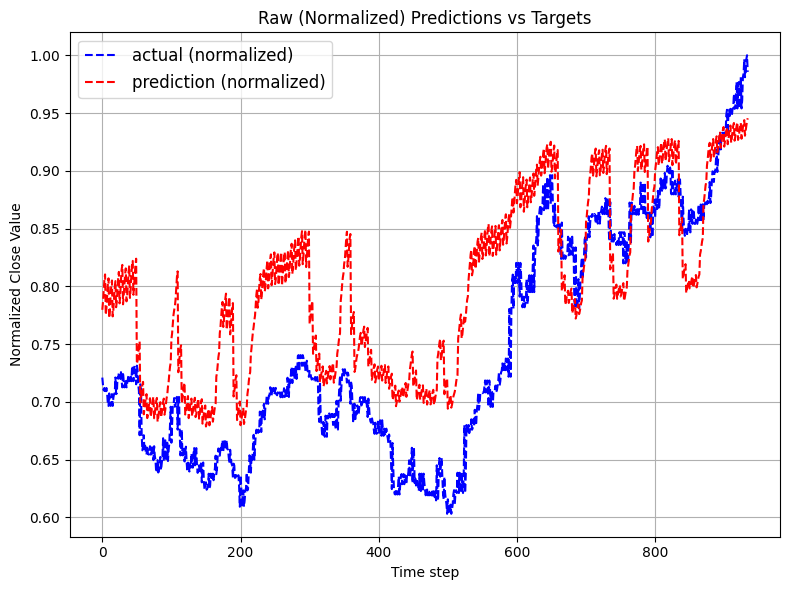

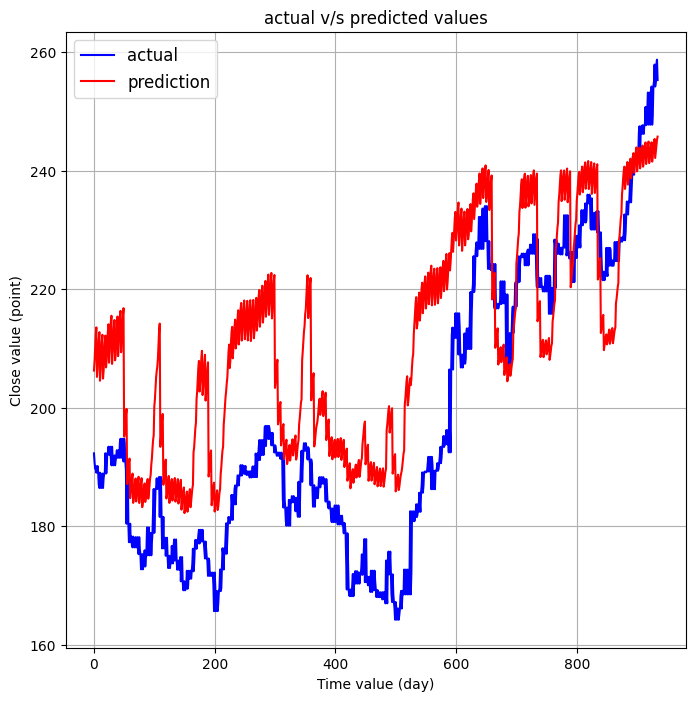

{'val_loss': 2.5178798634738206,
 'val_mae': 0.06549500674009323,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)